# Table of Contents 

* [Imports & Functions](#imports-and-functions)
* [Preliminary Analysis of Source Datasets](#source-datasets)
    * [Flows dataset](#flows-dataset)
        * [Iron-ore Flows](#iron-ore-flows)
    * [Pricing dataset](#pricing-dataset)
    * [Stocks dataset](#stocks-dataset)
    * [Data-Merge](#data-merge)
* [Exploratory Data Analysis](#EDA)
    * [Time-Series](#time-series)
    * [Correlation](#correlation)
    * [Scatterplots](#scatterplots)
* [Data Cleaning](#data-cleaning)
    * [Train-Test Split](#train-test)
    * [Data Aggregation](#data-aggregation)
    * [Handling Missing Values](#missing-values)
    * [Data Realignment](#data-realign)

# Imports & Functions <a class="anchor" id="imports-and-functions"></a>

In [1]:
pip install --upgrade pandas


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Users/rg/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install squarify


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Users/rg/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install textblob


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Users/rg/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install wordcloud


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: /Users/rg/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
#Importing packages 


#Basic imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify
from pandas.plotting import scatter_matrix
from datetime import datetime
import matplotlib.dates as mdates


#Visualisation packages
from wordcloud import WordCloud
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from functools import reduce

#File-handling
from joblib import Memory
import http.client
import requests 
import json
import csv
import os
import ast
import urllib.parse
from urllib.parse import quote_plus

/Users/rg/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [9]:
def fill_missing_values(df, columns):
    """
    Fills missing values in the specified columns of the DataFrame using a two-step process:
    1. Linear interpolation for non-weekend days.
    2. Forward-fill for weekends.

    Parameters:
    df (pd.DataFrame): The input DataFrame with a 'Date' column.
    columns (list): List of column names to fill.

    Returns:
    pd.DataFrame: The DataFrame with filled values.
    """
    # Setting Date as index
    df = df.set_index('Date', inplace=False)
    
    # Creating a boolean mask for weekends in dates
    weekend_mask = df.index.to_series().dt.weekday >= 5
    
    for col in columns:
        # Applying linear interpolation to non-weekends
        df[f'{col}'] = df[~weekend_mask][col].interpolate(method='linear')
        
        # Applying forward-fill to weekends
        df[f'{col}'] = df[f'{col}'].ffill()
    
    return df

#Defining a function to convert from ISO week to datetime object 
def iso_week_to_datetime(iso_week):
        """
    Converts an ISO week string to a datetime object representing the Monday of that week.

    Args:
        iso_week (str): A string in the format 'YYYY WW' where 'YYYY' is the year and 'WW' is the ISO week number.

    Returns:
        datetime: A datetime object representing the Monday of the specified ISO week.

    Example:
        >>> iso_week_to_datetime('2024 32')
        datetime.datetime(2024, 8, 5, 0, 0)
    """
    # Split the string based on space
    year, week = iso_week.split() #splitting on whitespace
    year = int(year)
    week = int(week)
    # Convert to datetime, assuming Monday as the first day of the week
    return datetime.fromisocalendar(year, week, 1)


def extract_date(data_str):
        """
    Extracts the 'date' value from a string representation of a dictionary.

    Args:
        data_str (str): A string representation of a dictionary that contains a 'date' key.

    Returns:
        str: The value associated with the 'date' key if successful, otherwise None.

    Raises:
        ValueError: If the string cannot be parsed as a dictionary.
        SyntaxError: If the string has a syntax error that prevents it from being parsed.
    """
    try:
        data_dict = ast.literal_eval(data_str)
        return data_dict['date']
    except (ValueError, SyntaxError) as e:
        print(f"Error parsing string: {e}")
        return None
    
    

def fetch_articles(api_key, base_url, start_page):
        """
    Fetches articles from the Reuters Business and Financial News API starting from a specified page.

    Args:
        api_key (str): The API key for authentication.
        base_url (str): The base URL for the API endpoint.
        start_page (int): The page number to start fetching articles from.

    Returns:
        list: A list of articles retrieved from the API.

    Raises:
        requests.RequestException: If an error occurs during the HTTP request.

    Example:
        >>> fetch_articles("your_api_key", "https://example.com/api", 1)
        [
            {"title": "Article 1", "content": "Content of article 1"},
            {"title": "Article 2", "content": "Content of article 2"},
            ...
        ]
    """
    headers = {
        "X-RapidAPI-Key": api_key,
        "X-RapidAPI-Host": "reuters-business-and-financial-news.p.rapidapi.com"
    }
    articles = []
    page = start_page

    while True:  # Use an infinite loop to keep fetching until no more articles are found
        url = f"{base_url}/{page}/20"
        response = requests.get(url, headers=headers)
        
        if response.status_code == 200:
            data = response.json()
            if not data['articles']:  # Check if no articles were returned
                print(f"No more articles to fetch. Stopped at page {page - 1}.")
                break  # Exit the loop if no articles are returned
            
            articles.extend(data['articles'])
            print(f"Successfully fetched articles from page {page}")
        else:
            print(f"Failed to fetch articles from page {page}: Status {response.status_code}")
            break  # Exit the loop if there is an HTTP error

        page += 1  

    return articles

In [10]:
#Reading in the datasets
flows = pd.read_csv('./Cargo_Flows_futures_limited.csv', low_memory=False)
pricing = pd.read_csv('./SGX_TSI_Iron_Ore_Front_SZZFc1_Second_SZZFc2.csv')
stocks = pd.read_csv('./Stocks_Weekly.csv')
customs = pd.read_csv('./Export_Iron_Ore_to_China.csv')
news_sentiment_TB = pd.read_csv('news_sentiment_TB')

In [11]:
# pd.__version__

# Preliminary Analysis of Source Datasets <a class="anchor" id="source-datasets"></a>

## Flows dataset <a class="anchor" id="flows-dataset"></a>

In [12]:
flows.head()

IMO  VoyageNumber          ArrivalDateLoad          SailingDateLoad  \
0  1047433             1  2024-04-09 19:51:42.000  2024-04-16 15:33:43.000   
1  1044493             9  2024-05-11 15:57:29.000  2024-05-17 22:36:38.437   
2  1044493             9  2024-05-09 23:59:40.000  2024-05-10 03:55:29.000   
3  1044493             8  2024-04-27 11:58:39.000  2024-04-30 19:55:39.000   
4  1044493             7  2024-04-04 19:52:21.000  2024-04-05 03:56:32.000   

   CargoTypeID     ArrivalDateDischarge     SailingDateDischarge   Quantity  \
0         5256  2024-04-23 03:54:14.000  2024-05-14 14:22:59.930  81800.000   
1           -2  2024-05-18 16:26:00.023  2024-05-19 07:46:04.327   1205.342   
2           -2  2024-05-18 16:26:00.023  2024-05-19 07:46:04.327    407.590   
3           -2  2024-05-08 23:53:12.000  2024-05-09 03:55:58.000   1612.932   
4           -2  2024-04-23 11:52:39.000  2024-04-27 03:54:02.000   1612.932   

  StartTimeOfOperationLoad StartTimeOfOperationDischarge  ... L0CargoTypeID  \
0      2024-04-09 19:51:42           2024-05-10 07:57:35  ...          -1.0   
1      2024-05-11 23:57:17                           NaN  ...          -2.0   
2      2024-05-09 23:59:40                           NaN  ...          -2.0   
3      2024-04-27 11:58:39           2024-05-09 03:55:58  ...          -2.0   
4      2024-04-04 23:55:01           2024-04-24 03:52:03  ...          -2.0   

  L0CargoName L1CargoTypeID L1CargoName L2CargoTypeID   L2CargoName  \
0     Unknown         -11.0     Unknown        5256.0  Thermal Coal   
1     Not set         -12.0     Not set         -22.0       Not set   
2     Not set         -12.0     Not set         -22.0       Not set   
3     Not set         -12.0     Not set         -22.0       Not set   
4     Not set         -12.0     Not set         -22.0       Not set   

  L3CargoTypeID L3CargoName L4CargoTypeID L4CargoName  
0          24.0        Coal        400000         Dry  
1         -32.0     Not set           -42     Not set  
2         -32.0     Not set           -42     Not set  
3         -32.0     Not set           -42     Not set  
4         -32.0     Not set           -42     Not set  

[5 rows x 35 columns]

In [13]:
flows.info() #checking count of non-null values and data types within the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2975501 entries, 0 to 2975500
Data columns (total 35 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   IMO                            int64  
 1   VoyageNumber                   int64  
 2   ArrivalDateLoad                object 
 3   SailingDateLoad                object 
 4   CargoTypeID                    int64  
 5   ArrivalDateDischarge           object 
 6   SailingDateDischarge           object 
 7   Quantity                       float64
 8   StartTimeOfOperationLoad       object 
 9   StartTimeOfOperationDischarge  object 
 10  EndTimeOfOperationLoad         object 
 11  EndTimeOfOperationDischarge    object 
 12  PortNameLoad                   object 
 13  GeoAssetNameLoad               object 
 14  CountryNameLoad                object 
 15  AreaNameLevel0Load             object 
 16  PortNameDischarge              object 
 17  GeoAssetNameDischarge          object 
 18  Co

In [14]:
flows.isnull().sum() #count of missing values 

IMO                                    0
VoyageNumber                           0
ArrivalDateLoad                        0
SailingDateLoad                        0
CargoTypeID                            0
ArrivalDateDischarge                   0
SailingDateDischarge                   0
Quantity                               0
StartTimeOfOperationLoad          596587
StartTimeOfOperationDischarge     606998
EndTimeOfOperationLoad            596587
EndTimeOfOperationDischarge       606998
PortNameLoad                           0
GeoAssetNameLoad                       0
CountryNameLoad                        0
AreaNameLevel0Load                     0
PortNameDischarge                      0
GeoAssetNameDischarge                  0
CountryNameDischarge                   0
AreaNameLevel0Discharge                0
CargoType                          29572
CargoName                              0
CargoTaxonomyID                        0
L-1CargoTypeID                   2956481
L-1CargoName    

In [15]:
flows.loc[flows['L4CargoName'] == 'Not set']

IMO  VoyageNumber          ArrivalDateLoad  \
1        1044493             9  2024-05-11 15:57:29.000   
2        1044493             9  2024-05-09 23:59:40.000   
3        1044493             8  2024-04-27 11:58:39.000   
4        1044493             7  2024-04-04 19:52:21.000   
5        1044493             6  2024-03-20 11:56:45.000   
...          ...           ...                      ...   
2975493  5025691           115  2016-04-20 11:41:05.000   
2975496  5025691           112  2016-04-04 15:59:08.000   
2975497  5025691           111  2015-01-21 23:52:41.000   
2975499  5025691           109  2014-12-31 17:44:38.000   
2975500  4512893             1  2024-05-13 16:14:01.050   

                 SailingDateLoad  CargoTypeID     ArrivalDateDischarge  \
1        2024-05-17 22:36:38.437           -2  2024-05-18 16:26:00.023   
2        2024-05-10 03:55:29.000           -2  2024-05-18 16:26:00.023   
3        2024-04-30 19:55:39.000           -2  2024-05-08 23:53:12.000   
4        2024-04-05 03:56:32.000           -2  2024-04-23 11:52:39.000   
5        2024-03-21 11:59:52.000           -2  2024-03-30 03:48:11.000   
...                          ...          ...                      ...   
2975493  2016-04-21 07:55:26.000           -2  2016-04-22 03:48:18.000   
2975496  2016-04-05 07:57:37.000           -2  2016-04-10 03:55:17.000   
2975497  2015-01-28 19:45:56.000           -2  2016-04-01 19:58:27.000   
2975499  2015-01-02 10:25:52.000           -2  2015-01-03 19:55:00.000   
2975500  2024-05-14 22:53:23.593           -2  2024-05-28 03:51:41.697   

            SailingDateDischarge   Quantity StartTimeOfOperationLoad  \
1        2024-05-19 07:46:04.327   1205.342      2024-05-11 23:57:17   
2        2024-05-19 07:46:04.327    407.590      2024-05-09 23:59:40   
3        2024-05-09 03:55:58.000   1612.932      2024-04-27 11:58:39   
4        2024-04-27 03:54:02.000   1612.932      2024-04-04 23:55:01   
5        2024-03-30 15:44:25.000   1612.932      2024-03-20 11:56:45   
...                          ...        ...                      ...   
2975493  2016-04-22 11:54:47.000  20335.536                      NaN   
2975496  2016-04-10 07:52:17.000  20335.536      2016-04-04 19:52:47   
2975497  2016-04-02 03:54:27.000  20335.536                      NaN   
2975499  2015-01-04 19:52:05.000  20335.536                      NaN   
2975500  2024-05-30 10:16:38.393    111.592                      NaN   

        StartTimeOfOperationDischarge  ... L0CargoTypeID L0CargoName  \
1                                 NaN  ...          -2.0     Not set   
2                                 NaN  ...          -2.0     Not set   
3                 2024-05-09 03:55:58  ...          -2.0     Not set   
4                 2024-04-24 03:52:03  ...          -2.0     Not set   
5                 2024-03-30 03:48:11  ...          -2.0     Not set   
...                               ...  ...           ...         ...   
2975493                           NaN  ...          -2.0     Not set   
2975496                           NaN  ...          -2.0     Not set   
2975497                           NaN  ...          -2.0     Not set   
2975499                           NaN  ...          -2.0     Not set   
2975500                           NaN  ...          -2.0     Not set   

        L1CargoTypeID L1CargoName L2CargoTypeID L2CargoName L3CargoTypeID  \
1               -12.0     Not set         -22.0     Not set         -32.0   
2               -12.0     Not set         -22.0     Not set         -32.0   
3               -12.0     Not set         -22.0     Not set         -32.0   
4               -12.0     Not set         -22.0     Not set         -32.0   
5               -12.0     Not set         -22.0     Not set         -32.0   
...               ...         ...           ...         ...           ...   
2975493         -12.0     Not set         -22.0     Not set         -32.0   
2975496         -12.0     Not set         -22.0     Not set         -

In [16]:
flows_undefined = flows.loc[flows['L4CargoName'] == 'Not set']

In [17]:
flows_undefined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2080489 entries, 1 to 2975500
Data columns (total 35 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   IMO                            int64  
 1   VoyageNumber                   int64  
 2   ArrivalDateLoad                object 
 3   SailingDateLoad                object 
 4   CargoTypeID                    int64  
 5   ArrivalDateDischarge           object 
 6   SailingDateDischarge           object 
 7   Quantity                       float64
 8   StartTimeOfOperationLoad       object 
 9   StartTimeOfOperationDischarge  object 
 10  EndTimeOfOperationLoad         object 
 11  EndTimeOfOperationDischarge    object 
 12  PortNameLoad                   object 
 13  GeoAssetNameLoad               object 
 14  CountryNameLoad                object 
 15  AreaNameLevel0Load             object 
 16  PortNameDischarge              object 
 17  GeoAssetNameDischarge          object 
 18  Country

In [18]:
flows_undefined.sort_values(by='ArrivalDateLoad', inplace=True) #sorting by date

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/2487500006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flows_undefined.sort_values(by='ArrivalDateLoad', inplace=True) #sorting by date


In [19]:
#Converting date-related columns
date_columns = ['ArrivalDateLoad', 'SailingDateLoad', 'ArrivalDateDischarge', 'SailingDateDischarge',
              'StartTimeOfOperationLoad', 'StartTimeOfOperationDischarge', 'EndTimeOfOperationLoad', 
               'EndTimeOfOperationDischarge']

for col in date_columns:
    flows_undefined[col] = pd.to_datetime(flows_undefined[col])

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/2272776471.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flows_undefined[col] = pd.to_datetime(flows_undefined[col])
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/2272776471.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flows_undefined[col] = pd.to_datetime(flows_undefined[col])
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/2272776471.py:7: SettingWithCopyWarning: 
A value is trying to be set on a

In [20]:
flows_undefined.dtypes #code to check

IMO                                       int64
VoyageNumber                              int64
ArrivalDateLoad                  datetime64[ns]
SailingDateLoad                  datetime64[ns]
CargoTypeID                               int64
ArrivalDateDischarge             datetime64[ns]
SailingDateDischarge             datetime64[ns]
Quantity                                float64
StartTimeOfOperationLoad         datetime64[ns]
StartTimeOfOperationDischarge    datetime64[ns]
EndTimeOfOperationLoad           datetime64[ns]
EndTimeOfOperationDischarge      datetime64[ns]
PortNameLoad                             object
GeoAssetNameLoad                         object
CountryNameLoad                          object
AreaNameLevel0Load                       object
PortNameDischarge                        object
GeoAssetNameDischarge                    object
CountryNameDischarge                     object
AreaNameLevel0Discharge                  object
CargoType                               

In [21]:
flows_undefined['ArrivalDateLoad'].min()

Timestamp('2014-09-03 07:53:36')

In [22]:
flows_undefined['ArrivalDateLoad'].max()

Timestamp('2024-08-12 06:34:55.680000')

In [23]:
flows_undefined['Year'] = flows_undefined['ArrivalDateLoad'].dt.year #extracting Year from datetime column  

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/3376911971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flows_undefined['Year'] = flows_undefined['ArrivalDateLoad'].dt.year #extracting Year from datetime column


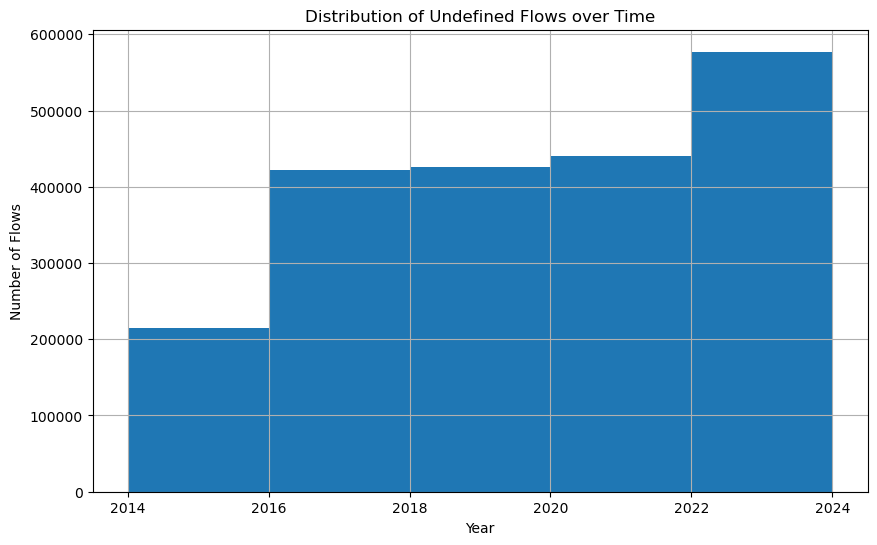

In [24]:
#Plotting distribution of flows over time 
plt.figure(figsize=(10, 6))
flows_undefined['Year'].hist(bins=5)
plt.title('Distribution of Undefined Flows over Time')
plt.xlabel('Year')
plt.ylabel('Number of Flows')
plt.grid(True)
plt.show()

A majority of the rows in the dataset carry undefined cargo reported as "Not set" within which the distribution suggests the number in recent reporting periods since 2022 has been the highest. It is likely that this number may increase even further as it includes the ongoing year, i.e., 2024. 

The 'Not Set' values were cross-checked with the customs data showing iron ore specific trade over this time period and it was observed that a very small percentage of the 'Not Set' flows relate to iron ore

As a result, we will maintain the data slice from the flows dataset for our analysis

### Iron Ore Flows <a class="anchor" id="iron-ore-flows"></a>

In [25]:
#Slicing df for flows related to iron ore fines 
fe_flows = flows.loc[flows['L2CargoName'] == 'Iron Ore Fines'] 

In [26]:
fe_flows.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 81783 entries, 1575 to 2890707
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   IMO                            81783 non-null  int64  
 1   VoyageNumber                   81783 non-null  int64  
 2   ArrivalDateLoad                81783 non-null  object 
 3   SailingDateLoad                81783 non-null  object 
 4   CargoTypeID                    81783 non-null  int64  
 5   ArrivalDateDischarge           81783 non-null  object 
 6   SailingDateDischarge           81783 non-null  object 
 7   Quantity                       81783 non-null  float64
 8   StartTimeOfOperationLoad       81253 non-null  object 
 9   StartTimeOfOperationDischarge  79098 non-null  object 
 10  EndTimeOfOperationLoad         81253 non-null  object 
 11  EndTimeOfOperationDischarge    79098 non-null  object 
 12  PortNameLoad                   81783 non-null 

In [27]:
#Converting date-related columns
date_columns = ['ArrivalDateLoad', 'SailingDateLoad', 'ArrivalDateDischarge', 'SailingDateDischarge',
              'StartTimeOfOperationLoad', 'StartTimeOfOperationDischarge', 'EndTimeOfOperationLoad', 
               'EndTimeOfOperationDischarge']

for col in date_columns:
    fe_flows[col] = pd.to_datetime(fe_flows[col])

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1770517220.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_flows[col] = pd.to_datetime(fe_flows[col])
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1770517220.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_flows[col] = pd.to_datetime(fe_flows[col])
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1770517220.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [28]:
fe_flows['SailingDateLoad'].min()

Timestamp('2014-10-22 11:49:00')

In [29]:
fe_flows['SailingDateLoad'].max()

Timestamp('2025-05-14 23:59:59')

For the flows of iron ore fines, we have a total of 81783 cargo flows covering the period from 2014-10-22 to 2025-05-14.

In [30]:
fe_flows['SailingDateLoad'].max()

Timestamp('2025-05-14 23:59:59')

In [31]:
fe_flows['Year'] = fe_flows['ArrivalDateLoad'].dt.year #extracting Year from datetime column  

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1916906356.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_flows['Year'] = fe_flows['ArrivalDateLoad'].dt.year #extracting Year from datetime column


In [32]:
fe_flows.isnull().sum() #checking null values for this data-slice

IMO                                  0
VoyageNumber                         0
ArrivalDateLoad                      0
SailingDateLoad                      0
CargoTypeID                          0
ArrivalDateDischarge                 0
SailingDateDischarge                 0
Quantity                             0
StartTimeOfOperationLoad           530
StartTimeOfOperationDischarge     2685
EndTimeOfOperationLoad             530
EndTimeOfOperationDischarge       2685
PortNameLoad                         0
GeoAssetNameLoad                     0
CountryNameLoad                      0
AreaNameLevel0Load                   0
PortNameDischarge                    0
GeoAssetNameDischarge                0
CountryNameDischarge                 0
AreaNameLevel0Discharge              0
CargoType                            1
CargoName                            0
CargoTaxonomyID                      0
L-1CargoTypeID                   81783
L-1CargoName                     81783
L0CargoTypeID            

We can observe that some loading operation and more discharge operation datetimes are missing but we will ignore these for our analysis

<Axes: >

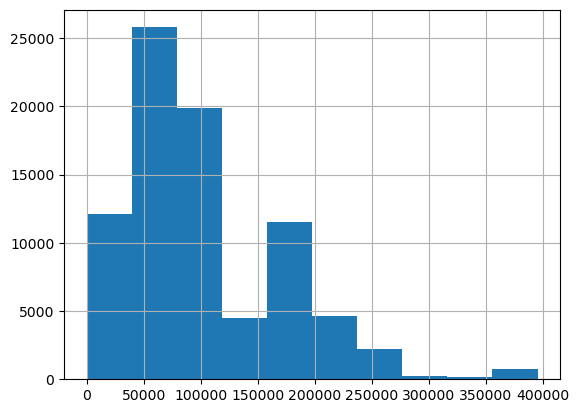

In [33]:
fe_flows['Quantity'].hist() #checking distribution of volume of Fe fines 

In [34]:
fe_flows_sorted = fe_flows.sort_values(by='ArrivalDateLoad', ascending=True)

In [35]:
fe_flows_sorted

IMO  VoyageNumber         ArrivalDateLoad  \
2331179  9133862            37 2014-10-17 11:54:01.000   
2331178  9133862            37 2014-10-17 11:54:01.000   
2331177  9133862            37 2014-10-17 11:54:01.000   
2583153  9002673            19 2014-10-20 15:44:00.000   
2583152  9002673            19 2014-10-20 15:44:00.000   
...          ...           ...                     ...   
471281   9678800            76 2024-05-22 08:07:47.777   
13069    9939345            14 2024-05-22 10:25:34.147   
18591    9927976            16 2024-05-23 01:00:24.957   
775673   9598567            90 2024-05-24 05:33:40.430   
367613   9713818            44 2024-05-26 23:59:59.000   

                SailingDateLoad  CargoTypeID    ArrivalDateDischarge  \
2331179 2014-10-22 11:49:00.000         5258 2014-12-09 03:44:09.000   
2331178 2014-10-22 11:49:00.000         5258 2014-12-13 07:53:19.000   
2331177 2014-10-22 11:49:00.000         5258 2014-12-20 11:50:16.000   
2583153 2014-11-01 03:29:34.000         5258 2014-12-12 05:45:01.500   
2583152 2014-11-01 03:29:34.000         5258 2014-12-31 15:16:36.000   
...                         ...          ...                     ...   
471281  2024-05-26 20:17:35.917         5258 2024-06-10 06:32:35.393   
13069   2024-05-26 22:35:22.287         5258 2024-06-10 11:48:06.720   
18591   2024-05-27 13:10:13.097         5258 2024-06-10 23:25:12.573   
775673  2024-06-01 23:59:59.000         5258 2024-06-16 10:14:58.477   
367613  2024-05-31 20:04:39.347         5258 2024-06-16 18:58:14.423   

           SailingDateDischarge    Quantity StartTimeOfOperationLoad  \
2331179 2014-12-11 19:49:27.000   66077.369      2014-10-20 15:52:00   
2331178 2014-12-19 23:52:30.000   29686.934      2014-10-20 15:52:00   
2331177 2015-01-03 07:49:46.000   67981.753      2014-10-20 15:52:00   
2583153 2014-12-25 15:52:11.000   99208.395      2014-10-30 07:50:33   
2583152 2015-01-02 07:48:09.000  134503.403      2014-10-30 07:50:33   
...                         ...         ...                      ...   
471281  2024-06-14 02:25:18.647  200346.651                      NaT   
13069   2024-06-14 19:09:39.313  204157.593                      NaT   
18591   2024-06-14 19:17:55.823   94933.271                      NaT   
775673  2024-06-20 06:07:41.727  105000.000                      NaT   
367613  2024-06-21 06:34:43.730   60000.000                      NaT   

        StartTimeOfOperationDischarge  ... L0CargoName L1CargoTypeID  \
2331179           2014-12-10 03:49:27  ...     Unknown         -11.0   
2331178           2014-12-18 07:52:33  ...     Unknown         -11.0   
2331177                           NaT  ...     Unknown         -11.0   
2583153           2014-12-21 07:58:02  ...     Unknown         -11.0   
2583152           2015-01-01 07:48:07  ...     Unknown         -11.0   
...                               ...  ...         ...           ...   
471281                            NaT  ...     Unknown         -11.0   
13069                             NaT  ...     Unknown         -11.0   
18591                             NaT  ...     Unknown         -11.0   
775673                            NaT  ...     Unknown         -11.0   
367613                            NaT  ...     Unknown         -11.0   

        L1CargoName L2CargoTypeID     L2CargoName L3CargoTypeID L3CargoName  \
2331179     Unknown        5258.0  Iron Ore Fines          28.0    Iron Ore   
2331178     Unknown        5258.0  Iron Ore Fines          28.0    Iron Ore   
2331177     Unknown        5258.0  Iron Ore Fines          28.0    Iron Ore   
2583153     Unknown        5258.0  Iron Ore Fines          28.0    Iron Ore   
2583152     Unknown        5258.0  Iron Ore Fines          28.0    Iron Ore   
...             ...           ...             ...           ...         ...   
471281      Unknown        5258.0  Iron Ore Fines          28.0    Iron Ore   
13069       Unknown        5258.0  Iron Ore Fines          28.0    Iron Ore   
18591     

#### Exports

In [36]:
fe_exports = fe_flows.groupby('CountryNameLoad')['Quantity'].sum().reset_index()

In [37]:
fe_exports.sort_values(by='Quantity', ascending=False, inplace=True)

In [38]:
fe_major_exp = fe_exports[:10]

In [39]:
fe_major_exp

CountryNameLoad      Quantity
2        Australia  6.131002e+09
5           Brazil  1.346753e+09
23        Malaysia  1.816902e+08
15           India  1.428592e+08
40    South Africa  1.119748e+08
7            Chile  7.938604e+07
31          Norway  5.250542e+07
22         Liberia  3.911077e+07
6           Canada  3.617160e+07
30     New Zealand  2.463086e+07

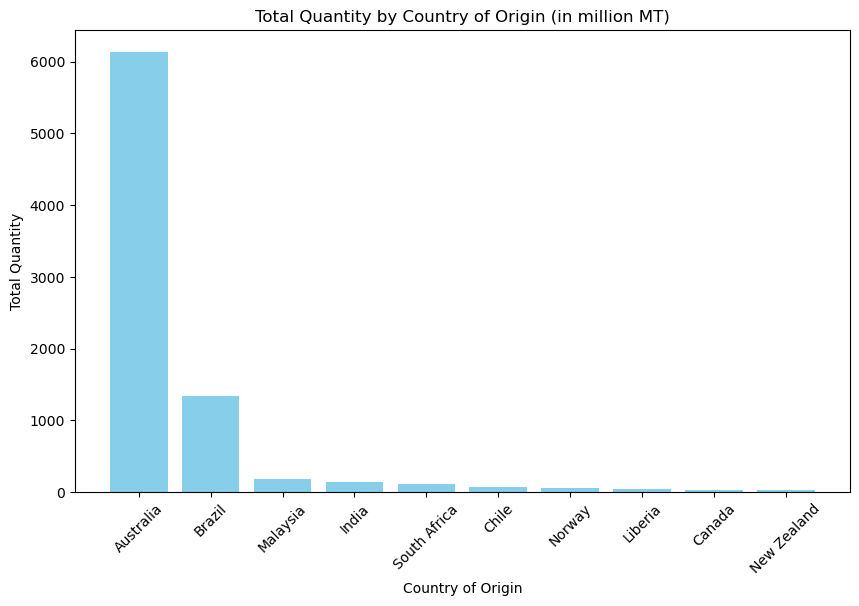

In [40]:
plt.figure(figsize=(10, 6))  
plt.bar(fe_major_exp['CountryNameLoad'], fe_major_exp['Quantity']/1e6, color='skyblue')
plt.xlabel('Country of Origin')  
plt.ylabel('Total Quantity') 
plt.title('Total Quantity by Country of Origin (in million MT)')  
plt.xticks(rotation=45)  
plt.show()

In [41]:
major_exp_country = fe_major_exp['CountryNameLoad'].values.reshape(-1)

In [42]:
major_exp_quantity = fe_major_exp['Quantity'].values.reshape(-1)

<function matplotlib.pyplot.show(close=None, block=None)>

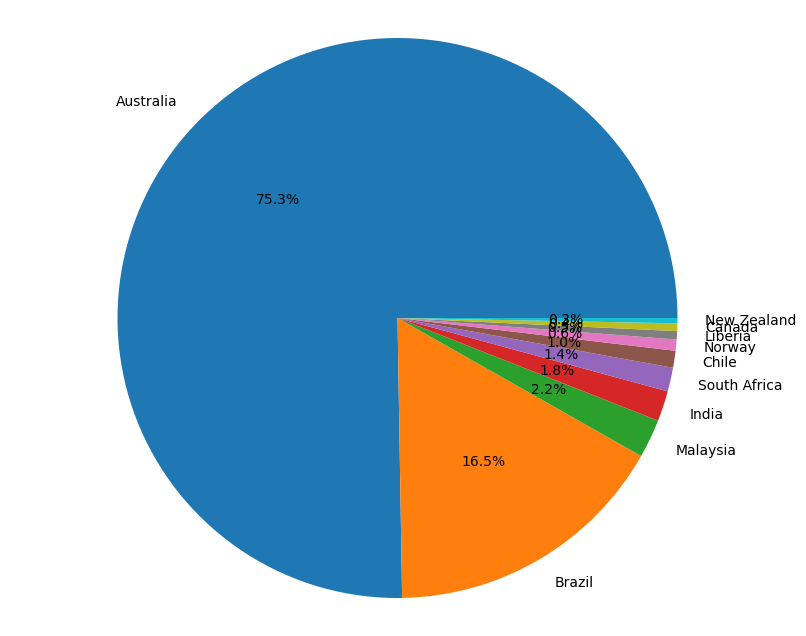

In [43]:
#Plotting pie chart of exports 

plt.figure(figsize=(10,8))  
plt.pie(x=major_exp_quantity, labels=major_exp_country, autopct='%1.1f%%')

plt.axis('equal')

plt.show

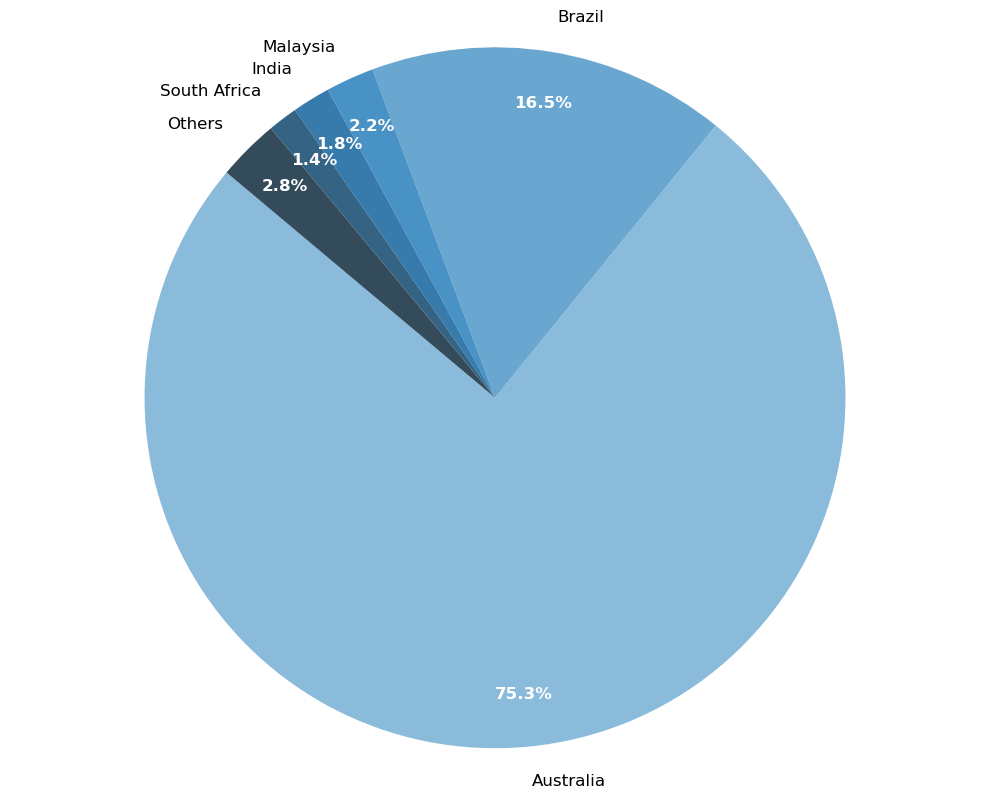

In [44]:
#Visualisation for the report

#Sorting the data by quantity
sorted_indices = np.argsort(major_exp_quantity)[::-1]
major_exp_country = major_exp_country[sorted_indices]
major_exp_quantity = major_exp_quantity[sorted_indices]

#Getting the top 5 and the rest combined into 'Others'
top_5_countries = major_exp_country[:5]
top_5_quantities = major_exp_quantity[:5]
others_quantity = major_exp_quantity[5:].sum()

#Appending 'Others' category
top_5_countries = np.append(top_5_countries, 'Others')
top_5_quantities = np.append(top_5_quantities, others_quantity)

#Creating the pie chart
plt.figure(figsize=(10, 8))
colors = sns.color_palette("Blues_d", len(top_5_countries))
wedges, texts, autotexts = plt.pie(top_5_quantities, labels=top_5_countries, autopct='%1.1f%%', startangle=140, colors=colors, pctdistance=0.85)

#Improving label visibility
for text in texts:
    text.set_fontsize(12)
    text.set_color('black')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('white')
    autotext.set_weight('bold')


#Ensuring aspect ratio of pie chart
plt.axis('equal')

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

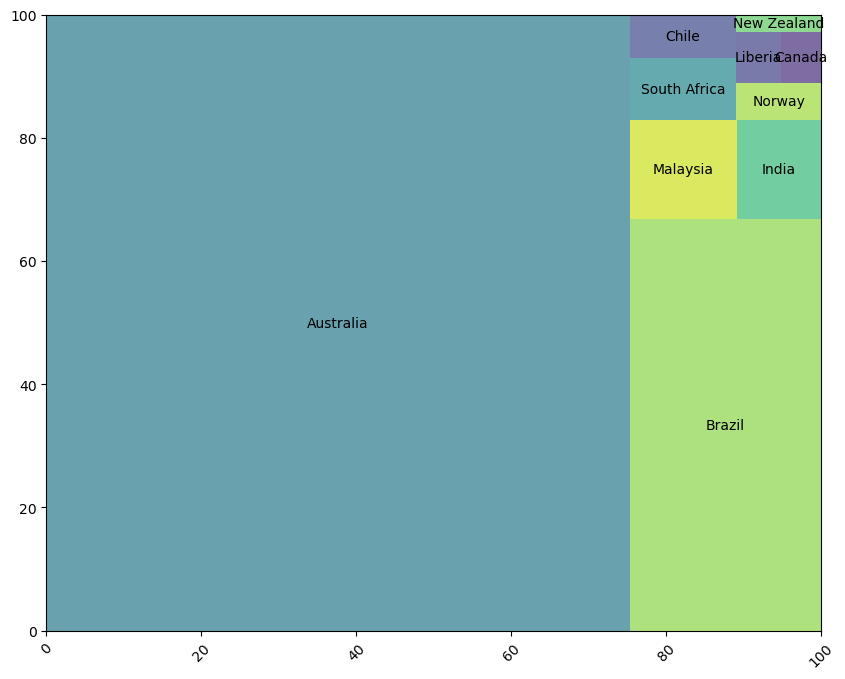

In [45]:
#Creating treemap of export countries 
plt.figure(figsize=(10,8))  
squarify.plot(sizes=major_exp_quantity, label=major_exp_country, alpha=0.7)

plt.xticks(rotation=45)  

plt.show

#### Imports

In [46]:
fe_imports = fe_flows.groupby('CountryNameDischarge')['Quantity'].sum().reset_index()
fe_imports

CountryNameDischarge      Quantity
0                             Algeria  2.253214e+06
1                              Angola  4.754878e+04
2                           Argentina  2.345185e+05
3                           Australia  2.206456e+07
4                             Bahrain  7.851108e+07
..                                ...           ...
64                     United Kingdom  1.248272e+07
65                      United States  4.709902e+05
66                            Uruguay  4.900721e+03
67  Venezuela, Bolivarian Republic of  8.173376e+04
68                           Viet Nam  6.542847e+07

[69 rows x 2 columns]

In [47]:
fe_imports.sort_values(by='Quantity', ascending=False, inplace=True)
fe_imports

CountryNameDischarge      Quantity
13                China  6.253940e+09
31   Korea, Republic of  6.216515e+08
29                Japan  4.067295e+08
35             Malaysia  2.030263e+08
40          Netherlands  1.045414e+08
..                  ...           ...
10               Canada  3.670453e+03
14        Cote d'Ivoire  2.982987e+03
45                 Peru  2.582716e+03
19              Georgia  2.511395e+03
27                 Iraq  1.260356e+03

[69 rows x 2 columns]

In [48]:
fe_major_imp = fe_imports[:10] #considering just top 10 importers by volume 
fe_major_imp

CountryNameDischarge      Quantity
13                China  6.253940e+09
31   Korea, Republic of  6.216515e+08
29                Japan  4.067295e+08
35             Malaysia  2.030263e+08
40          Netherlands  1.045414e+08
42                 Oman  9.111363e+07
4               Bahrain  7.851108e+07
25                India  7.505066e+07
60               Taiwan  7.114863e+07
68             Viet Nam  6.542847e+07

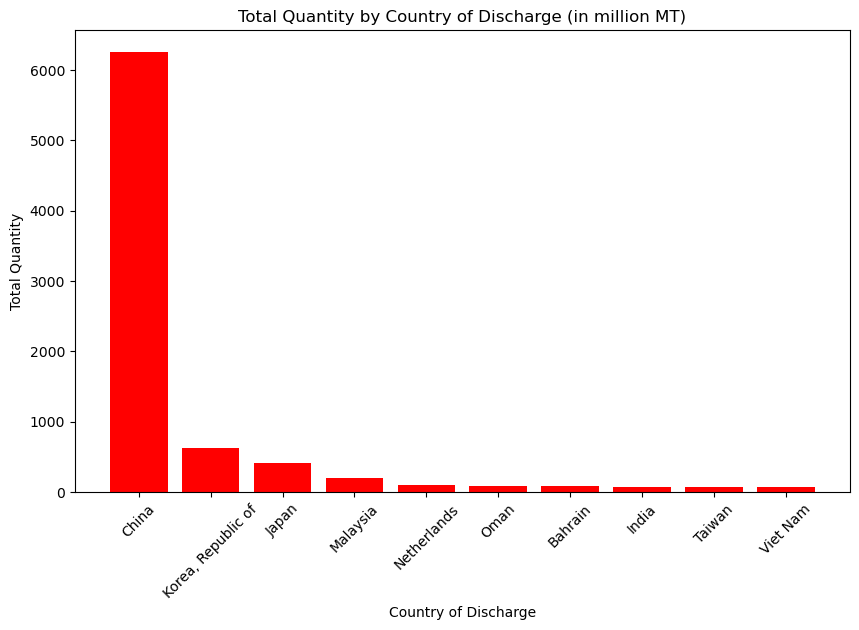

In [49]:
#Plotting total imports by country
plt.figure(figsize=(10, 6))  
plt.bar(fe_major_imp['CountryNameDischarge'], fe_major_imp['Quantity']/1e6, color='red')
plt.xlabel('Country of Discharge')  
plt.ylabel('Total Quantity') 
plt.title('Total Quantity by Country of Discharge (in million MT)')  
plt.xticks(rotation=45)  
plt.show()

In [50]:
#Creating 1-D arrays for pie chart representation 
major_imp_country = fe_major_imp['CountryNameDischarge'].values.reshape(-1)
major_imp_quantity = fe_major_imp['Quantity'].values.reshape(-1)

<function matplotlib.pyplot.show(close=None, block=None)>

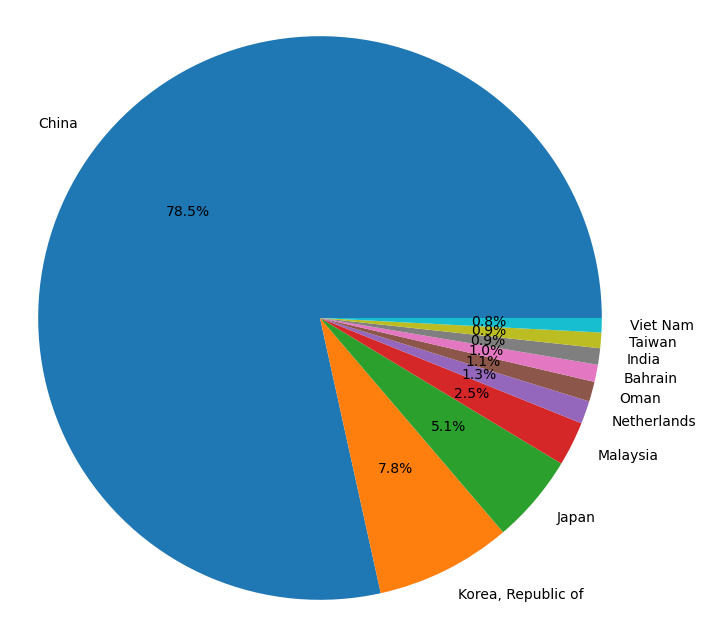

In [51]:
#Plotting pie chart of imports 

plt.figure(figsize=(8, 8))  
plt.pie(x=major_imp_quantity, labels=major_imp_country, autopct='%1.1f%%')

plt.axis('equal')

plt.show

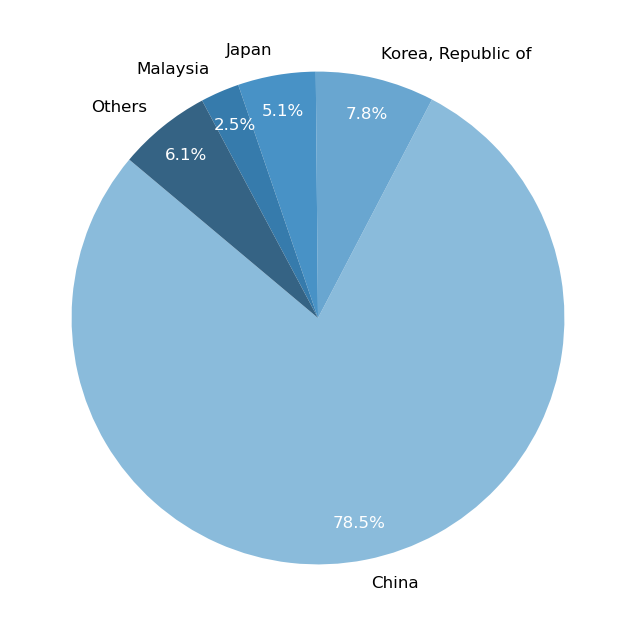

In [52]:
#Visualisation for the report 

#Major importers 


sorted_indices = np.argsort(major_imp_quantity)[::-1]
major_imp_country = major_imp_country[sorted_indices]
major_imp_quantity = major_imp_quantity[sorted_indices]

top_4_countries = major_imp_country[:4]
top_4_quantities = major_imp_quantity[:4]
others_quantity = major_imp_quantity[4:].sum()

top_4_countries = np.append(top_4_countries, 'Others')
top_4_quantities = np.append(top_4_quantities, others_quantity)

#Creating the pie chart
plt.figure(figsize=(10, 8))
colors = sns.color_palette("Blues_d", len(top_5_countries))
wedges, texts, autotexts = plt.pie(top_4_quantities, labels=top_4_countries, autopct='%1.1f%%', startangle=140, colors=colors, pctdistance=0.85)

for text in texts:
    text.set_fontsize(12)
    text.set_color('black')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('w')

<function matplotlib.pyplot.show(close=None, block=None)>

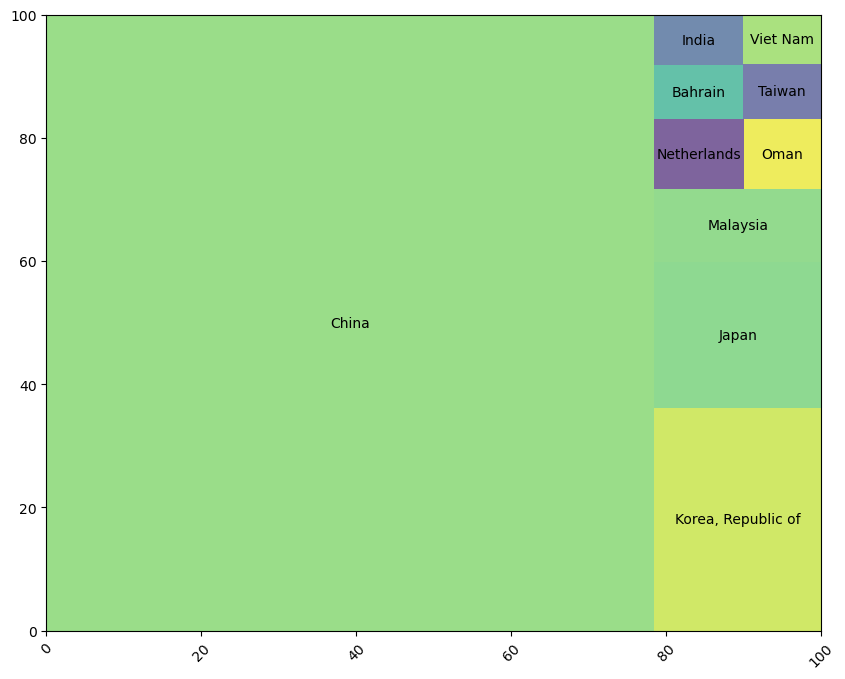

In [53]:
#Creating treemap of import countries 
plt.figure(figsize=(10,8))  
squarify.plot(sizes=major_imp_quantity, label=major_imp_country, alpha=0.7)

plt.xticks(rotation=45)  

plt.show

We see that Australia and Brazil emerge as the major exporters of iron ore fines while China is the major importer with South Korea and Japan to follow

#### Trade between majors

In [54]:
#Creating new data-slice with select columns

fe_exp_imp = fe_flows.loc[:,['ArrivalDateLoad', 'SailingDateLoad','ArrivalDateDischarge', 'SailingDateDischarge','CountryNameLoad', 
                               'CountryNameDischarge','Quantity']]

In [55]:
#Slicing further to focus on trade between major exporters and importers

majors_to_majors = fe_exp_imp.loc[(fe_exp_imp['CountryNameLoad'].isin(['Australia', 'Brazil'])) & (fe_exp_imp['CountryNameDischarge'].isin(['China', 'Korea, Republic of', 'Japan']))]

In [56]:
#Aggregating flow volumes for all countries and for trade between majors exporters and importers
aggregate_all_countries = fe_exp_imp['Quantity'].sum()
aggregate_majors_to_majors = majors_to_majors['Quantity'].sum()

In [57]:
aggregate_all_rounded = round(aggregate_all_countries/1e6,2)
aggregate_all_rounded

8212.99

In [58]:
remainder_quantity = aggregate_all_countries - aggregate_majors_to_majors

quantities = [aggregate_majors_to_majors, remainder_quantity]
labels = ['Majors Quantity', 'Remaining Quantity']
colors = ['green', 'lightgray']  

In [59]:
#Checking quantity traded with at least one non-major country involved
round(remainder_quantity/1e6,2)

1422.77

In [60]:
#Checking quantity traded between majors
round(aggregate_majors_to_majors/1e6,2)

6790.23

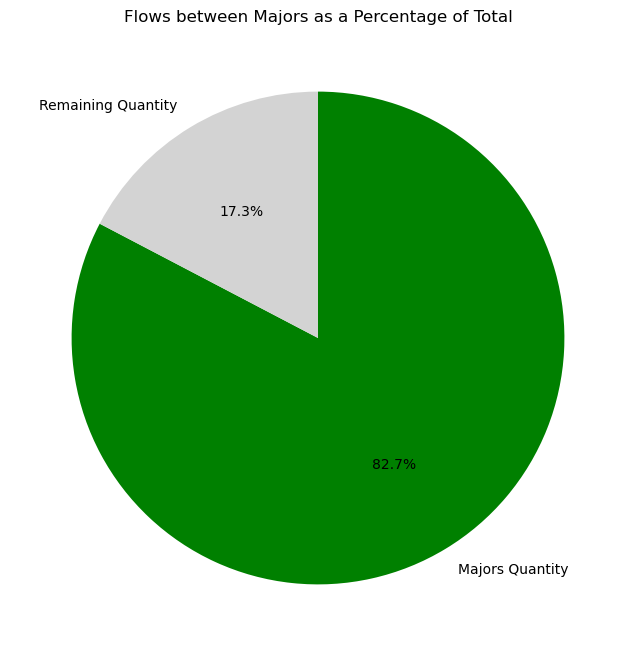

In [61]:
# Creating a pie chart 
plt.figure(figsize=(8, 8))  
plt.pie(quantities, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Flows between Majors as a Percentage of Total')
plt.show()

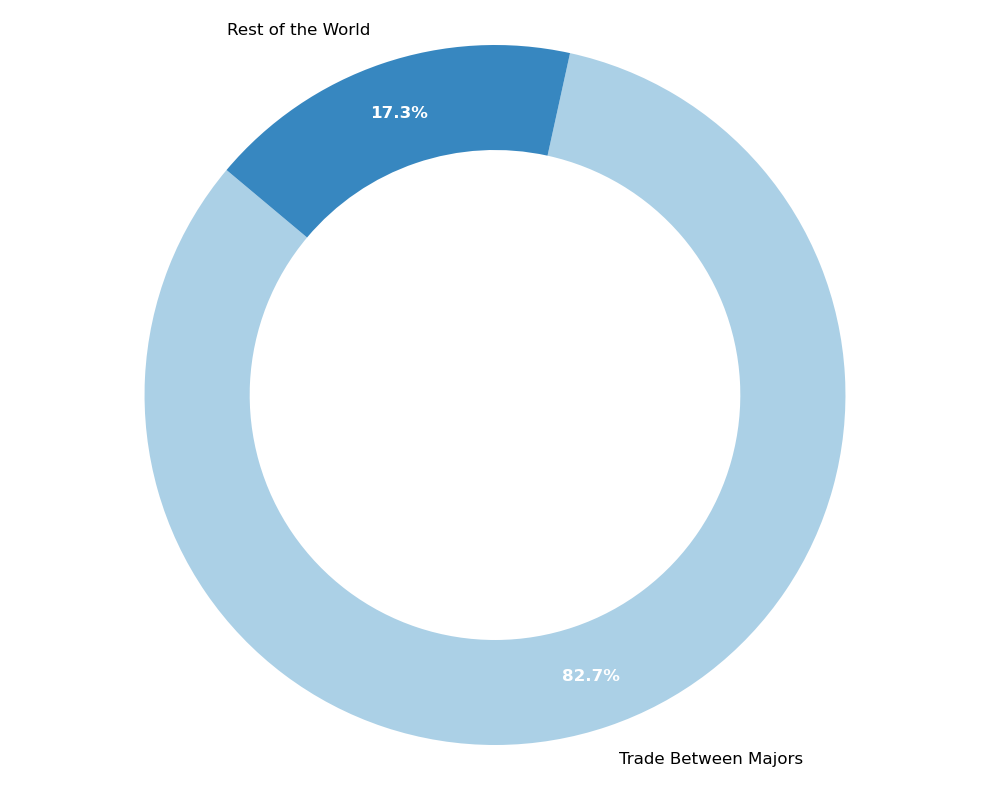

In [62]:
#Plotting trade between majors

labels = ['Trade Between Majors', 'Rest of the World']
colors = sns.color_palette("Blues", len(labels))

plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(quantities, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, pctdistance=0.85, wedgeprops=dict(width=0.3))

for text in texts:
    text.set_fontsize(12)
    text.set_color('black')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('white')
    autotext.set_weight('bold')

plt.axis('equal')

plt.tight_layout()
plt.show()

#### Time-series of flows

In [63]:
flows_1 = flows.copy()

#Converting the date & time-related columns to datetime objects
date_columns = ['ArrivalDateLoad', 'SailingDateLoad', 'ArrivalDateDischarge', 'SailingDateDischarge',
              'StartTimeOfOperationLoad', 'StartTimeOfOperationDischarge', 'EndTimeOfOperationLoad', 
               'EndTimeOfOperationDischarge']

for col in date_columns:
    flows_1[col] = pd.to_datetime(flows_1[col])

In [64]:
flows_1['SailingDateLoad'].max() 

Timestamp('2025-05-14 23:59:59')

In [65]:
#Aggregating quantities at quarterly frequency up until April 30, 2024
quarterly_volume_1 = flows_1.resample(rule='QE', on='SailingDateLoad')['Quantity'].sum().reset_index()
quarterly_volume_1

SailingDateLoad      Quantity
0       2014-09-30  5.991349e+05
1       2014-12-31  4.085957e+08
2       2015-03-31  1.324891e+09
3       2015-06-30  1.408113e+09
4       2015-09-30  1.439608e+09
5       2015-12-31  1.435494e+09
6       2016-03-31  1.369658e+09
7       2016-06-30  1.453984e+09
8       2016-09-30  1.487935e+09
9       2016-12-31  1.521303e+09
10      2017-03-31  1.461330e+09
11      2017-06-30  1.540933e+09
12      2017-09-30  1.577774e+09
13      2017-12-31  1.598779e+09
14      2018-03-31  1.523534e+09
15      2018-06-30  1.633737e+09
16      2018-09-30  1.641180e+09
17      2018-12-31  1.671247e+09
18      2019-03-31  1.552027e+09
19      2019-06-30  1.666265e+09
20      2019-09-30  1.656207e+09
21      2019-12-31  1.684336e+09
22      2020-03-31  1.539259e+09
23      2020-06-30  1.606158e+09
24      2020-09-30  1.648447e+09
25      2020-12-31  1.689929e+09
26      2021-03-31  1.623093e+09
27      2021-06-30  1.745409e+09
28      2021-09-30  1.727800e+09
29      2021-12-31  1.748513e+09
30      2022-03-31  1.632306e+09
31      2022-06-30  1.732004e+09
32      2022-09-30  1.720488e+09
33      2022-12-31  1.750269e+09
34      2023-03-31  1.688367e+09
35      2023-06-30  1.818256e+09
36      2023-09-30  1.798484e+09
37      2023-12-31  1.817724e+09
38      2024-03-31  1.715219e+09
39      2024-06-30  1.114693e+09
40      2024-09-30  2.245987e+05
41      2024-12-31  0.000000e+00
42      2025-03-31  0.000000e+00
43      2025-06-30  2.033575e+05

In [66]:
quarterly_volume_1 = quarterly_volume_1.drop([0,1, 39, 40, 41, 42, 43]) #dropping edges

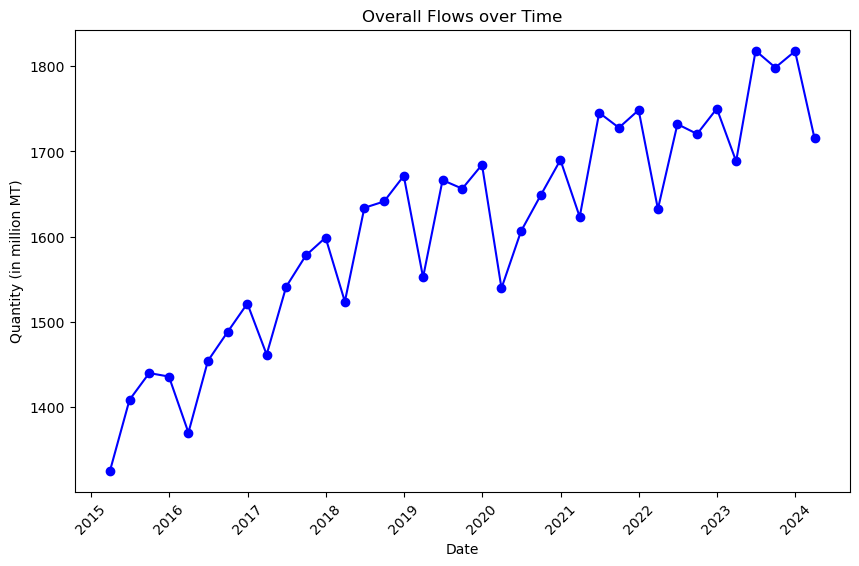

In [67]:
#Plotting quarterly volumes 
plt.figure(figsize=(10, 6))  
plt.plot(quarterly_volume_1['SailingDateLoad'], (quarterly_volume_1['Quantity']/1e6), marker='o', linestyle='-', color='b') 
plt.xlabel('Date')  
plt.ylabel('Quantity (in million MT)') 
plt.title('Overall Flows over Time')  
plt.xticks(rotation=45)  
plt.show()

In [68]:
#Repeating time-series analysis for iron ore fines slice

fe_flows_1 = fe_flows.copy()

for col in date_columns:
    fe_flows_1[col] = pd.to_datetime(fe_flows_1[col])

In [69]:
fe_flows_1['SailingDateLoad'].max()

Timestamp('2025-05-14 23:59:59')

In [70]:
#Slicing dataset to exclude future sailing dates 
fe_flows_1_slice = fe_flows_1[fe_flows_1['SailingDateLoad'] < '2025-04-30 23:59:59']

In [71]:
#Aggregating quantities at quarterly frequency up until April 30, 2024
quarterly_volume = fe_flows_1_slice.resample(rule='QE', on='SailingDateLoad')['Quantity'].sum().reset_index()
quarterly_volume

SailingDateLoad      Quantity
0       2014-12-31  5.338491e+07
1       2015-03-31  1.742151e+08
2       2015-06-30  1.902171e+08
3       2015-09-30  1.979378e+08
4       2015-12-31  1.972350e+08
5       2016-03-31  1.888220e+08
6       2016-06-30  2.011315e+08
7       2016-09-30  2.056958e+08
8       2016-12-31  2.116974e+08
9       2017-03-31  1.898724e+08
10      2017-06-30  2.041055e+08
11      2017-09-30  2.060502e+08
12      2017-12-31  2.101467e+08
13      2018-03-31  1.956686e+08
14      2018-06-30  2.150352e+08
15      2018-09-30  2.034938e+08
16      2018-12-31  2.064009e+08
17      2019-03-31  1.894768e+08
18      2019-06-30  2.186249e+08
19      2019-09-30  2.117155e+08
20      2019-12-31  2.099199e+08
21      2020-03-31  1.990184e+08
22      2020-06-30  2.395166e+08
23      2020-09-30  2.320498e+08
24      2020-12-31  2.355073e+08
25      2021-03-31  2.273825e+08
26      2021-06-30  2.543024e+08
27      2021-09-30  2.558250e+08
28      2021-12-31  2.549542e+08
29      2022-03-31  2.256154e+08
30      2022-06-30  2.458221e+08
31      2022-09-30  2.494172e+08
32      2022-12-31  2.581990e+08
33      2023-03-31  2.306781e+08
34      2023-06-30  2.290953e+08
35      2023-09-30  2.255102e+08
36      2023-12-31  2.344380e+08
37      2024-03-31  2.145454e+08
38      2024-06-30  1.200649e+08

In [72]:
quarterly_volume = quarterly_volume.drop([0,38]) #dropping first and last readings as they represent outliers

In [73]:
quarterly_volume #code to check

SailingDateLoad      Quantity
1       2015-03-31  1.742151e+08
2       2015-06-30  1.902171e+08
3       2015-09-30  1.979378e+08
4       2015-12-31  1.972350e+08
5       2016-03-31  1.888220e+08
6       2016-06-30  2.011315e+08
7       2016-09-30  2.056958e+08
8       2016-12-31  2.116974e+08
9       2017-03-31  1.898724e+08
10      2017-06-30  2.041055e+08
11      2017-09-30  2.060502e+08
12      2017-12-31  2.101467e+08
13      2018-03-31  1.956686e+08
14      2018-06-30  2.150352e+08
15      2018-09-30  2.034938e+08
16      2018-12-31  2.064009e+08
17      2019-03-31  1.894768e+08
18      2019-06-30  2.186249e+08
19      2019-09-30  2.117155e+08
20      2019-12-31  2.099199e+08
21      2020-03-31  1.990184e+08
22      2020-06-30  2.395166e+08
23      2020-09-30  2.320498e+08
24      2020-12-31  2.355073e+08
25      2021-03-31  2.273825e+08
26      2021-06-30  2.543024e+08
27      2021-09-30  2.558250e+08
28      2021-12-31  2.549542e+08
29      2022-03-31  2.256154e+08
30      2022-06-30  2.458221e+08
31      2022-09-30  2.494172e+08
32      2022-12-31  2.581990e+08
33      2023-03-31  2.306781e+08
34      2023-06-30  2.290953e+08
35      2023-09-30  2.255102e+08
36      2023-12-31  2.344380e+08
37      2024-03-31  2.145454e+08

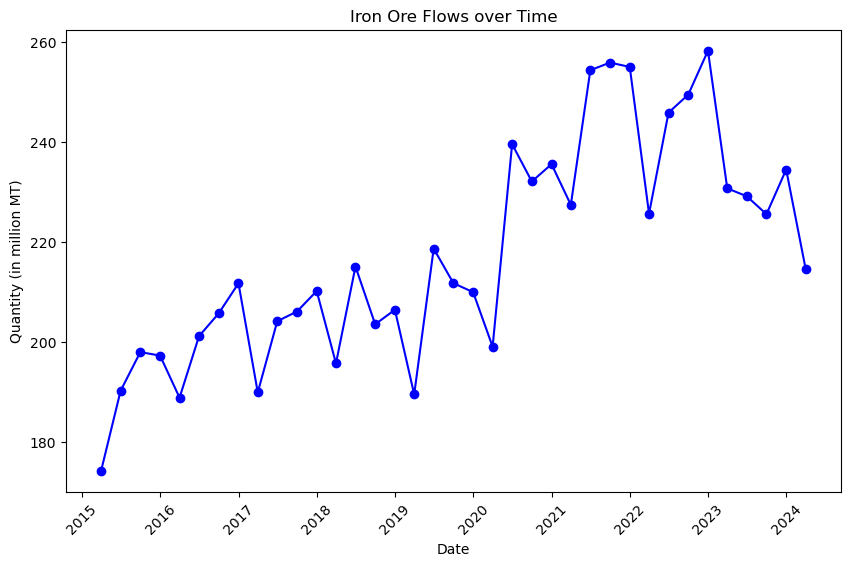

In [74]:
#Visualisation for the report

#Plotting iron ore fines flows

plt.figure(figsize=(10, 6))  
plt.plot(quarterly_volume['SailingDateLoad'], (quarterly_volume['Quantity']/1e6), marker='o', linestyle='-', color='b') 
plt.xlabel('Date')  
plt.ylabel('Quantity (in million MT)') 
plt.title('Iron Ore Flows over Time')  
plt.xticks(rotation=45)  
plt.show()

In [75]:
#Creating a new Date column in Fe flows dataset
fe_flows['Date'] = fe_flows['SailingDateLoad'].dt.date #extracting date information from Sailing Date 
fe_flows['Date'] = pd.to_datetime(fe_flows['Date'], errors='coerce')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/4270005416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_flows['Date'] = fe_flows['SailingDateLoad'].dt.date #extracting date information from Sailing Date
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/4270005416.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fe_flows['Date'] = pd.to_datetime(fe_flows['Date'], errors='coerce')


## Pricing dataset  <a class="anchor" id="pricing-dataset"></a>

In [76]:
pricing.head()

Exchange Date   HIGH    LOW   OPEN  CLOSE  VOLUME  COUNT     RIC  \
0    2015-01-02    NaN    NaN    NaN  70.25     NaN   -1.0  SZZFc2   
1    2015-01-05    NaN    NaN    NaN  69.41     NaN   -1.0  SZZFc2   
2    2015-01-06  71.52  69.97  69.97  71.19    67.0   -1.0  SZZFc2   
3    2015-01-07  70.50  69.93  70.50  70.50    54.0   -1.0  SZZFc2   
4    2015-01-08  70.20  69.90  70.00  70.19    30.0   -1.0  SZZFc2   

                                         Description Interval Currency  \
0  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
1  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
2  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
3  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
4  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   

                      FriendlyName  
0  SGX TSI Iron Ore - Second Month  
1  SGX TSI Iron Ore - Second Month  
2  SGX TSI Iron Ore - Second Month  
3  SGX TSI Iron Ore - Second Month  
4  SGX TSI Iron Ore - Second Month

In [77]:
pricing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35027 entries, 0 to 35026
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Exchange Date  4583 non-null   object 
 1   HIGH           4201 non-null   float64
 2   LOW            4201 non-null   float64
 3   OPEN           4201 non-null   float64
 4   CLOSE          4574 non-null   float64
 5   VOLUME         4221 non-null   float64
 6   COUNT          4583 non-null   float64
 7   RIC            4583 non-null   object 
 8   Description    4583 non-null   object 
 9   Interval       4583 non-null   object 
 10  Currency       4583 non-null   object 
 11  FriendlyName   4583 non-null   object 
dtypes: float64(6), object(6)
memory usage: 3.2+ MB


We have pricing data for a total of 4583 date entries with some null values for pricing and volume columns 

In [78]:
#Dropping extra rows with no date entry imported from csv 
pricing.dropna(subset=['Exchange Date'], inplace=True)
pricing #confirming rows with NaN date values have been dropped

Exchange Date    HIGH     LOW    OPEN   CLOSE   VOLUME  COUNT     RIC  \
0       2015-01-02     NaN     NaN     NaN   70.25      NaN   -1.0  SZZFc2   
1       2015-01-05     NaN     NaN     NaN   69.41      NaN   -1.0  SZZFc2   
2       2015-01-06   71.52   69.97   69.97   71.19     67.0   -1.0  SZZFc2   
3       2015-01-07   70.50   69.93   70.50   70.50     54.0   -1.0  SZZFc2   
4       2015-01-08   70.20   69.90   70.00   70.19     30.0   -1.0  SZZFc2   
...            ...     ...     ...     ...     ...      ...    ...     ...   
4578    2023-10-30  118.95  118.75  118.85  118.97     50.0   -1.0  SZZFc1   
4579    2023-10-31  119.00  118.00  118.85  118.91    458.0   -1.0  SZZFc1   
4580    2023-11-01  124.35  121.15  121.45  123.92  36441.0   -1.0  SZZFc1   
4581    2023-11-02  125.10  122.90  124.00  124.99  15494.0   -1.0  SZZFc1   
4582    2023-11-03  126.20  124.05  124.55  125.39   5351.0   -1.0  SZZFc1   

                                            Description Interval Currency  \
0     Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
1     Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
2     Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
3     Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
4     Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
...                                                 ...      ...      ...   
4578  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
4579  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
4580  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
4581  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
4582  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   

                         FriendlyName  
0     SGX TSI Iron Ore - Second Month  
1     SGX TSI Iron Ore - Second Month  
2     SGX TSI Iron Ore - Second Month  
3     SGX TSI Iron Ore - Second Month  
4     SGX TSI Iron Ore - Second Month  
...                               ...  
4578   SGX TSI Iron Ore - Front Month  
4579   SGX TSI Iron Ore - Front Month  
4580   SGX TSI Iron Ore - Front Month  
4581   SGX TSI Iron Ore - Front Month  
4582   SGX TSI Iron Ore - Front Month  

[4583 rows x 12 columns]

In [79]:
pricing.isnull().sum() #checking null values within dataset

Exchange Date      0
HIGH             382
LOW              382
OPEN             382
CLOSE              9
VOLUME           362
COUNT              0
RIC                0
Description        0
Interval           0
Currency           0
FriendlyName       0
dtype: int64

A total of 9 rows have NaN Close values 

In [80]:
pricing['Exchange Date'] = pd.to_datetime(pricing['Exchange Date'], errors='coerce')

In [81]:
#Renaming Date column 
pricing.rename(columns={'Exchange Date':'Date'}, inplace=True)

In [82]:
pricing['Date'].min()

Timestamp('2015-01-02 00:00:00')

In [83]:
pricing['Date'].max()

Timestamp('2023-12-01 00:00:00')

For pricing, we have data covering the period from 2015-01-02 until 2023-12-01

In [84]:
pricing[pricing['CLOSE'].isnull()] #checking rows with null values for Close column

Date   HIGH    LOW   OPEN  CLOSE  VOLUME  COUNT     RIC  \
258  2016-01-01  41.62  40.50  41.17    NaN   625.0   -1.0  SZZFc2   
768  2017-12-25  74.47  73.40  73.50    NaN   500.0   -1.0  SZZFc2   
836  2018-03-30  65.18  63.84  65.18    NaN   438.0   -1.0  SZZFc2   
2560 2016-01-01  43.10  42.90  42.90    NaN    12.0   -1.0  SZZFc1   
2858 2017-02-28  88.07  87.99  87.99    NaN    60.0   -1.0  SZZFc1   
3137 2018-03-30  65.61  61.07  61.07    NaN   475.0   -1.0  SZZFc1   
3312 2018-11-30  72.26  72.24  72.26    NaN    18.0   -1.0  SZZFc1   
3504 2019-08-30  92.00  91.49  92.00    NaN    18.0   -1.0  SZZFc1   
3569 2019-11-29    NaN    NaN    NaN    NaN     4.0   -1.0  SZZFc1   

                                            Description Interval Currency  \
258   Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
768   Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
836   Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
2560  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
2858  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
3137  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
3312  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
3504  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
3569  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   

                         FriendlyName  
258   SGX TSI Iron Ore - Second Month  
768   SGX TSI Iron Ore - Second Month  
836   SGX TSI Iron Ore - Second Month  
2560   SGX TSI Iron Ore - Front Month  
2858   SGX TSI Iron Ore - Front Month  
3137   SGX TSI Iron Ore - Front Month  
3312   SGX TSI Iron Ore - Front Month  
3504   SGX TSI Iron Ore - Front Month  
3569   SGX TSI Iron Ore - Front Month

We observe that some dates such as January 1, 2016 and March 30, 2018 have NaN values for both the front and second month contracts. With the exception of December 25, 2017 and February 28, 2017, all other dates with missing Close values happened to be Fridays.

In [85]:
pricing[pricing['OPEN'].isnull()] #checking rows with null values for Open column

Date  HIGH  LOW  OPEN   CLOSE  VOLUME  COUNT     RIC  \
0    2015-01-02   NaN  NaN   NaN   70.25     NaN   -1.0  SZZFc2   
1    2015-01-05   NaN  NaN   NaN   69.41     NaN   -1.0  SZZFc2   
7    2015-01-13   NaN  NaN   NaN   67.53     NaN   -1.0  SZZFc2   
23   2015-02-04   NaN  NaN   NaN   62.67     NaN   -1.0  SZZFc2   
28   2015-02-11   NaN  NaN   NaN   62.94     NaN   -1.0  SZZFc2   
...         ...   ...  ...   ...     ...     ...    ...     ...   
4341 2022-11-25   NaN  NaN   NaN   93.06     NaN   -1.0  SZZFc1   
4343 2022-11-29   NaN  NaN   NaN   93.27     NaN   -1.0  SZZFc1   
4344 2022-11-30   NaN  NaN   NaN   93.25     NaN   -1.0  SZZFc1   
4365 2022-12-30   NaN  NaN   NaN  111.28     NaN   -1.0  SZZFc1   
4448 2023-04-28   NaN  NaN   NaN  116.14     NaN   -1.0  SZZFc1   

                                            Description Interval Currency  \
0     Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
1     Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
7     Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
23    Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
28    Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
...                                                 ...      ...      ...   
4341  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
4343  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
4344  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
4365  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   
4448  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   

                         FriendlyName  
0     SGX TSI Iron Ore - Second Month  
1     SGX TSI Iron Ore - Second Month  
7     SGX TSI Iron Ore - Second Month  
23    SGX TSI Iron Ore - Second Month  
28    SGX TSI Iron Ore - Second Month  
...                               ...  
4341   SGX TSI Iron Ore - Front Month  
4343   SGX TSI Iron Ore - Front Month  
4344   SGX TSI Iron Ore - Front Month  
4365   SGX TSI Iron Ore - Front Month  
4448   SGX TSI Iron Ore - Front Month  

[382 rows x 12 columns]

No apparent trend in the nature of the missing Open values 

In [86]:
pricing[pricing['OPEN'].isnull() & pricing['CLOSE'].isnull()] #checking rows with null values for Open & Close columns

Date  HIGH  LOW  OPEN  CLOSE  VOLUME  COUNT     RIC  \
3569 2019-11-29   NaN  NaN   NaN    NaN     4.0   -1.0  SZZFc1   

                                            Description Interval Currency  \
3569  Singapore Exchange Derivatives TSI IronOre CFR...    daily      USD   

                        FriendlyName  
3569  SGX TSI Iron Ore - Front Month

We observe 1 row which has missing values under both Open and Close columns

In [87]:
pricing_1 = pricing.copy()

In [88]:
#Reshuffling the date column
pricing_1.set_index('Date', append=True, inplace=True)
pricing_1.reset_index(level='Date', inplace=True)

In [89]:
#Slicing dataset by front and second month contracts
pricing_front = pricing_1[pricing_1['FriendlyName'] == 'SGX TSI Iron Ore - Front Month']
pricing_second = pricing_1[pricing_1['FriendlyName'] == 'SGX TSI Iron Ore - Second Month']

### Front-month contracts 

In [90]:
pricing_front.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2281 entries, 2302 to 4582
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2281 non-null   datetime64[ns]
 1   HIGH          1939 non-null   float64       
 2   LOW           1939 non-null   float64       
 3   OPEN          1939 non-null   float64       
 4   CLOSE         2275 non-null   float64       
 5   VOLUME        1960 non-null   float64       
 6   COUNT         2281 non-null   float64       
 7   RIC           2281 non-null   object        
 8   Description   2281 non-null   object        
 9   Interval      2281 non-null   object        
 10  Currency      2281 non-null   object        
 11  FriendlyName  2281 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 231.7+ KB


In [91]:
pricing_front.describe()

Date         HIGH          LOW         OPEN  \
count                           2281  1939.000000  1939.000000  1939.000000   
mean   2019-06-04 02:36:33.774660352   100.192744    98.285910    99.220779   
min              2015-01-02 00:00:00    38.900000    38.900000    38.900000   
25%              2017-03-20 00:00:00    70.000000    69.185000    69.705000   
50%              2019-06-05 00:00:00    93.100000    91.800000    92.500000   
75%              2021-08-19 00:00:00   121.185000   119.400000   120.265000   
max              2023-11-03 00:00:00   226.850000   220.050000   223.300000   
std                              NaN    37.915099    36.789696    37.369736   

             CLOSE        VOLUME   COUNT  
count  2275.000000   1960.000000  2281.0  
mean     94.111974   1043.569388    -1.0  
min      38.150000      1.000000    -1.0  
25%      64.220000     58.000000    -1.0  
50%      87.520000    234.500000    -1.0  
75%     117.530000    736.500000    -1.0  
max     223.940000  41824.000000    -1.0  
std      37.859958   3008.541756     0.0

In [92]:
pricing_front['Date'].min()

Timestamp('2015-01-02 00:00:00')

In [93]:
pricing_front['Date'].max()

Timestamp('2023-11-03 00:00:00')

### Second-month contracts

In [94]:
pricing_second.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2302 entries, 0 to 2301
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2302 non-null   datetime64[ns]
 1   HIGH          2262 non-null   float64       
 2   LOW           2262 non-null   float64       
 3   OPEN          2262 non-null   float64       
 4   CLOSE         2299 non-null   float64       
 5   VOLUME        2261 non-null   float64       
 6   COUNT         2302 non-null   float64       
 7   RIC           2302 non-null   object        
 8   Description   2302 non-null   object        
 9   Interval      2302 non-null   object        
 10  Currency      2302 non-null   object        
 11  FriendlyName  2302 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 233.8+ KB


In [95]:
pricing_second.describe()

Date         HIGH          LOW         OPEN  \
count                           2302  2262.000000  2262.000000  2262.000000   
mean   2019-06-18 00:40:02.085143296    94.544138    91.356393    92.951291   
min              2015-01-02 00:00:00    36.440000    36.040000    36.350000   
25%              2017-03-27 06:00:00    65.000000    63.567500    64.312500   
50%              2019-06-18 12:00:00    87.175000    83.800000    85.500000   
75%              2021-09-08 18:00:00   116.737500   112.965000   114.860000   
max              2023-12-01 00:00:00   233.750000   217.200000   225.050000   
std                              NaN    37.940297    36.072462    37.076324   

             CLOSE        VOLUME   COUNT  
count  2299.000000   2261.000000  2302.0  
mean     92.591087   9929.532950    -1.0  
min      36.130000      1.000000    -1.0  
25%      63.950000   1458.000000    -1.0  
50%      85.010000   4085.000000    -1.0  
75%     114.825000   9607.000000    -1.0  
max     227.340000  97008.000000    -1.0  
std      37.112941  15238.694381     0.0

In [96]:
pricing_second['Date'].min()

Timestamp('2015-01-02 00:00:00')

In [97]:
pricing_second['Date'].max()

Timestamp('2023-12-01 00:00:00')

In [98]:
##Checking null values across data slices

pricing_front.isnull().sum()

Date              0
HIGH            342
LOW             342
OPEN            342
CLOSE             6
VOLUME          321
COUNT             0
RIC               0
Description       0
Interval          0
Currency          0
FriendlyName      0
dtype: int64

In [99]:
pricing_second.isnull().sum()

Date             0
HIGH            40
LOW             40
OPEN            40
CLOSE            3
VOLUME          41
COUNT            0
RIC              0
Description      0
Interval         0
Currency         0
FriendlyName     0
dtype: int64

We see that the front-month contracts have a lot more missing data than the second-month contracts

In [100]:
#Calculating percentage of missing 'Open' values for front-month contracts 
pricing_front_null = pricing_front['OPEN'].isna().sum()
total_rows = pricing_front.shape[0]  
percentage_missing = (pricing_front_null / total_rows) * 100
print(f"Percentage of missing Open values for front-month is: {percentage_missing:.2f}%")


#Calculating percentage of missing 'Open' values for second-month contracts 
pricing_second_null = pricing_second['OPEN'].isna().sum()
total_rows_1 = pricing_second.shape[0]  
percentage_missing_1 = (pricing_second_null / total_rows_1) * 100
print(f"Percentage of missing Open values for second-month is: {percentage_missing_1:.2f}%")

Percentage of missing Open values for front-month is: 14.99%
Percentage of missing Open values for second-month is: 1.74%


As we see that the percentage of missing values is significant and this shall be addressed later during pre-processing 

### Time-Series

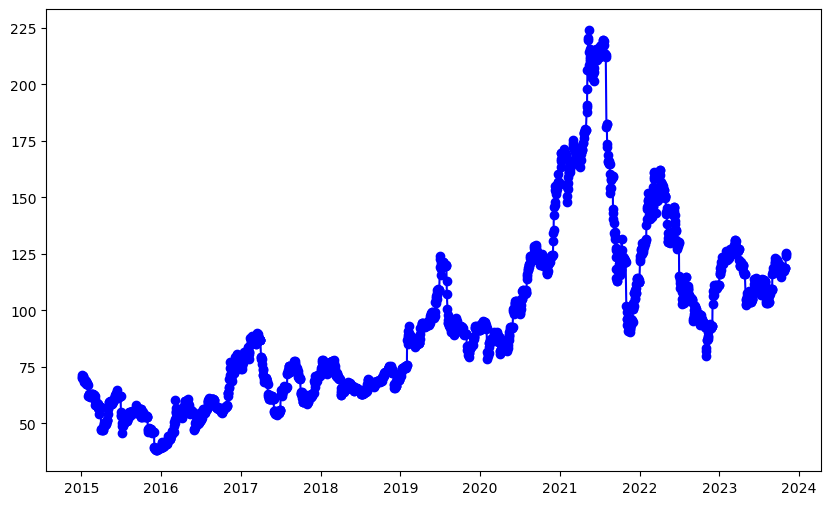

In [101]:
plt.figure(figsize=(10, 6))  
plt.plot(pricing_front['Date'], (pricing_front['CLOSE']), marker='o', linestyle='-', color='blue') 
plt.show()

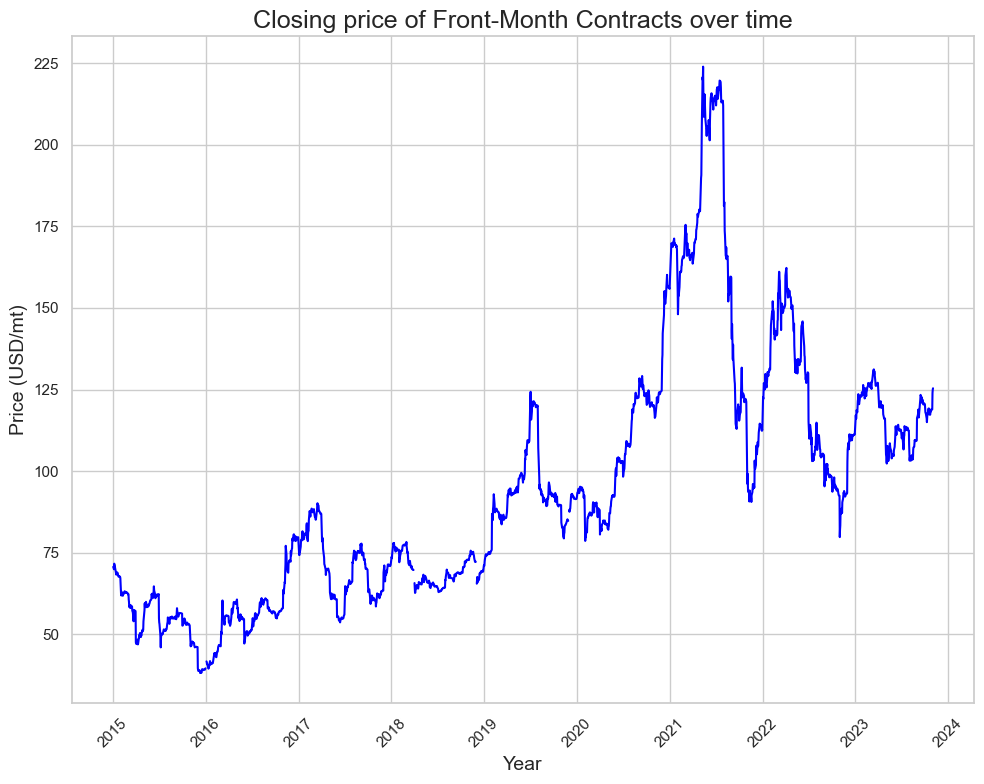

In [102]:
#Plotting front-month closing price time-series

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

plt.plot(pricing_front['Date'], (pricing_front['CLOSE']), linestyle='-', color='blue')

plt.title('Closing price of Front-Month Contracts over time', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price (USD/mt)', fontsize=14)

plt.xticks(rotation=45)

plt.grid(True)

plt.tight_layout()
plt.show()

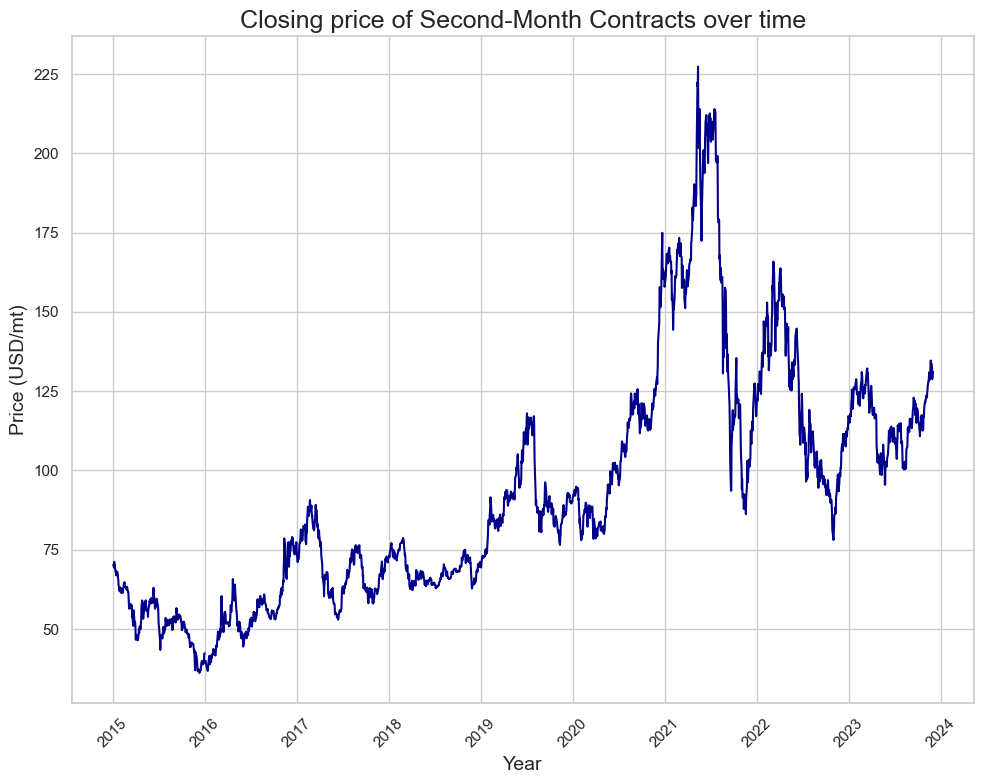

In [104]:
#Plotting second-month closing price time-series

plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

plt.plot(pricing_second['Date'], (pricing_second['CLOSE']), linestyle='-', color='darkblue') 

plt.title('Closing price of Second-Month Contracts over time', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Price (USD/mt)', fontsize=14)

plt.xticks(rotation=45)

plt.grid(True)

plt.tight_layout()
plt.show()

### Rolling Statistics

In [105]:
rolling_stats_front = pricing_front.copy()
rolling_stats_second = pricing_second.copy()

In [106]:
# Calculating moving averages for front-month and second-month contracts
rolling_stats_front['20-day MA'] = rolling_stats_front['CLOSE'].rolling(window=20).mean()
rolling_stats_front['50-day MA'] = rolling_stats_front['CLOSE'].rolling(window=50).mean()

rolling_stats_second['20-day MA'] = rolling_stats_second['CLOSE'].rolling(window=20).mean()
rolling_stats_second['50-day MA'] = rolling_stats_second['CLOSE'].rolling(window=50).mean()

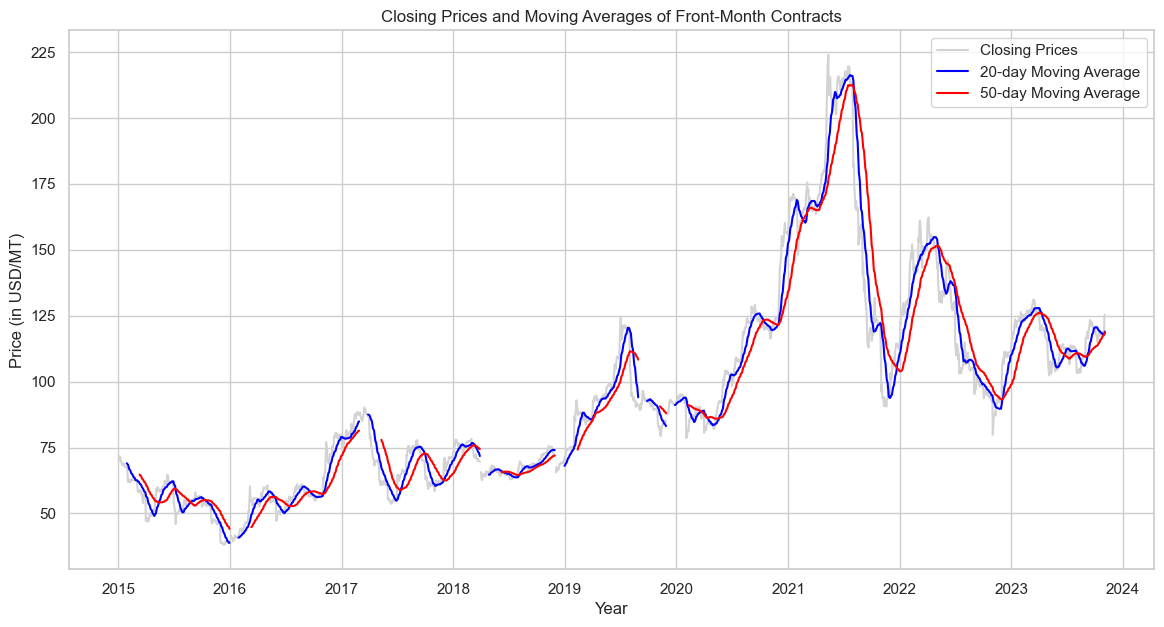

In [107]:
#Plotting closing prices of front-month contracts along with their moving averages

plt.figure(figsize=(14, 7)) 

# Plotting the closing prices and the moving averages
plt.plot(rolling_stats_front['Date'], rolling_stats_front['CLOSE'], label='Closing Prices', color='lightgrey')
plt.plot(rolling_stats_front['Date'], rolling_stats_front['20-day MA'], label='20-day Moving Average', color='blue')
plt.plot(rolling_stats_front['Date'], rolling_stats_front['50-day MA'], label='50-day Moving Average', color='red')


plt.title('Closing Prices and Moving Averages of Front-Month Contracts')
plt.xlabel('Year')
plt.ylabel('Price (in USD/MT)')
plt.legend() 
plt.show()

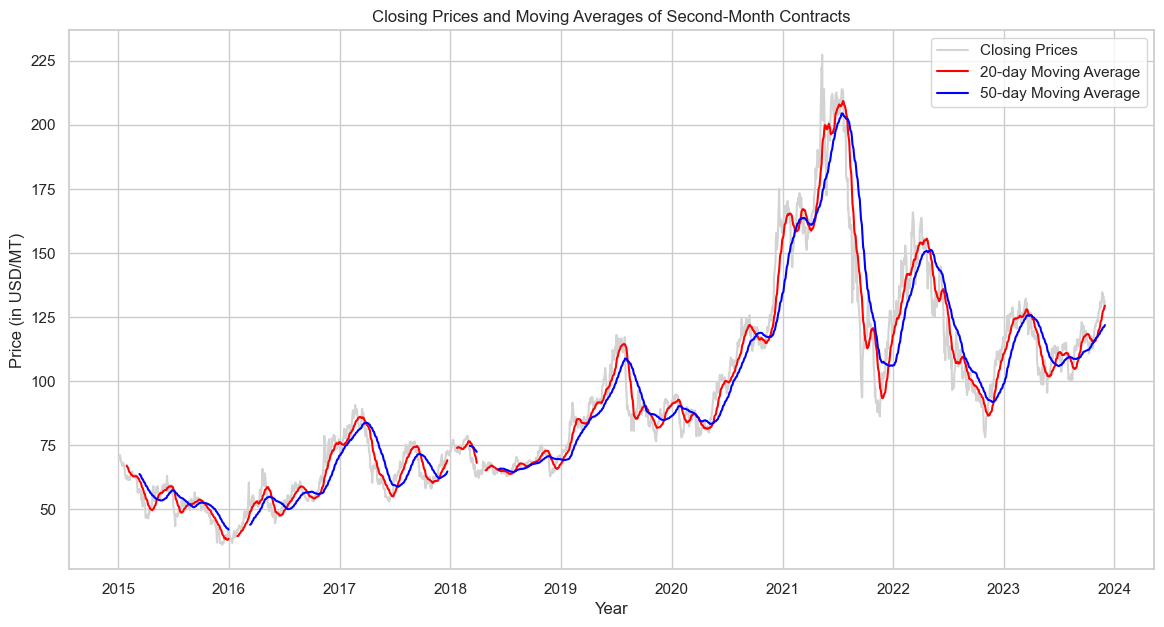

In [108]:
#Plotting closing prices of second-month contracts along with their moving averages

plt.figure(figsize=(14, 7)) 

plt.plot(rolling_stats_second['Date'], rolling_stats_second['CLOSE'], label='Closing Prices', color='lightgray')
plt.plot(rolling_stats_second['Date'], rolling_stats_second['20-day MA'], label='20-day Moving Average', color='red')
plt.plot(rolling_stats_second['Date'], rolling_stats_second['50-day MA'], label='50-day Moving Average', color='blue')

plt.title('Closing Prices and Moving Averages of Second-Month Contracts')
plt.xlabel('Year')
plt.ylabel('Price (in USD/MT)')
plt.legend() 
plt.show()

We can observe that daily close prices are closely tracked by the 20 and 50-day moving averages throughout. This suggests that the short volatility in prices smoothen over time giving way to a reasonably steady long-term trend. Looking at the more recent data towards the right of the chart, the prices seem to be on a continuining upward trend with moving averages lying below but on an upward trajectory. 

### Correlations within Pricing dataset

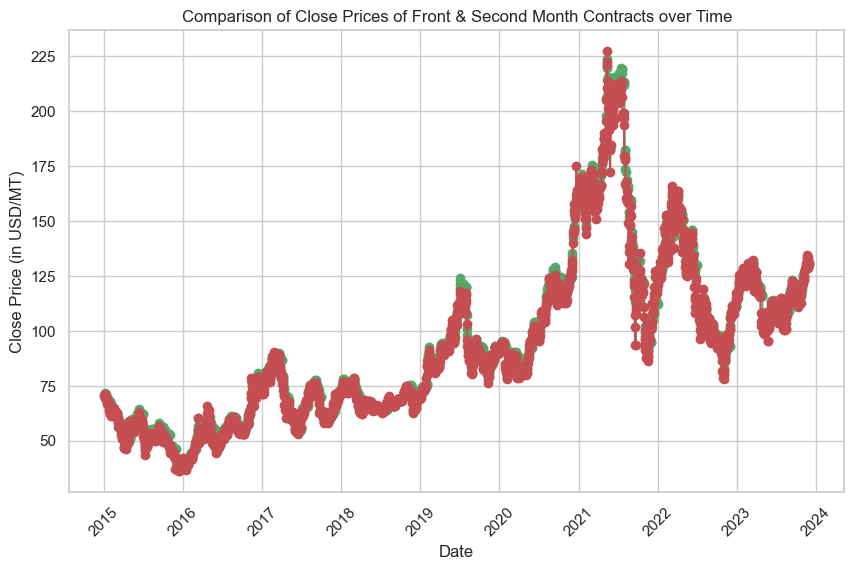

In [109]:
#Plotting the trendline for Close price of front & second month contracts over time 
plt.figure(figsize=(10, 6))  
plt.plot(pricing_front['Date'], (pricing_front['CLOSE']), marker='o', linestyle='-', color='g') 
plt.plot(pricing_second['Date'], (pricing_second['CLOSE']), marker='o', linestyle='-', color='r') 
plt.xlabel('Date')  
plt.ylabel('Close Price (in USD/MT)') 
plt.title('Comparison of Close Prices of Front & Second Month Contracts over Time')  
plt.xticks(rotation=45)  
plt.show()

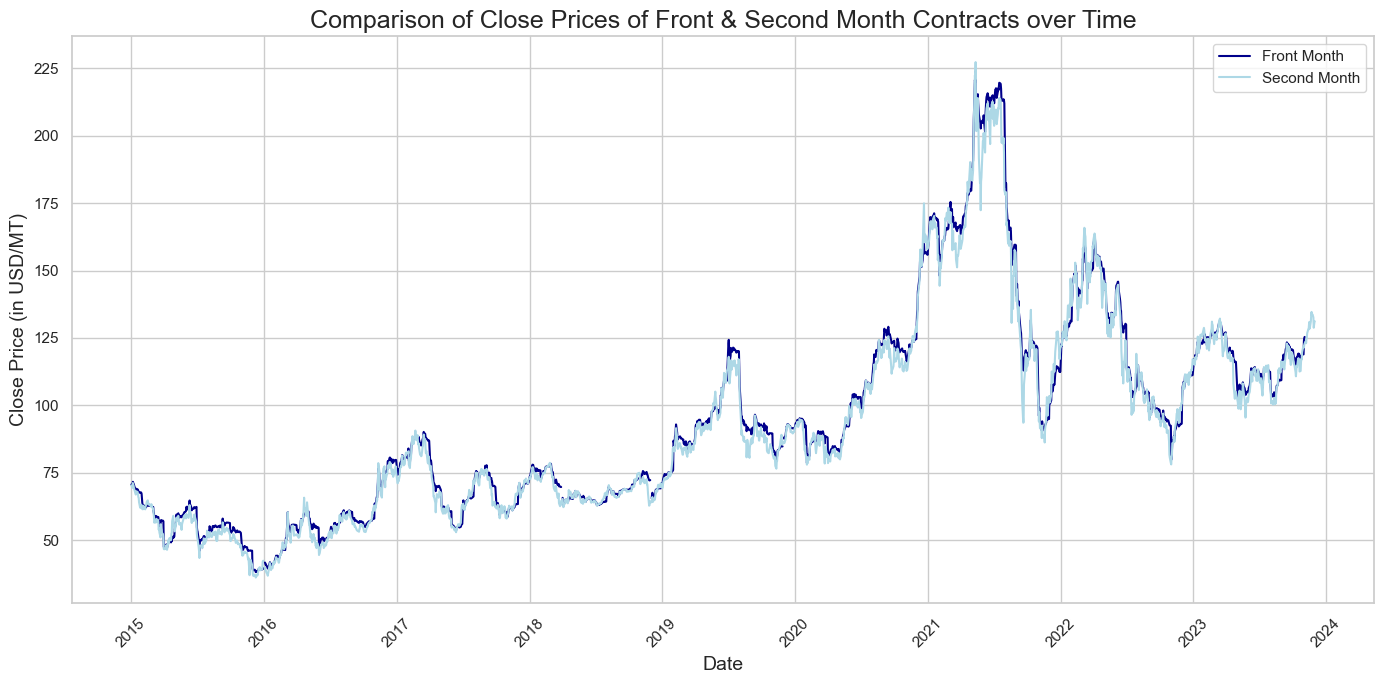

In [110]:
#Visualisation for the report 

# Plotting front-month and second-month contracts over time

plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

plt.plot(pricing_front['Date'], pricing_front['CLOSE'],  linestyle='-', color='darkblue', alpha=1, label='Front Month')
plt.plot(pricing_second['Date'], pricing_second['CLOSE'], linestyle='-', color='lightblue', alpha=1, label='Second Month')

plt.title('Comparison of Close Prices of Front & Second Month Contracts over Time', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price (in USD/MT)', fontsize=14)

plt.legend()

plt.xticks(rotation=45)

plt.grid(True)

plt.tight_layout()
plt.show()

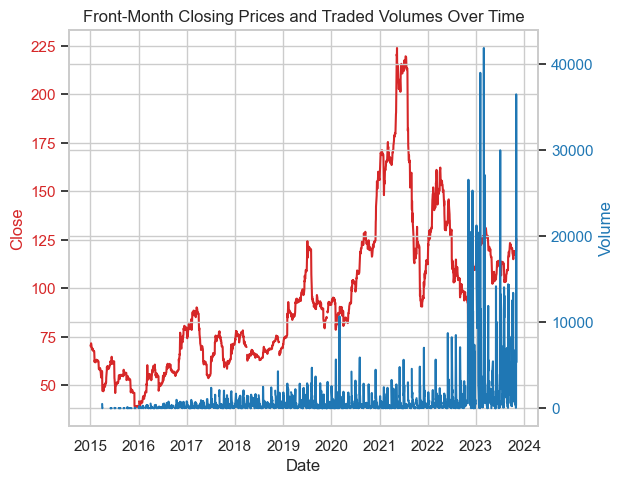

In [111]:
#Plotting the trendline for Close price & Volume of front month contracts over time 

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close', color=color)
ax1.plot(pricing_front['Date'], pricing_front['CLOSE'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Volume', color=color)  
ax2.plot(pricing_front['Date'], pricing_front['VOLUME'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Front-Month Closing Prices and Traded Volumes Over Time')
plt.show()

In [112]:
#Calculating the correlation between Close prices and Volume for front-month contracts 
correlation = round(pricing_front['CLOSE'].corr(pricing_front['VOLUME']), 2)
print("Correlation between closing prices and traded volume for front-month contracts is:", correlation)

Correlation between closing prices and traded volume for front-month contracts is: 0.1


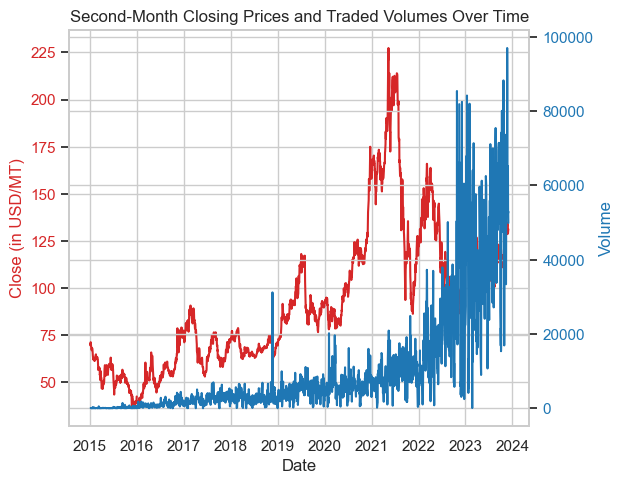

In [113]:
#Plotting the trendline for Close price & Volume of Second month contracts over time 
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close (in USD/MT)', color=color)
ax1.plot(pricing_second['Date'], pricing_second['CLOSE'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Volume', color=color)  
ax2.plot(pricing_second['Date'], pricing_second['VOLUME'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Second-Month Closing Prices and Traded Volumes Over Time')
plt.show()

In [114]:
#Calculating the correlation between Close prices and Volume for second-month contracts 
correlation = round(pricing_second['CLOSE'].corr(pricing_second['VOLUME']), 2)
print("Correlation between closing prices and traded volume for second-month contracts is:", correlation)

Correlation between closing prices and traded volume for second-month contracts is: 0.37


We observe that traded volume has seen a spike in recent years for both types of contracts. There is a greater correlation between observed prices and traded volume for second-month contracts than in the case of front-month contracts. Front-month contract volumes appear to be more volatile than second-month contracts, which show a steady upward trend over time. 

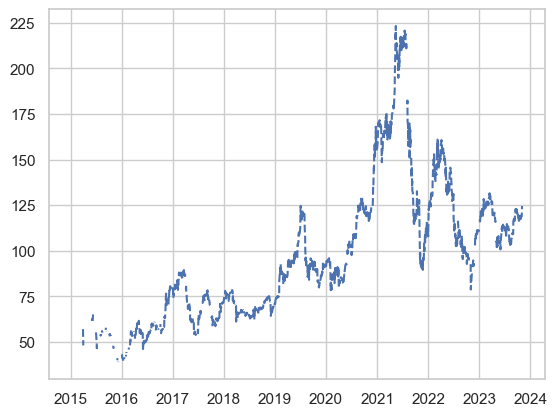

In [115]:
plt.plot(pricing_front['Date'], (pricing_front['OPEN']), linestyle='--', color='b') 
plt.show()

Missing values observed towards the start of the measurement period but in a generally irregular pattern

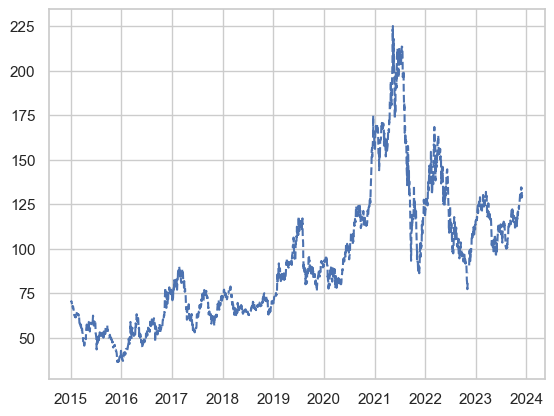

In [116]:
plt.plot(pricing_second['Date'], (pricing_second['OPEN']), linestyle='--', color='b') 
plt.show()

## Stocks dataset <a class="anchor" id="stocks-dataset"></a>

In [117]:
stocks.head()

Date CountrySubArea CountrySubAreaUnit  Quantity
0  2015 01          South             Fujian      1170
1  2015 02          South             Fujian      1200
2  2015 03          South             Fujian      1180
3  2015 04          South             Fujian      1250
4  2015 05          South             Fujian      1310

In [118]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3915 entries, 0 to 3914
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Date                3915 non-null   object
 1   CountrySubArea      3915 non-null   object
 2   CountrySubAreaUnit  3915 non-null   object
 3   Quantity            3915 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.5+ KB


In [119]:
stocks.describe()

Quantity
count   3915.000000
mean   13871.557599
std    13529.461910
min     1060.000000
25%     4075.000000
50%     8260.000000
75%    20370.000000
max    64490.000000

In [120]:
stocks.dtypes

Date                  object
CountrySubArea        object
CountrySubAreaUnit    object
Quantity               int64
dtype: object

In [121]:
stocks['Date'].min()

'2015 01'

In [122]:
stocks['Date'].max()

'2023 17'

In [123]:
stocks.isnull().sum()

Date                  0
CountrySubArea        0
CountrySubAreaUnit    0
Quantity              0
dtype: int64

For stockpiles we have weekly data covering the period of ISO week 1 in 2017 to ISO week 17 in 2023; no missing values to be reported

In [124]:
#Slicing Date column to extract year 

stocks['Year'] = stocks['Date'].str.split(' ').str[0]
stocks['Year']

0       2015
1       2015
2       2015
3       2015
4       2015
        ... 
3910    2023
3911    2023
3912    2023
3913    2023
3914    2023
Name: Year, Length: 3915, dtype: object

In [125]:
stocks['Quantity'] = stocks['Quantity']/1e6

### Analysis of Stocks by Region

In [126]:
stocks_by_region = stocks.groupby(['CountrySubAreaUnit'])['Quantity'].sum().reset_index()

In [127]:
stocks_by_region

CountrySubAreaUnit   Quantity
0                              Fujian   0.947408
1                           Guangdong   1.468732
2                             Guangxi   1.822831
3                               Hebei  13.211427
4                             Jiangsu   8.136799
5                            Liaoning   3.207542
6  Municipalities (Tianjin, Shanghai)   4.272609
7                            Shandong  17.957654
8                            Zhejiang   3.282146

In [128]:
#Sorting df in order of quantities held
stocks_by_region.sort_values(by='Quantity', ascending=False, inplace=True)

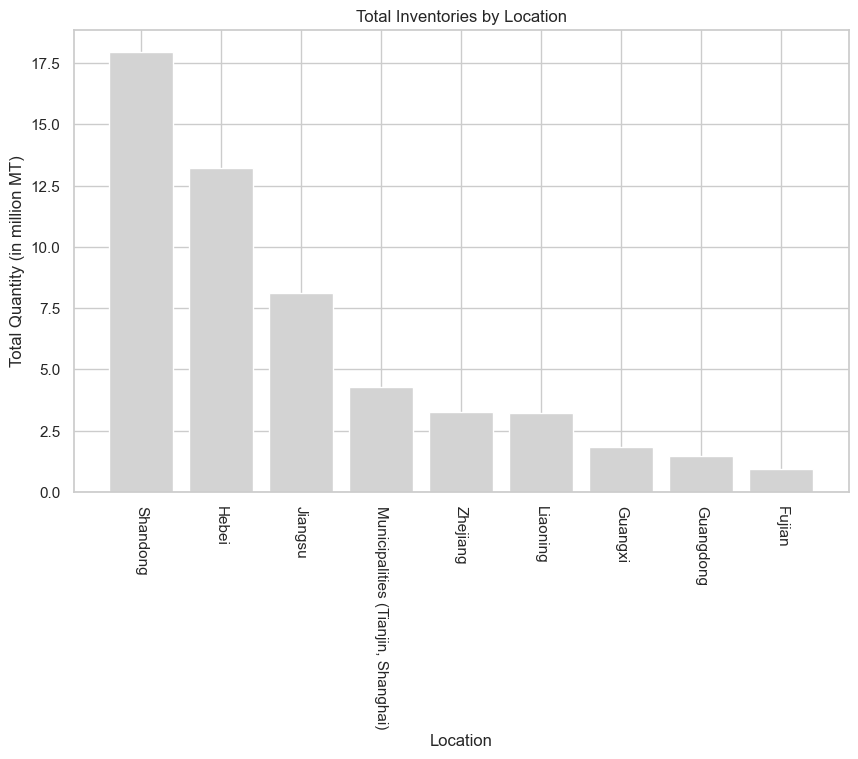

In [129]:
#Plotting bar chart for total inventories by location

plt.figure(figsize=(10, 6))  
plt.bar(stocks_by_region['CountrySubAreaUnit'], stocks_by_region['Quantity'], color='lightgray')
plt.xlabel('Location')  
plt.ylabel('Total Quantity (in million MT)') 
plt.title('Total Inventories by Location')  
plt.xticks(rotation=270)  
plt.show()

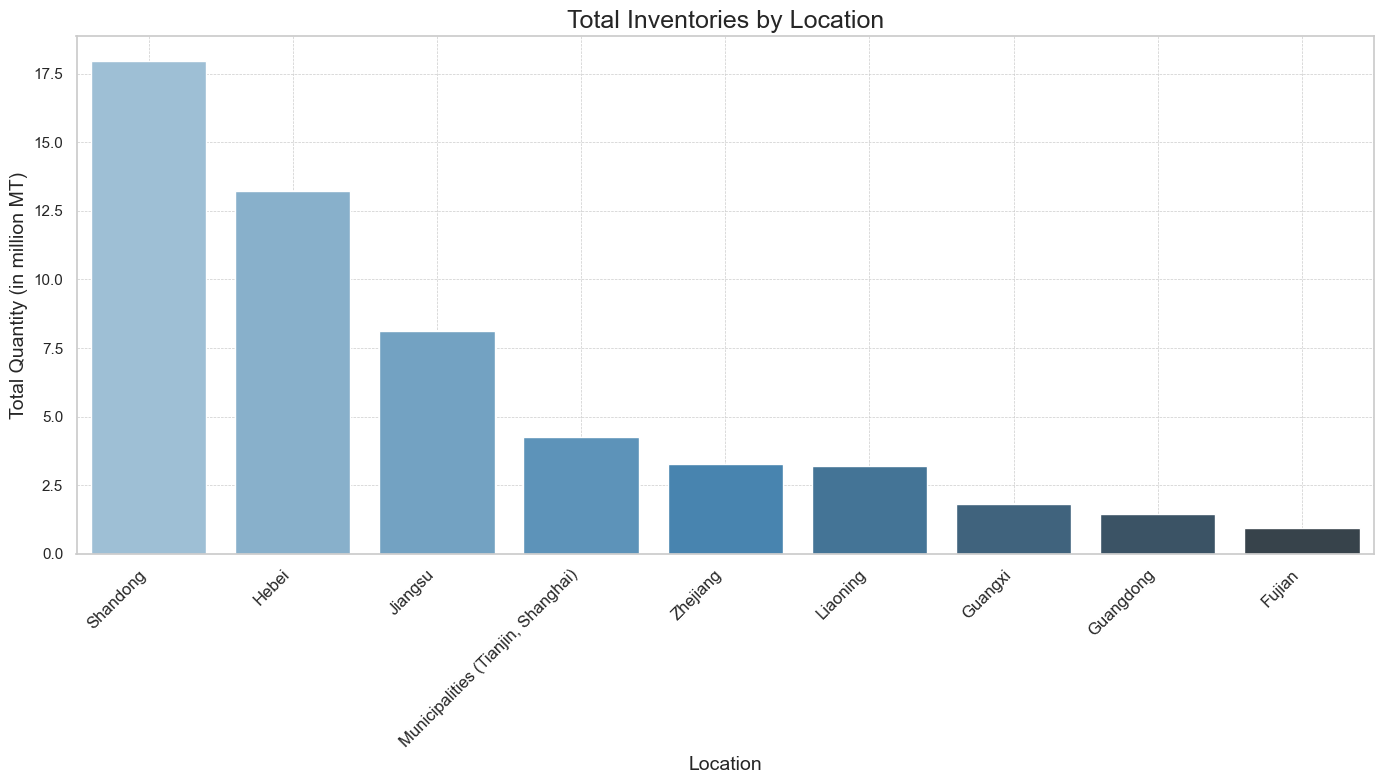

In [464]:
#Plotting total stocks by location

sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))
barplot = sns.barplot(x=stocks_by_region['CountrySubAreaUnit'], y=stocks_by_region['Quantity'], palette="Blues_d")

barplot.set_title('Total Inventories by Location', fontsize=18)
barplot.set_xlabel('Location', fontsize=14)
barplot.set_ylabel('Total Quantity (in million MT)', fontsize=14)

barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [131]:
stocks_by_region['Quantity'].mean()

6.034127555555556

Average inventory held across these locations over the given time period is approximately 6.03 million MT

### Analysis of Inventories by Year

In [132]:
#Grouping data by year and location and sum the quantity
stocks_by_year = stocks.groupby(['Year', 'CountrySubAreaUnit'])['Quantity'].sum().unstack()
stocks_by_year.head()

CountrySubAreaUnit   Fujian  Guangdong  Guangxi    Hebei  Jiangsu  Liaoning  \
Year                                                                          
2015                0.06965    0.14548  0.17968  1.16398  0.71818   0.25782   
2016                0.07326    0.16748  0.21674  1.33440  0.87245   0.24272   
2017                0.08550    0.19138  0.24042  1.79224  1.17390   0.39520   
2018                0.09765    0.21986  0.26296  2.15407  1.14434   0.47874   
2019                0.11588    0.17383  0.23450  1.70855  0.97070   0.45766   

CountrySubAreaUnit  Municipalities (Tianjin, Shanghai)  Shandong  Zhejiang  
Year                                                                        
2015                                           0.43916   1.45093   0.28074  
2016                                           0.49445   1.60588   0.30355  
2017                                           0.56765   2.15693   0.38798  
2018                                           0.57393   2.49132   0.43436  
2019                                           0.49041   2.09091   0.46455

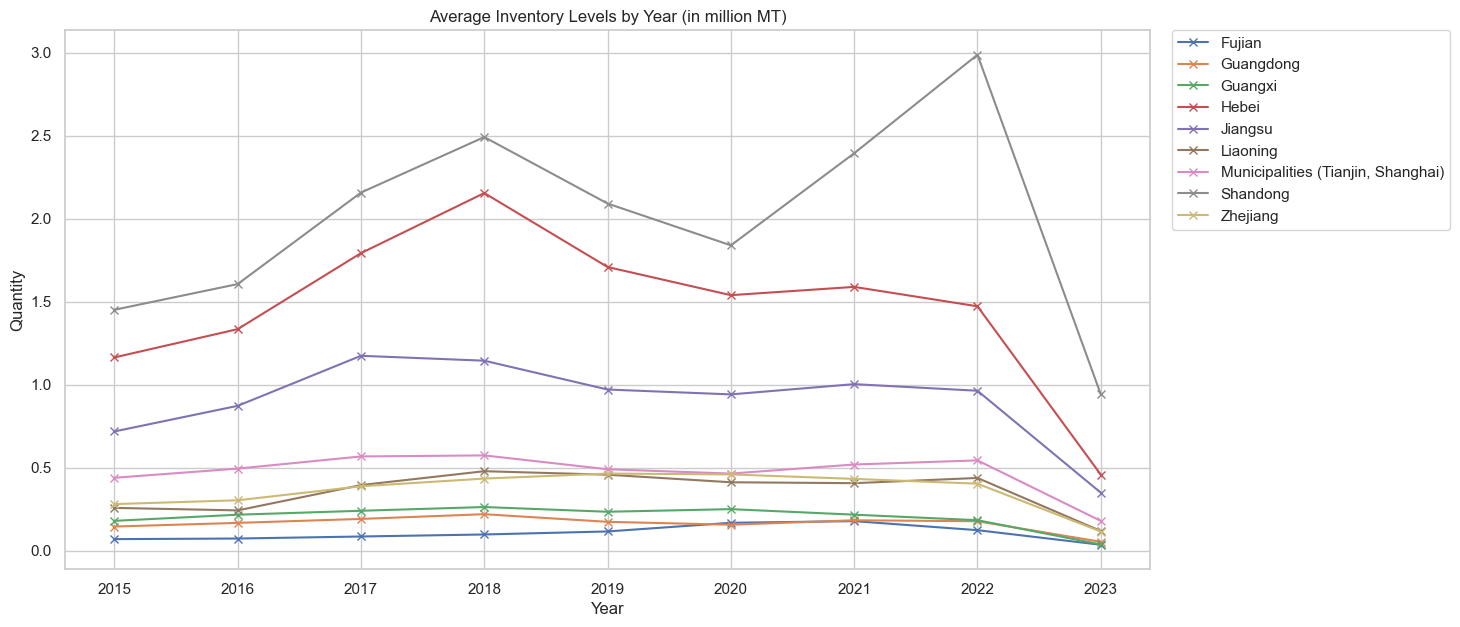

In [133]:
#Plotting inventory levels over time 
stocks_by_year.plot(figsize=(14, 7), marker='x')
plt.title('Average Inventory Levels by Year (in million MT)')
plt.xlabel('Year')
plt.ylabel('Quantity')
plt.grid(True)
plt.legend(title='CountrySubAreaUnit')
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.show()

We see that inventory levels have rapidly declined since 2022 across all locations 

### Inventory-Price Correlation

In [134]:
#Aggregating inventory levels by year
stocks_annual = stocks.groupby(['Year'])['Quantity'].sum()
stocks_annual = stocks_annual.reset_index() #creating df 

In [135]:
#Converting Year to datetime object 
stocks_annual['Year'] = pd.to_datetime(stocks_annual['Year'].astype(str), format='%Y')
stocks_annual

Year  Quantity
0 2015-01-01  4.705620
1 2016-01-01  5.310930
2 2017-01-01  6.991200
3 2018-01-01  7.857230
4 2019-01-01  6.706990
5 2020-01-01  6.230200
6 2021-01-01  6.921870
7 2022-01-01  7.292620
8 2023-01-01  2.290488

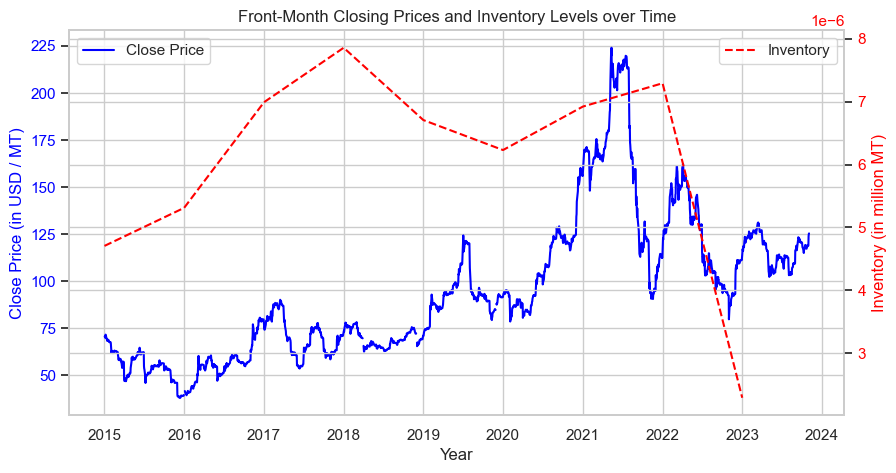

In [136]:
#Plotting inventory levels against closing prices of front-month contracts
plt.figure(figsize=(10, 5))

ax1 = plt.gca()  
ax1.plot(pricing_front['Date'], pricing_front['CLOSE'], label='Close Price', color='blue') 
plt.xlabel('Year')
ax1.set_ylabel('Close Price (in USD / MT)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()  
ax2.plot(stocks_annual['Year'], stocks_annual['Quantity']/1e6, label='Inventory', color='red', linestyle='--')
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Year')
ax2.set_ylabel('Inventory (in million MT)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Front-Month Closing Prices and Inventory Levels over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


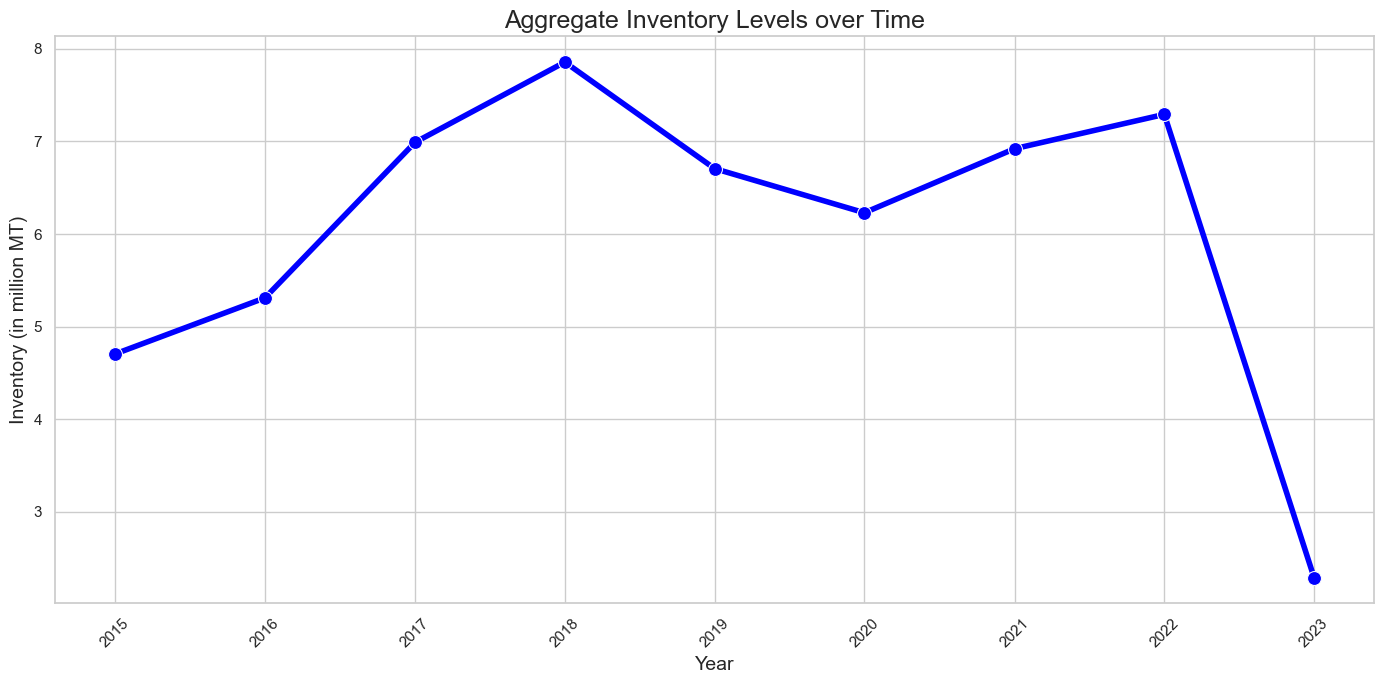

In [137]:
#Plotting average inventory over time

sns.set(style="whitegrid")

plt.figure(figsize=(14, 7))
lineplot = sns.lineplot(data=stocks_annual, x='Year', y='Quantity', marker='o', markersize=10, color='blue', linewidth=4)

lineplot.set_title('Aggregate Inventory Levels over Time', fontsize=18)
lineplot.set_xlabel('Year', fontsize=14)
lineplot.set_ylabel('Inventory (in million MT)', fontsize=14)

plt.xticks(rotation=45)

plt.grid(True)

plt.tight_layout()
plt.show()

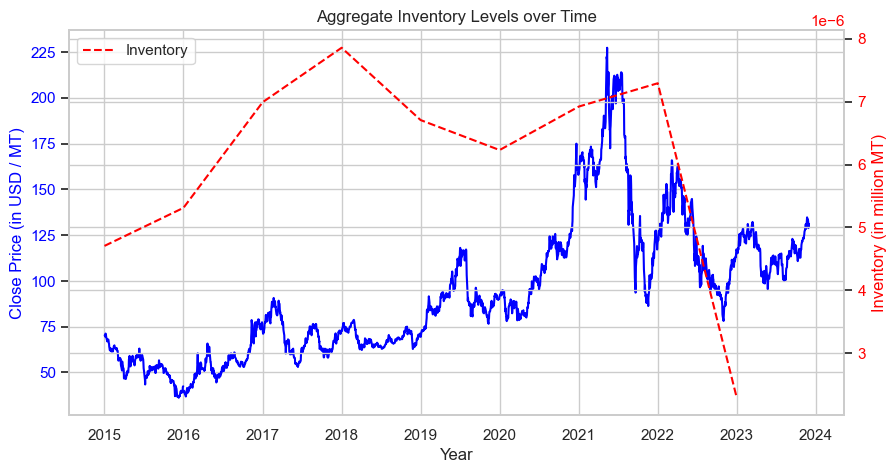

In [138]:
#Plotting inventory levels against closing prices of second-month contracts
plt.figure(figsize=(10, 5))

ax1 = plt.gca()  
ax1.plot(pricing_second['Date'], pricing_second['CLOSE'], label='Close Price', color='blue') 
plt.xlabel('Year')
ax1.set_ylabel('Close Price (in USD / MT)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx() 

ax2.plot(stocks_annual['Year'], stocks_annual['Quantity']/1e6, label='Inventory', color='red', linestyle='--')
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Year')
ax2.set_ylabel('Inventory (in million MT)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Aggregate Inventory Levels over Time')
ax2.legend(loc='upper left')

# Show the plot
plt.show()

In [139]:
#Converting Date to similar format for Stocks dataset 

inventory = stocks.copy() 

inventory.head() #code to check

inventory['Date'] = inventory['Date'].apply(iso_week_to_datetime)

### News Dataset <a class="anchor" id="news-dataset"></a>

In [142]:
#Creating a memory object 
memory_1 = Memory("cachedir", verbose=0)

#Saving data from API call in cache 
@memory_1.cache

# Making the call to URL 
api_key = "b40a6276a6mshe44b45ecebb12e5p13310djsnbc3dcd2a7613"
base_url = "https://reuters-business-and-financial-news.p.rapidapi.com/get-articles-by-keyword-name/iron%20ore"
articles = fetch_articles(api_key, base_url, 0)

In [143]:
articles[-1]

{'articlesId': 460471,
 'articlesName': "Father's shadow looms over Australian billionaire's book launch",
 'articlesShortDescription': "Australian mining magnate Gina Rinehart, one of the world's wealthiest people, has displayed a trait rarely revealed publicly among the super-rich: insecurity.",
 'articlesDescription': '[{"type":"paragraph","content":"SYDNEY Australian mining magnate Gina Rinehart, one of the world&rsquo;s wealthiest people, has displayed a trait rarely revealed publicly among the super-rich: insecurity."},{"type":"paragraph","content":"Rinehart&rsquo;s first book was eagerly awaited by an Australian public enthralled and sometimes appalled by her story of big business, family feuds and almost unimaginable wealth."},{"type":"paragraph","content":"But the 58-year-old widow with a fortune estimated by Forbes at $18 billion, played it safe at the launch of the book, &lsquo;Northern Australia and Then Some: Changes we need to make our country rich&rsquo;."},{"type":"para

In [144]:
#Saving the text data as a CSV file 

fields = articles[0].keys()

#Creating CSV file
with open('news.csv', 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fields)
    writer.writeheader() #Writing the column names as headers
    writer.writerows(articles)  #Writing the data rows

In [145]:
#Reading CSV file in to create pandas dataframe
news = pd.read_csv('./news.csv')

In [146]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11224 entries, 0 to 11223
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   articlesId                11224 non-null  int64  
 1   articlesName              11224 non-null  object 
 2   articlesShortDescription  11223 non-null  object 
 3   articlesDescription       11224 non-null  object 
 4   minutesToRead             11224 non-null  int64  
 5   primaryAssetType          11200 non-null  float64
 6   wordCount                 224 non-null    float64
 7   urlSupplier               11224 non-null  object 
 8   canonicalSupplier         11224 non-null  object 
 9   publishedAt               11224 non-null  object 
 10  dateModified              11224 non-null  object 
 11  files                     11224 non-null  object 
 12  videos                    11224 non-null  object 
 13  tags                      11224 non-null  object 
 14  keywor

In [147]:
news_= news[['publishedAt', 'articlesShortDescription']]
news_.tail() #code to check 

publishedAt  \
11219  {'date': '2013-01-08 14:20:31.000000', 'timezo...   
11220  {'date': '2013-01-08 14:20:31.000000', 'timezo...   
11221  {'date': '2012-11-27 01:20:18.000000', 'timezo...   
11222  {'date': '2012-11-27 01:20:18.000000', 'timezo...   
11223  {'date': '2012-11-27 01:20:18.000000', 'timezo...   

                                articlesShortDescription  
11219  Brazil's tax agency has in recent weeks slappe...  
11220  Brazil's tax agency has in recent weeks slappe...  
11221  Australian mining magnate Gina Rinehart, one o...  
11222  Australian mining magnate Gina Rinehart, one o...  
11223  Australian mining magnate Gina Rinehart, one o...

In [148]:
#Checking data types 
news_.dtypes

publishedAt                 object
articlesShortDescription    object
dtype: object

In [149]:
news_['Date'] = pd.to_datetime(news_['publishedAt'], errors='coerce')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/360104902.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  news_['Date'] = pd.to_datetime(news_['publishedAt'], errors='coerce')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/360104902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_['Date'] = pd.to_datetime(news_['publishedAt'], errors='coerce')


In [150]:
news_.drop('Date', axis=1, inplace=True)

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/4159901782.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_.drop('Date', axis=1, inplace=True)


In [151]:
news_['publishedAt'][0]

"{'date': '2024-04-02 10:36:27.000000', 'timezone_type': 3, 'timezone': 'Europe/Bucharest'}"

We see that the string is a dictionary representation which we shall parse to extract the date information

In [152]:
#Applying to news df 
news_['Date'] = news_['publishedAt'].apply(extract_date)


/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/68725422.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_['Date'] = news_['publishedAt'].apply(extract_date)


In [153]:
news_['Date'] = pd.to_datetime(news_['Date'], errors='coerce')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/2885848983.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_['Date'] = pd.to_datetime(news_['Date'], errors='coerce')


In [154]:
news_.dtypes #code to check

publishedAt                         object
articlesShortDescription            object
Date                        datetime64[ns]
dtype: object

In [155]:
#Dropping extra column
news_.drop('publishedAt', axis=1, inplace=True)

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1402336676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_.drop('publishedAt', axis=1, inplace=True)


In [156]:
#Slicing df by time period 
news_sliced = news_[news_['Date'] > '2014-01-01 00:00:00'] #taking 2014 as the cut-off

In [157]:
news_sliced.iloc[8000,0]

'The price of iron ore traded on the Dalian Commodity Exchange (DCE) rose on Tuesday for the sixth consecutive day and is now at its highest level in three years.'

In [158]:
news_sliced.to_csv('news_text.csv', index=False) #saving as CSV

### --Refer to sentiment analysis notebook for sentiment analysis steps--

In [465]:
#Checking dataset post sentiment analysis

news_sentiment_TB.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11215 entries, 0 to 11215
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   articlesShortDescription  11215 non-null  object        
 1   Date                      11215 non-null  datetime64[ns]
 2   clean_text                11215 non-null  object        
 3   Polarity                  11215 non-null  float64       
 4   Subjectivity              11215 non-null  float64       
 5   Overall Sentiment         11215 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 613.3+ KB


We have news data with a total of 11215 rows 

In [160]:
news_sentiment_TB.describe()

Polarity  Subjectivity
count  11216.000000  11216.000000
mean       0.022408      0.294375
std        0.169785      0.239394
min       -1.000000      0.000000
25%       -0.034462      0.100000
50%        0.000000      0.266667
75%        0.100000      0.450000
max        1.000000      1.000000

In [161]:
news_sentiment_TB.dtypes

articlesShortDescription     object
Date                         object
clean_text                   object
Polarity                    float64
Subjectivity                float64
Overall Sentiment            object
dtype: object

In [162]:
#Converting Date column to datetime object 
news_sentiment_TB['Date'] = pd.to_datetime(news_sentiment_TB['Date'], errors='coerce')

In [163]:
news_sentiment_TB.dtypes #code to check

articlesShortDescription            object
Date                        datetime64[ns]
clean_text                          object
Polarity                           float64
Subjectivity                       float64
Overall Sentiment                   object
dtype: object

In [164]:
news_sentiment_TB.isnull().sum()

articlesShortDescription    1
Date                        0
clean_text                  1
Polarity                    0
Subjectivity                0
Overall Sentiment           0
dtype: int64

In [165]:
#Dropping the row with null value 
news_sentiment_TB.dropna(inplace=True)

In [166]:
news_sentiment_TB.isnull().sum() #code to check

articlesShortDescription    0
Date                        0
clean_text                  0
Polarity                    0
Subjectivity                0
Overall Sentiment           0
dtype: int64

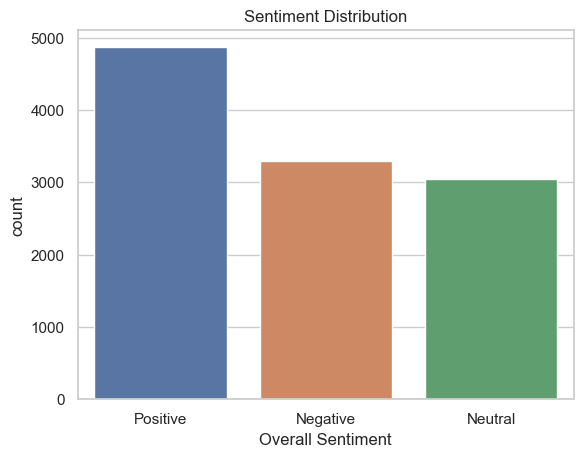

In [167]:
#Plotting distribution of sentiment values

sns.countplot(x='Overall Sentiment', data=news_sentiment_TB)
plt.title('Sentiment Distribution')
plt.show()

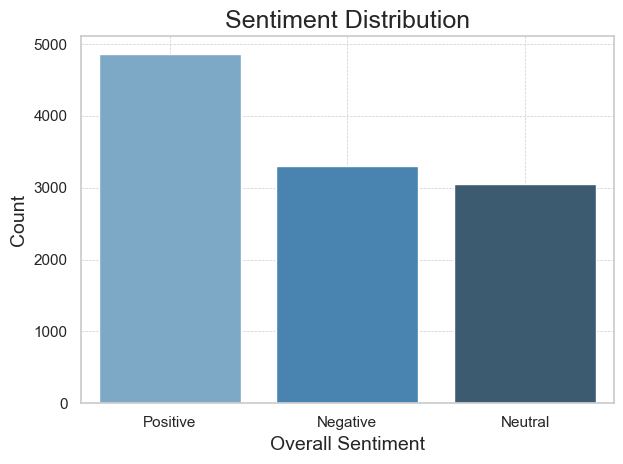

In [168]:
#Plotting count of sentiment classes

sns.set(style="whitegrid")

countplot = sns.countplot(x='Overall Sentiment', data=news_sentiment_TB, palette='Blues_d')

countplot.set_title('Sentiment Distribution', fontsize=18)
countplot.set_xlabel('Overall Sentiment', fontsize=14)
countplot.set_ylabel('Count', fontsize=14)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

In [169]:
news_sentiment_TB['Overall Sentiment'].value_counts() #count of values

Overall Sentiment
Positive    4866
Negative    3299
Neutral     3050
Name: count, dtype: int64

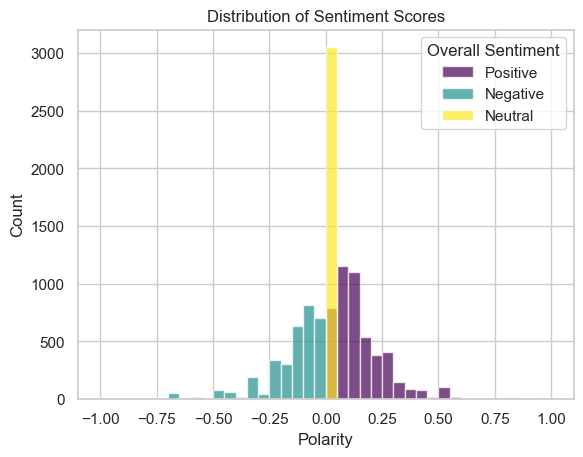

In [170]:
#Plotting distribution of sentiment scores 

labels = news_sentiment_TB['Overall Sentiment'].unique()

colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
color_dict = dict(zip(labels, colors))

fig, ax = plt.subplots()

for label, color in color_dict.items():
    subset = news_sentiment_TB[news_sentiment_TB['Overall Sentiment'] == label]['Polarity']
    ax.hist(subset, bins=20, color=color, alpha=0.7, label=label)
    
    
ax.legend(title='Overall Sentiment')

plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Scores')

plt.show()

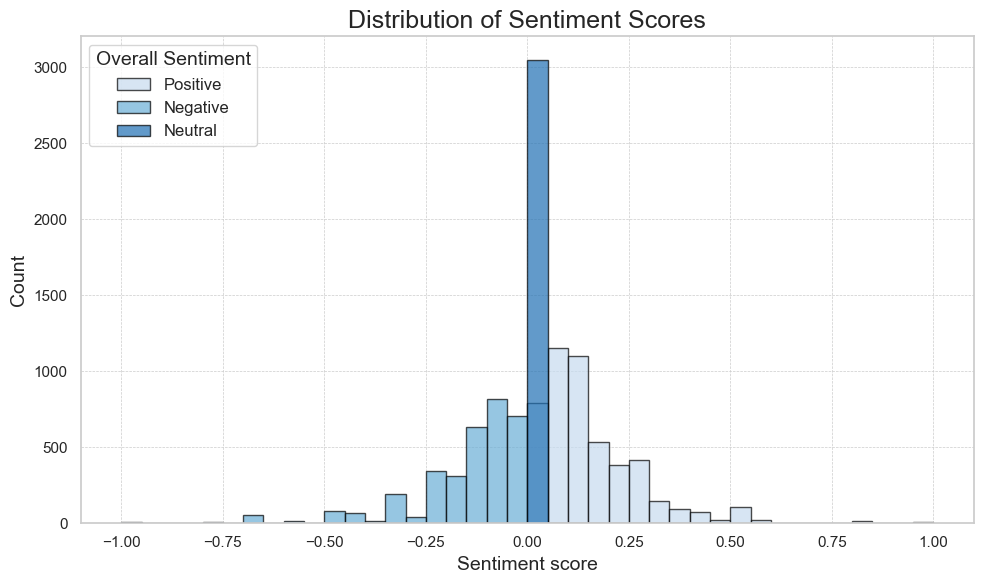

In [171]:
#Revised plot

sns.set(style="whitegrid")

labels = news_sentiment_TB['Overall Sentiment'].unique()
colors = sns.color_palette("Blues", len(labels))
color_dict = dict(zip(labels, colors))

fig, ax = plt.subplots(figsize=(10, 6))

for label, color in color_dict.items():
    subset = news_sentiment_TB[news_sentiment_TB['Overall Sentiment'] == label]['Polarity']
    ax.hist(subset, bins=20, color=color, alpha=0.7, label=label, edgecolor='black')

ax.legend(title='Overall Sentiment', fontsize=12, title_fontsize=14, loc='upper left')

plt.xlabel('Sentiment score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Distribution of Sentiment Scores', fontsize=18)

plt.grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

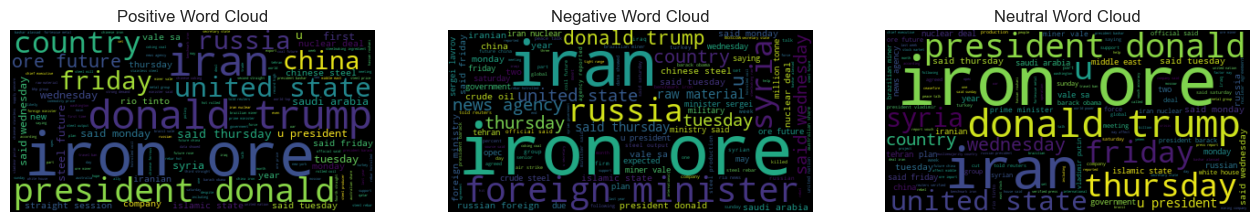

In [172]:
#Plotting wordclouds for positive, negative and neutral texts 

positive_text = ' '.join(news_sentiment_TB[news_sentiment_TB['Overall Sentiment'] == 'Positive']['clean_text'])
negative_text = ' '.join(news_sentiment_TB[news_sentiment_TB['Overall Sentiment'] == 'Negative']['clean_text'])
neutral_text = ' '.join(news_sentiment_TB[news_sentiment_TB['Overall Sentiment'] == 'Neutral']['clean_text'])

wordcloud_pos = WordCloud().generate(positive_text)
wordcloud_neg = WordCloud().generate(negative_text)
wordcloud_neutral = WordCloud().generate(neutral_text)

plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear') #specifying bilinear interpolation for smoothening image
plt.title('Positive Word Cloud')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear') 
plt.title('Negative Word Cloud')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear') 
plt.title('Neutral Word Cloud')
plt.axis('off')


plt.show()

### Data-Merge <a class="anchor" id="data-merge"></a>

Keeping the pricing data as our primary dataset, we will perform the merge using 'Date' as the key. We will explore different join methods and check the associated outcomes. 

In [173]:
#Creating a list of dfs to be merged 

datasets = [pricing_front, pricing_second, fe_flows, inventory, news_sentiment_TB]

#Performing an outer join on the list of datasets

merged_df_outer = reduce(lambda left, right: pd.merge(left, right, on='Date', how='outer'), datasets)

In [174]:
merged_df_outer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175374 entries, 0 to 175373
Data columns (total 68 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Date                           175374 non-null  datetime64[ns]
 1   HIGH_x                         116277 non-null  float64       
 2   LOW_x                          116277 non-null  float64       
 3   OPEN_x                         116277 non-null  float64       
 4   CLOSE_x                        133645 non-null  float64       
 5   VOLUME_x                       117142 non-null  float64       
 6   COUNT_x                        133783 non-null  float64       
 7   RIC_x                          133783 non-null  object        
 8   Description_x                  133783 non-null  object        
 9   Interval_x                     133783 non-null  object        
 10  Currency_x                     133783 non-null  object        
 11  

In [175]:
merged_df_outer.isnull().sum()

Date                             0
HIGH_x                       59097
LOW_x                        59097
OPEN_x                       59097
CLOSE_x                      41729
                             ...  
articlesShortDescription    164159
clean_text                  164159
Polarity                    164159
Subjectivity                164159
Overall Sentiment           164159
Length: 68, dtype: int64

We observe missing values which is expected given the outer join of datasets reporting information at different time frequencies. 

We can now explore a left join to see what effect it has.

In [176]:
# #Performing a left-join 
# merged_df_left = reduce(lambda left, right: pd.merge(left, right, on='Date', how='left'), datasets)

In [177]:
# merged_df_left.info()

In [178]:
# merged_df_left.isnull().sum()

We observe that sentiment data has not merged as a result of the left join therefore we may proceed with the outer join and manipulate the data further from there

In [179]:
#Dropping irrelevant columns  
merged_df = merged_df_outer.copy() 


array_df_columns  = np.array(merged_df.columns)
array_df_columns
merged_df.drop(['IMO', 'CargoTypeID', 'StartTimeOfOperationLoad',  
                    'StartTimeOfOperationDischarge', 'EndTimeOfOperationLoad', 'EndTimeOfOperationDischarge', 
                    'GeoAssetNameLoad', 'AreaNameLevel0Load', 'GeoAssetNameDischarge', 'GeoAssetNameDischarge',
                    'AreaNameLevel0Discharge', 'CargoTaxonomyID', 'L-1CargoTypeID', 'L-1CargoName', 
                    'L0CargoTypeID','L0CargoName', 'L1CargoTypeID', 'L-1CargoName', 'L3CargoTypeID',  
                    'L3CargoName','L4CargoTypeID', 'L4CargoName', 'Year_y', 'clean_text', 'Subjectivity'], axis=1, inplace=True)


## Exploratory Data Analysis <a class="anchor" id="EDA"></a>

In [180]:
merged_df.info() #code to check 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175374 entries, 0 to 175373
Data columns (total 45 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Date                      175374 non-null  datetime64[ns]
 1   HIGH_x                    116277 non-null  float64       
 2   LOW_x                     116277 non-null  float64       
 3   OPEN_x                    116277 non-null  float64       
 4   CLOSE_x                   133645 non-null  float64       
 5   VOLUME_x                  117142 non-null  float64       
 6   COUNT_x                   133783 non-null  float64       
 7   RIC_x                     133783 non-null  object        
 8   Description_x             133783 non-null  object        
 9   Interval_x                133783 non-null  object        
 10  Currency_x                133783 non-null  object        
 11  FriendlyName_x            133783 non-null  object        
 12  HI

In [181]:
#Renaming columns to better differentiate between them 
merged_df.rename(columns={'Quantity_x':'Flows_Volume', 'Year_x': 'Year', 'Quantity_y': 'Stock_Volume'}, inplace=True)

In [182]:
#Adding columns for imports to the merged df 

merged_df['china_imports'] = merged_df.apply(lambda row: row['Flows_Volume'] if row['CountryNameDischarge'] == 'China' else 0, axis=1)
merged_df['row_imports'] = merged_df.apply(lambda row: row['Flows_Volume'] if row['CountryNameDischarge'] != 'China' else 0, axis=1)

In [183]:
#Adding columns for exports to the merged df 

merged_df['aus_exports'] = merged_df.apply(lambda row: row['Flows_Volume'] if row['CountryNameLoad'] == 'Australia' else 0, axis=1)
merged_df['brazil_exports'] = merged_df.apply(lambda row: row['Flows_Volume'] if row['CountryNameLoad'] == 'Brazil' else 0, axis=1)

#Creating list 
export_majors = ['Australia', 'Brazil']

#Adding another column for ROW exports
merged_df['row_exports'] = merged_df.apply(lambda row: row['Flows_Volume'] if row['CountryNameLoad'] not in export_majors else 0, axis=1)

In [184]:
merged_df.columns

Index(['Date', 'HIGH_x', 'LOW_x', 'OPEN_x', 'CLOSE_x', 'VOLUME_x', 'COUNT_x',
       'RIC_x', 'Description_x', 'Interval_x', 'Currency_x', 'FriendlyName_x',
       'HIGH_y', 'LOW_y', 'OPEN_y', 'CLOSE_y', 'VOLUME_y', 'COUNT_y', 'RIC_y',
       'Description_y', 'Interval_y', 'Currency_y', 'FriendlyName_y',
       'VoyageNumber', 'ArrivalDateLoad', 'SailingDateLoad',
       'ArrivalDateDischarge', 'SailingDateDischarge', 'Flows_Volume',
       'PortNameLoad', 'CountryNameLoad', 'PortNameDischarge',
       'CountryNameDischarge', 'CargoType', 'CargoName', 'L1CargoName',
       'L2CargoTypeID', 'L2CargoName', 'Year', 'CountrySubArea',
       'CountrySubAreaUnit', 'Stock_Volume', 'articlesShortDescription',
       'Polarity', 'Overall Sentiment', 'china_imports', 'row_imports',
       'aus_exports', 'brazil_exports', 'row_exports'],
      dtype='object')

In [185]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175374 entries, 0 to 175373
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Date                      175374 non-null  datetime64[ns]
 1   HIGH_x                    116277 non-null  float64       
 2   LOW_x                     116277 non-null  float64       
 3   OPEN_x                    116277 non-null  float64       
 4   CLOSE_x                   133645 non-null  float64       
 5   VOLUME_x                  117142 non-null  float64       
 6   COUNT_x                   133783 non-null  float64       
 7   RIC_x                     133783 non-null  object        
 8   Description_x             133783 non-null  object        
 9   Interval_x                133783 non-null  object        
 10  Currency_x                133783 non-null  object        
 11  FriendlyName_x            133783 non-null  object        
 12  HI

We now have a total of 50 data columns in the merged dataset with separate columns for the data relating to front and second month contract types

In [186]:
merged_df.describe() #summary stats

Date         HIGH_x          LOW_x  \
count                         175374  116277.000000  116277.000000   
mean   2019-10-03 13:07:20.371748608     106.113566     103.788158   
min              2014-01-24 14:22:19      38.900000      38.900000   
25%              2017-07-10 00:00:00      74.000000      72.800000   
50%              2020-01-06 00:00:00      98.200000      95.450000   
75%              2021-12-02 00:00:00     125.890000     123.400000   
max              2025-05-14 00:00:00     226.850000     220.050000   
std                              NaN      40.328544      39.001276   

              OPEN_x        CLOSE_x       VOLUME_x   COUNT_x         HIGH_y  \
count  116277.000000  133645.000000  117142.000000  133783.0  132815.000000   
mean      104.963068      99.808808    1090.383808      -1.0     100.315634   
min        38.900000      38.150000       1.000000      -1.0      36.440000   
25%        73.270000      67.080000      55.000000      -1.0      67.750000   
50%        96.000000      92.580000     217.000000      -1.0      92.730000   
75%       125.000000     122.540000     724.000000      -1.0     122.750000   
max       223.300000     223.940000   41824.000000      -1.0     233.750000   
std        39.718640      40.493905    3189.213611       0.0      40.514278   

               LOW_y         OPEN_y  ...   Flows_Volume  L2CargoTypeID  \
count  132815.000000  132815.000000  ...  164159.000000       164159.0   
mean       96.422567      98.342274  ...  101142.611286         5258.0   
min        36.040000      36.350000  ...      12.736000         5258.0   
25%        65.790000      66.780000  ...   49871.116000         5258.0   
50%        89.450000      90.600000  ...   84799.885000         5258.0   
75%       118.750000     121.000000  ...  148000.000000         5258.0   
max       217.200000     225.050000  ...  395207.698000         5258.0   
std        38.299619      39.463917  ...   68197.263421            0.0   

                Year  Stock_Volume      Polarity  china_imports  \
count  164159.000000  92673.000000  11215.000000  175374.000000   
mean     2019.312709      0.014020      0.022410   72161.670059   
min      2014.000000      0.001060     -1.000000       0.000000   
25%      2017.000000      0.004050     -0.034549       0.000000   
50%      2020.000000      0.008270      0.000000   56405.702000   
75%      2021.000000      0.020240      0.100000  103667.887750   
max      2024.000000      0.064490      1.000000  393501.000000   
std         2.570792      0.013765      0.169792   69891.106885   

         row_imports    aus_exports  brazil_exports    row_exports  
count  164159.000000  175374.000000   175374.000000  164159.000000  
mean    24051.006653   70189.466820    16106.675972    8950.896266  
min         0.000000       0.000000        0.000000       0.000000  
25%         0.000000       0.000000        0.000000       0.000000  
50%         0.000000   55180.481500        0.000000       0.000000  
75%         0.000000  101672.200250        0.000000       0.000000  
max    395207.698000  264858.000000   395207.698000  392871.000000  
std     59335.686402   67307.076915    57384.843020   30043.086333  

[8 rows x 28 columns]

In [187]:
merged_df.dtypes

Date                        datetime64[ns]
HIGH_x                             float64
LOW_x                              float64
OPEN_x                             float64
CLOSE_x                            float64
VOLUME_x                           float64
COUNT_x                            float64
RIC_x                               object
Description_x                       object
Interval_x                          object
Currency_x                          object
FriendlyName_x                      object
HIGH_y                             float64
LOW_y                              float64
OPEN_y                             float64
CLOSE_y                            float64
VOLUME_y                           float64
COUNT_y                            float64
RIC_y                               object
Description_y                       object
Interval_y                          object
Currency_y                          object
FriendlyName_y                      object
VoyageNumbe

In [188]:
merged_df.isna().sum()

Date                             0
HIGH_x                       59097
LOW_x                        59097
OPEN_x                       59097
CLOSE_x                      41729
VOLUME_x                     58232
COUNT_x                      41591
RIC_x                        41591
Description_x                41591
Interval_x                   41591
Currency_x                   41591
FriendlyName_x               41591
HIGH_y                       42559
LOW_y                        42559
OPEN_y                       42559
CLOSE_y                      41117
VOLUME_y                     42582
COUNT_y                      40839
RIC_y                        40839
Description_y                40839
Interval_y                   40839
Currency_y                   40839
FriendlyName_y               40839
VoyageNumber                 11215
ArrivalDateLoad              11215
SailingDateLoad              11215
ArrivalDateDischarge         11215
SailingDateDischarge         11215
Flows_Volume        

In [189]:
#Summary for select columns of interest 

select_columns = ['Date','OPEN_x', 'CLOSE_x', 'OPEN_y', 'CLOSE_y', 
                  'Flows_Volume', 'Stock_Volume', 'Polarity','china_imports', 'row_imports', 'aus_exports', 
                 'brazil_exports', 'row_exports']
summary_df = merged_df[select_columns]

summary_df.describe()

Date         OPEN_x        CLOSE_x  \
count                         175374  116277.000000  133645.000000   
mean   2019-10-03 13:07:20.371748608     104.963068      99.808808   
min              2014-01-24 14:22:19      38.900000      38.150000   
25%              2017-07-10 00:00:00      73.270000      67.080000   
50%              2020-01-06 00:00:00      96.000000      92.580000   
75%              2021-12-02 00:00:00     125.000000     122.540000   
max              2025-05-14 00:00:00     223.300000     223.940000   
std                              NaN      39.718640      40.493905   

              OPEN_y       CLOSE_y   Flows_Volume  Stock_Volume      Polarity  \
count  132815.000000  134257.00000  164159.000000  92673.000000  11215.000000   
mean       98.342274      97.98043  101142.611286      0.014020      0.022410   
min        36.350000      36.13000      12.736000      0.001060     -1.000000   
25%        66.780000      66.02000   49871.116000      0.004050     -0.034549   
50%        90.600000      90.66000   84799.885000      0.008270      0.000000   
75%       121.000000     120.18000  148000.000000      0.020240      0.100000   
max       225.050000     227.34000  395207.698000      0.064490      1.000000   
std        39.463917      39.63629   68197.263421      0.013765      0.169792   

       china_imports    row_imports    aus_exports  brazil_exports  \
count  175374.000000  164159.000000  175374.000000   175374.000000   
mean    72161.670059   24051.006653   70189.466820    16106.675972   
min         0.000000       0.000000       0.000000        0.000000   
25%         0.000000       0.000000       0.000000        0.000000   
50%     56405.702000       0.000000   55180.481500        0.000000   
75%    103667.887750       0.000000  101672.200250        0.000000   
max    393501.000000  395207.698000  264858.000000   395207.698000   
std     69891.106885   59335.686402   67307.076915    57384.843020   

         row_exports  
count  164159.000000  
mean     8950.896266  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         0.000000  
max    392871.000000  
std     30043.086333

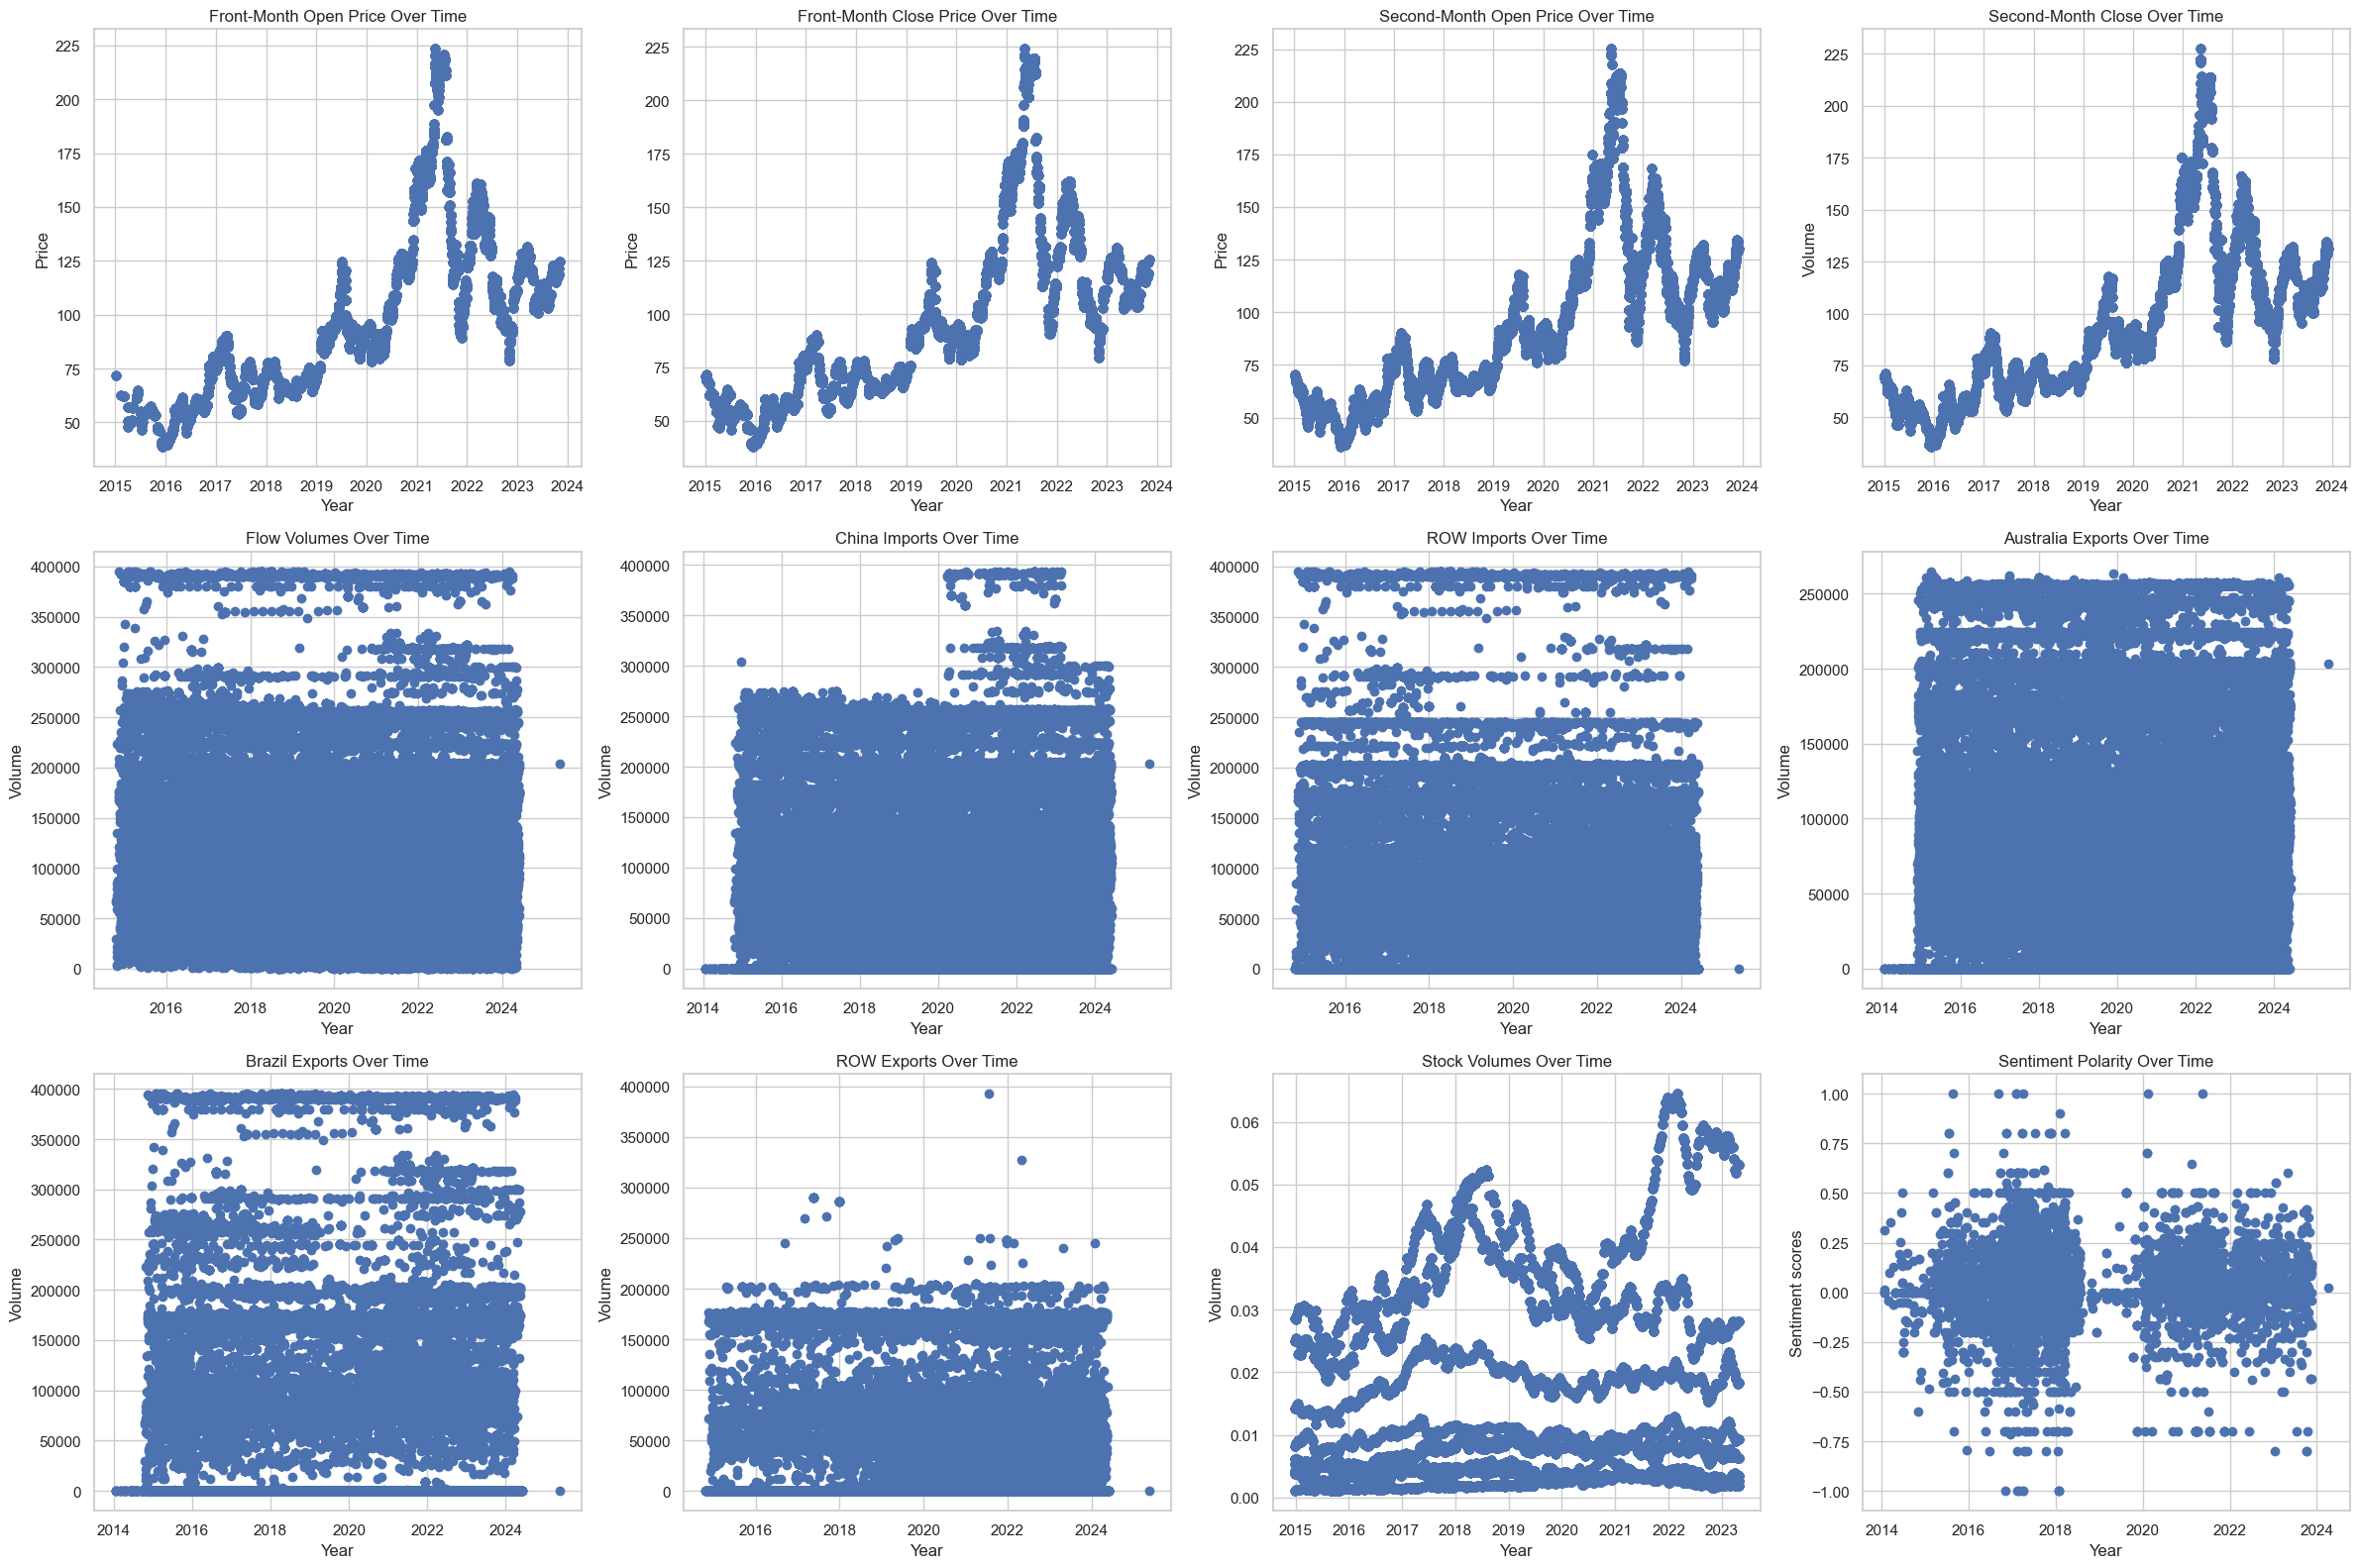

In [190]:
#Visualisation for the report

#Time-series of different data columns


# Defining the figure and subplots
fig, axs = plt.subplots(3, 4, figsize=(24, 16))  

# Plotting Front Month Open price over time
axs[0, 0].scatter(summary_df['Date'], summary_df['OPEN_x'])
axs[0, 0].set_title('Front-Month Open Price Over Time')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Price')

# Plotting Front Month  price over time
axs[0, 1].scatter(summary_df['Date'], summary_df['CLOSE_x'])
axs[0, 1].set_title('Front-Month Close Price Over Time')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Price')


# Plotting Second Month Open price over time
axs[0, 2].scatter(summary_df['Date'], summary_df['OPEN_y'])
axs[0, 2].set_title('Second-Month Open Price Over Time')
axs[0, 2].set_xlabel('Year')
axs[0, 2].set_ylabel('Price')

# Plotting Second Month price over time
axs[0, 3].scatter(summary_df['Date'], summary_df['CLOSE_y'])
axs[0, 3].set_title('Second-Month Close Over Time')
axs[0, 3].set_xlabel('Year')
axs[0, 3].set_ylabel('Volume')

# Plotting Flows Volumes over time
axs[1, 0].scatter(summary_df['Date'], summary_df['Flows_Volume'])
axs[1, 0].set_title('Flow Volumes Over Time')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Volume')

# Plotting China Imports over time
axs[1, 1].scatter(summary_df['Date'], summary_df['china_imports'])
axs[1, 1].set_title('China Imports Over Time')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Volume')

# Plotting ROW Imports over time
axs[1, 2].scatter(summary_df['Date'], summary_df['row_imports'])
axs[1, 2].set_title('ROW Imports Over Time')
axs[1, 2].set_xlabel('Year')
axs[1, 2].set_ylabel('Volume')

# Plotting Australia Exports over time
axs[1, 3].scatter(summary_df['Date'], summary_df['aus_exports'])
axs[1, 3].set_title('Australia Exports Over Time')
axs[1, 3].set_xlabel('Year')
axs[1, 3].set_ylabel('Volume')

# Plotting Brazil Exports over time
axs[2, 0].scatter(summary_df['Date'], summary_df['brazil_exports'])
axs[2, 0].set_title('Brazil Exports Over Time')
axs[2, 0].set_xlabel('Year')
axs[2, 0].set_ylabel('Volume')

# Plotting ROW Exports over time
axs[2, 1].scatter(summary_df['Date'], summary_df['row_exports'])
axs[2, 1].set_title('ROW Exports Over Time')
axs[2, 1].set_xlabel('Year')
axs[2, 1].set_ylabel('Volume')

# Plotting Stock Volumes over time
axs[2, 2].scatter(summary_df['Date'], summary_df['Stock_Volume'])
axs[2, 2].set_title('Stock Volumes Over Time')
axs[2, 2].set_xlabel('Year')
axs[2, 2].set_ylabel('Volume')

# Plotting Sentiment scores over time
axs[2, 3].scatter(summary_df['Date'], summary_df['Polarity'])
axs[2, 3].set_title('Sentiment Polarity Over Time')
axs[2, 3].set_xlabel('Year')
axs[2, 3].set_ylabel('Sentiment scores')


plt.tight_layout()

plt.show()

We observe that the opening and close prices have followed a general upward trend over time. Market sentiment shows a random distribution with a high concentration of sentiment scores between 0.25 and -0.25. The stock and flow volumes are non-descript as these represent multiple entries related to the same point in time. The trend related to these columns will be better understood upon pre-processing. 

In [191]:
#Calculating correlation coefficient between different attributes 
df_numeric = merged_df.select_dtypes(include=[np.number]) #assigning all numeric variables in df to new variable 
corr_matrix = df_numeric.corr()

We observe NaN for Polarity as the data column contains missing values for certain dates which will be handled subsequently during pre-processing.

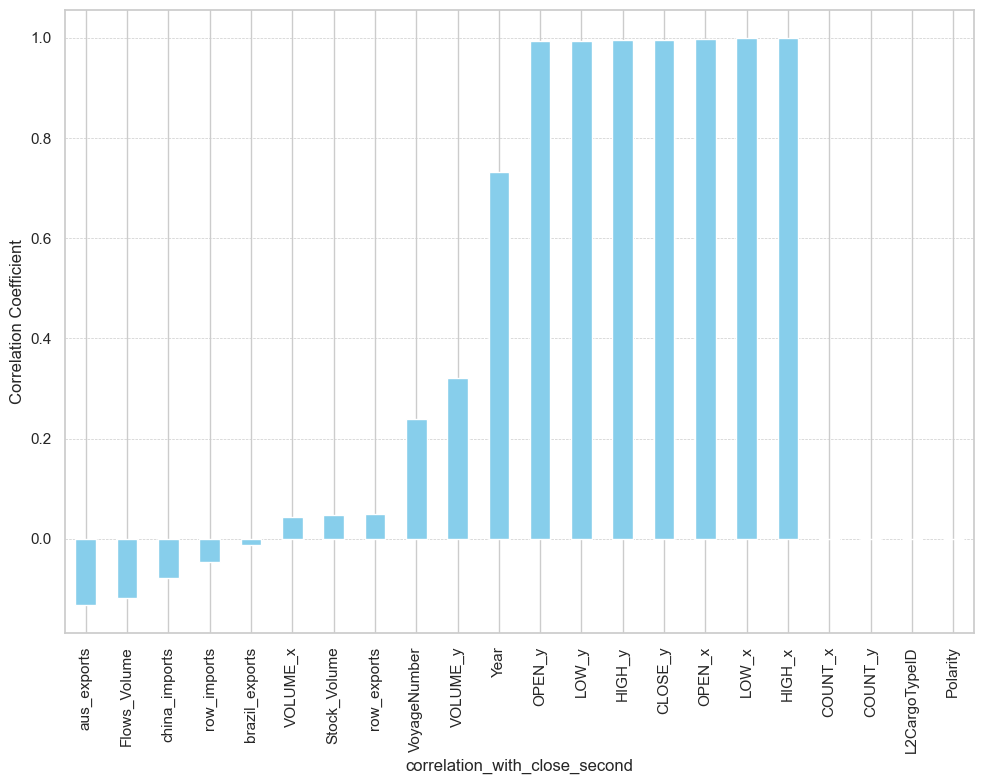

In [192]:
#Plotting the correlation coefficient against Close prices of front-month contracts

correlation_with_close_front = corr_matrix['CLOSE_x'].drop('CLOSE_x', errors='ignore').sort_values()

plt.figure(figsize=(10, 8))
correlation_with_close_front.plot(kind='bar', color='skyblue')
plt.xlabel('correlation_with_close_second')
plt.ylabel('Correlation Coefficient')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


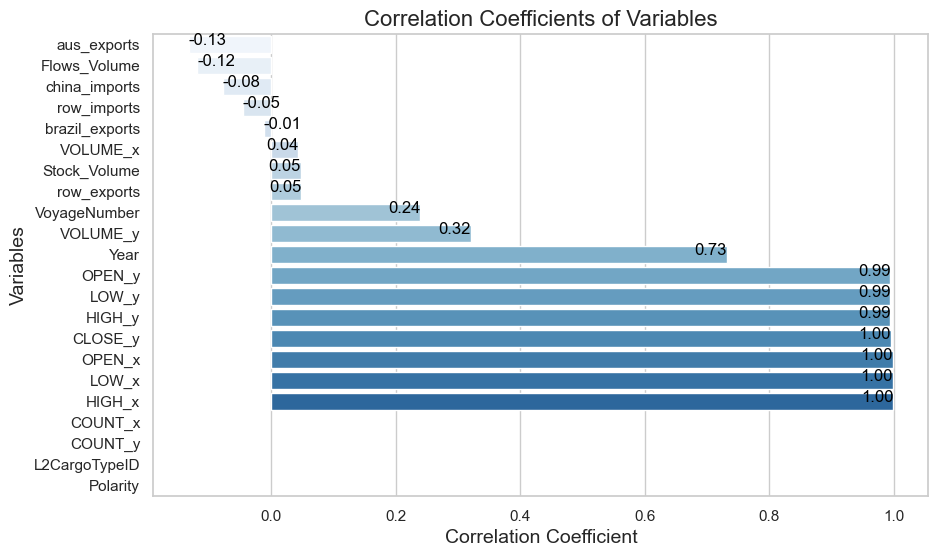

In [193]:
#Visualisation for the report

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=correlation_with_close_front.values, y=correlation_with_close_front.index, palette='Blues', orient='h')
bar_plot.set_title('Correlation Coefficients of Variables', fontsize=16)
bar_plot.set_xlabel('Correlation Coefficient', fontsize=14)
bar_plot.set_ylabel('Variables', fontsize=14)

for index, value in enumerate(correlation_with_close_front.values):
    bar_plot.text(value, index, f'{value:.2f}', color='black', ha="left" if value < 0 else "right")

In [194]:
#Repeating correlation analysis for close prices of second month contracts

corr_matrix['CLOSE_y']

HIGH_x            0.993365
LOW_x             0.993341
OPEN_x            0.991897
CLOSE_x           0.995100
VOLUME_x          0.051206
COUNT_x                NaN
HIGH_y            0.998408
LOW_y             0.998749
OPEN_y            0.996596
CLOSE_y           1.000000
VOLUME_y          0.327336
COUNT_y                NaN
VoyageNumber      0.242983
Flows_Volume     -0.118450
L2CargoTypeID          NaN
Year              0.739811
Stock_Volume      0.051355
Polarity               NaN
china_imports    -0.077281
row_imports      -0.045780
aus_exports      -0.132691
brazil_exports   -0.011309
row_exports       0.048803
Name: CLOSE_y, dtype: float64

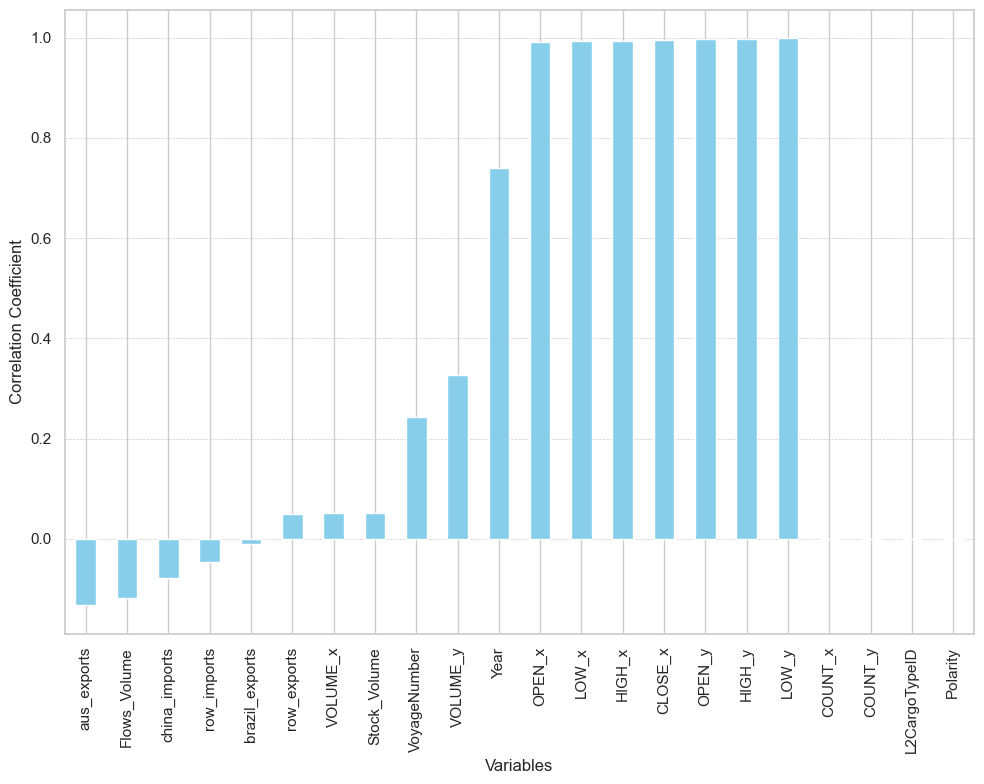

In [195]:
correlation_with_close_second = corr_matrix['CLOSE_y'].drop('CLOSE_y', errors='ignore').sort_values()

plt.figure(figsize=(10, 8))
correlation_with_close_second.plot(kind='bar', color='skyblue')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


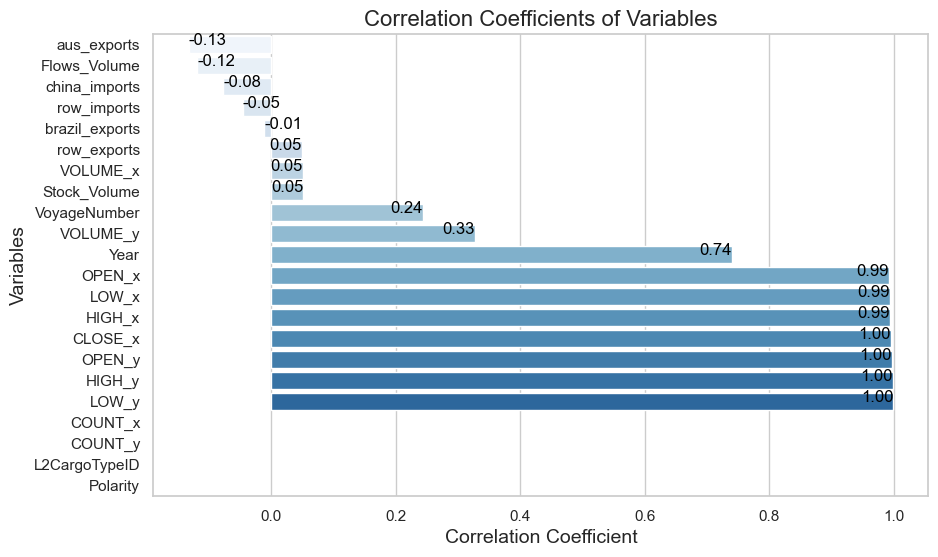

In [196]:
#Visualisation for the report

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=correlation_with_close_second.values, y=correlation_with_close_second.index, palette='Blues', orient='h')
bar_plot.set_title('Correlation Coefficients of Variables', fontsize=16)
bar_plot.set_xlabel('Correlation Coefficient', fontsize=14)
bar_plot.set_ylabel('Variables', fontsize=14)

for index, value in enumerate(correlation_with_close_second.values):
    bar_plot.text(value, index, f'{value:.2f}', color='black', ha="left" if value < 0 else "right")

Notably in the case of both front and second month contracts, close price seems to have a negative correlation with overall flows, exports from majors and imports from China and ROW

# Data Cleaning  <a class="anchor" id="data-cleaning"></a>

### Slicing Data Time-Frame 

In [197]:
#Slicing df to create a data range for the merged df

start_date = pricing_front['Date'].min() 
end_date = pricing_front['Date'].max()


merged_df = merged_df[(merged_df['Date'] >= start_date) & (merged_df['Date'] <= end_date)]

In [198]:
merged_df.columns

Index(['Date', 'HIGH_x', 'LOW_x', 'OPEN_x', 'CLOSE_x', 'VOLUME_x', 'COUNT_x',
       'RIC_x', 'Description_x', 'Interval_x', 'Currency_x', 'FriendlyName_x',
       'HIGH_y', 'LOW_y', 'OPEN_y', 'CLOSE_y', 'VOLUME_y', 'COUNT_y', 'RIC_y',
       'Description_y', 'Interval_y', 'Currency_y', 'FriendlyName_y',
       'VoyageNumber', 'ArrivalDateLoad', 'SailingDateLoad',
       'ArrivalDateDischarge', 'SailingDateDischarge', 'Flows_Volume',
       'PortNameLoad', 'CountryNameLoad', 'PortNameDischarge',
       'CountryNameDischarge', 'CargoType', 'CargoName', 'L1CargoName',
       'L2CargoTypeID', 'L2CargoName', 'Year', 'CountrySubArea',
       'CountrySubAreaUnit', 'Stock_Volume', 'articlesShortDescription',
       'Polarity', 'Overall Sentiment', 'china_imports', 'row_imports',
       'aus_exports', 'brazil_exports', 'row_exports'],
      dtype='object')

In [199]:
merged_df.head()

Date  HIGH_x  LOW_x  OPEN_x  CLOSE_x  VOLUME_x  COUNT_x   RIC_x  \
745 2015-01-02     NaN    NaN     NaN    70.67       NaN     -1.0  SZZFc1   
746 2015-01-02     NaN    NaN     NaN    70.67       NaN     -1.0  SZZFc1   
747 2015-01-02     NaN    NaN     NaN    70.67       NaN     -1.0  SZZFc1   
748 2015-01-02     NaN    NaN     NaN    70.67       NaN     -1.0  SZZFc1   
749 2015-01-02     NaN    NaN     NaN    70.67       NaN     -1.0  SZZFc1   

                                         Description_x Interval_x  ...  \
745  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
746  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
747  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
748  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
749  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   

    CountrySubAreaUnit Stock_Volume  articlesShortDescription  Polarity  \
745                NaN          NaN                       NaN       NaN   
746                NaN          NaN                       NaN       NaN   
747                NaN          NaN                       NaN       NaN   
748                NaN          NaN                       NaN       NaN   
749                NaN          NaN                       NaN       NaN   

     Overall Sentiment  china_imports  row_imports  aus_exports  \
745                NaN      89771.833        0.000    89771.833   
746                NaN          0.000    94058.302    94058.302   
747                NaN     114077.461        0.000   114077.461   
748                NaN          0.000   202072.269   202072.269   
749                NaN      24325.575        0.000    24325.575   

    brazil_exports row_exports  
745            0.0         0.0  
746            0.0         0.0  
747            0.0         0.0  
748            0.0         0.0  
749            0.0         0.0  

[5 rows x 50 columns]

### Front-month and second-month split

In [200]:
#Separating the feature and label sets with front-month close as target variable 
X_front = merged_df.drop(columns={'CLOSE_x'})
y_front = merged_df[['Date','CLOSE_x']]

In [201]:
#Separating the feature and label sets with second-month close as target variable 
X_second = merged_df.drop(columns={'CLOSE_y'})
y_second = merged_df[['Date','CLOSE_y']]

## Train-Test Split  <a class="anchor" id="train-test"></a>

In [203]:
#Splitting X into training and testing sets
split_level = round(len(X_front)*.9) #setting up for 90-10 train-test split
X_train_front = X_front[:split_level] #selecting older data for training 
X_test_front = X_front[split_level:]  #selecting more recent data for testing 

#Splitting y into training and testing sets
split_level = round(len(y_front)*.9) #setting up for 90-10 train-test split
y_train_front = y_front[:split_level] #selecting older data for training while keeping gap between train and test 
y_test_front = y_front[split_level:]

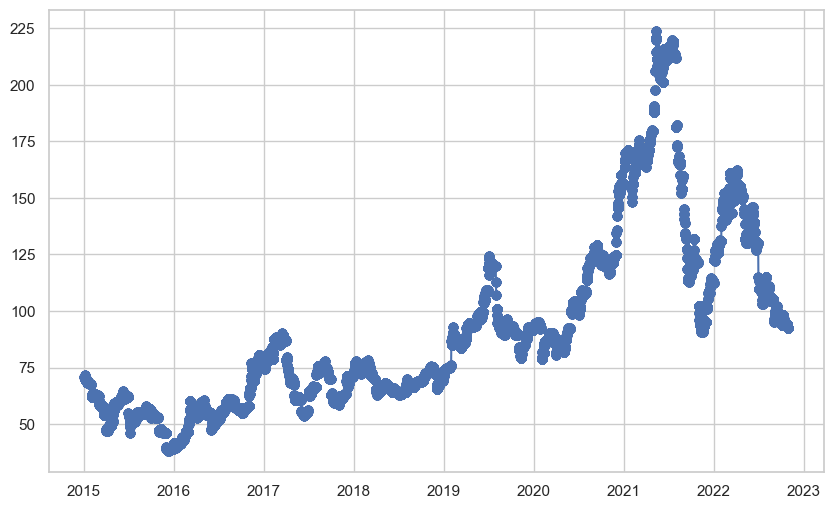

In [204]:
plt.figure(figsize=(10, 6))  
plt.plot(y_train_front['Date'], (y_train_front['CLOSE_x']), marker='o', linestyle='-', color='b') 
plt.show()

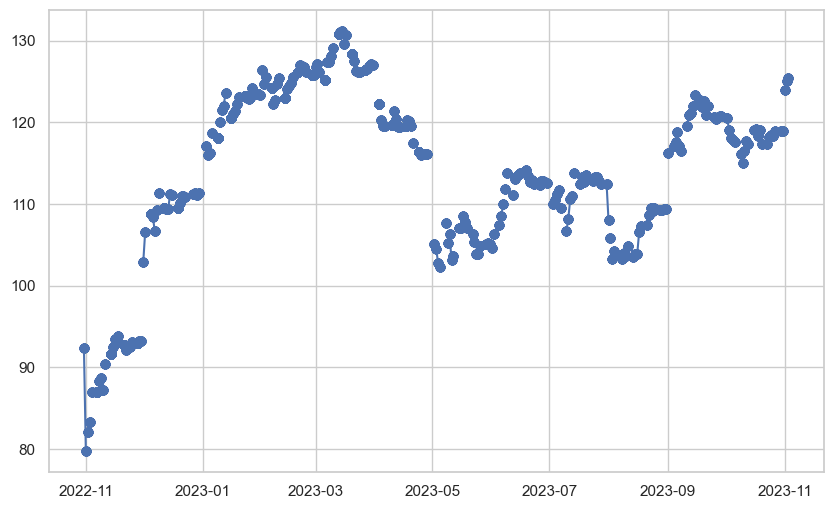

In [205]:
plt.figure(figsize=(10, 6))  
plt.plot(y_test_front['Date'], (y_test_front['CLOSE_x']), marker='o', linestyle='-', color='b') 
plt.show()

In [206]:
X_test_front.notnull().sum()

Date                        16965
HIGH_x                      12883
LOW_x                       12883
OPEN_x                      12883
VOLUME_x                    12883
COUNT_x                     13079
RIC_x                       13079
Description_x               13079
Interval_x                  13079
Currency_x                  13079
FriendlyName_x              13079
HIGH_y                      12927
LOW_y                       12927
OPEN_y                      12927
CLOSE_y                     13079
VOLUME_y                    12927
COUNT_y                     13079
RIC_y                       13079
Description_y               13079
Interval_y                  13079
Currency_y                  13079
FriendlyName_y              13079
VoyageNumber                16470
ArrivalDateLoad             16470
SailingDateLoad             16470
ArrivalDateDischarge        16470
SailingDateDischarge        16470
Flows_Volume                16470
PortNameLoad                16470
CountryNameLoa

In [207]:
y_test_front.notnull().sum()

Date       16965
CLOSE_x    13079
dtype: int64

In [209]:
#Splitting X into training and testing sets
split_level = round(len(X_second)*.9) #setting up for 90-10 train-test split
X_train_second = X_second[:split_level] #selecting older data for training 
X_test_second = X_second[split_level:]  #selecting more recent data for testing 

#Splitting y into training and testing sets
split_level = round(len(y_second)*.9) #setting up for 90-10 train-test split
y_train_second = y_second[:split_level] #selecting older data for training 
y_test_second = y_second[split_level:]

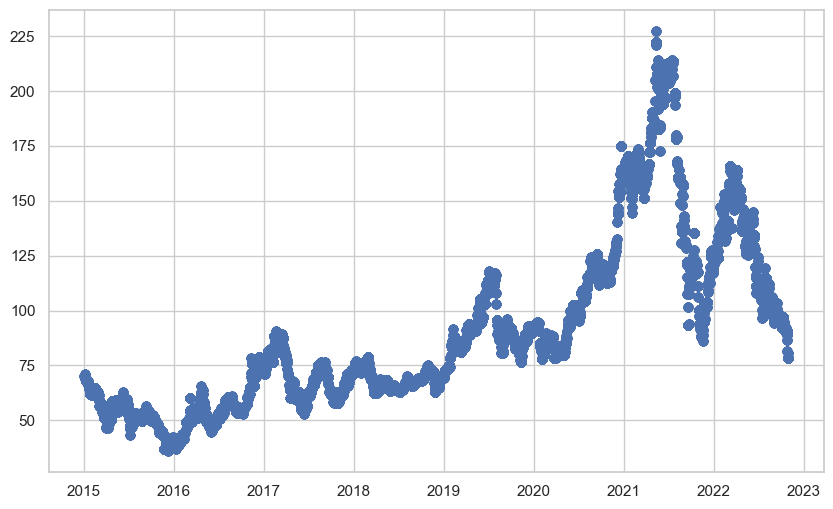

In [210]:
plt.figure(figsize=(10, 6))  
plt.plot(y_train_second['Date'], (y_train_second['CLOSE_y']), marker='o', linestyle='-', color='b') 
plt.show()

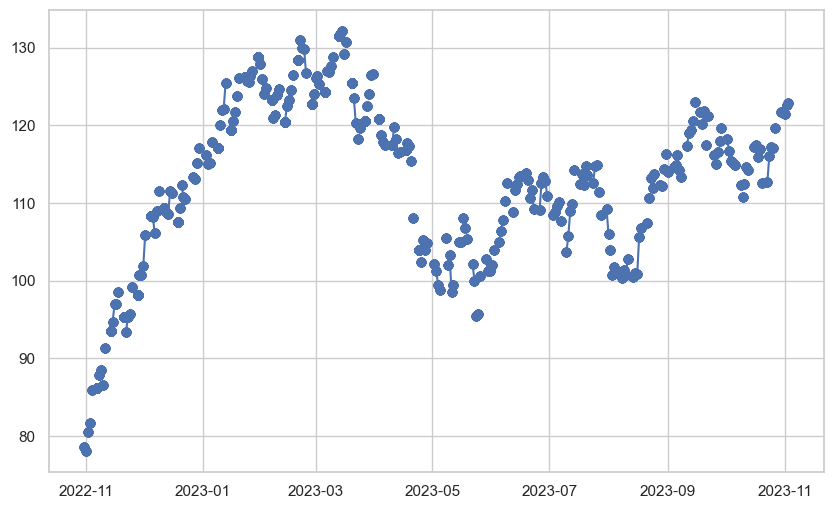

In [211]:
plt.figure(figsize=(10, 6))  
plt.plot(y_test_second['Date'], (y_test_second['CLOSE_y']), marker='o', linestyle='-', color='b') 
plt.show()

In [212]:
X_train_front.columns

Index(['Date', 'HIGH_x', 'LOW_x', 'OPEN_x', 'VOLUME_x', 'COUNT_x', 'RIC_x',
       'Description_x', 'Interval_x', 'Currency_x', 'FriendlyName_x', 'HIGH_y',
       'LOW_y', 'OPEN_y', 'CLOSE_y', 'VOLUME_y', 'COUNT_y', 'RIC_y',
       'Description_y', 'Interval_y', 'Currency_y', 'FriendlyName_y',
       'VoyageNumber', 'ArrivalDateLoad', 'SailingDateLoad',
       'ArrivalDateDischarge', 'SailingDateDischarge', 'Flows_Volume',
       'PortNameLoad', 'CountryNameLoad', 'PortNameDischarge',
       'CountryNameDischarge', 'CargoType', 'CargoName', 'L1CargoName',
       'L2CargoTypeID', 'L2CargoName', 'Year', 'CountrySubArea',
       'CountrySubAreaUnit', 'Stock_Volume', 'articlesShortDescription',
       'Polarity', 'Overall Sentiment', 'china_imports', 'row_imports',
       'aus_exports', 'brazil_exports', 'row_exports'],
      dtype='object')

In [213]:
X_train_front.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152689 entries, 745 to 153433
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Date                      152689 non-null  datetime64[ns]
 1   HIGH_x                    103394 non-null  float64       
 2   LOW_x                     103394 non-null  float64       
 3   OPEN_x                    103394 non-null  float64       
 4   VOLUME_x                  104259 non-null  float64       
 5   COUNT_x                   120704 non-null  float64       
 6   RIC_x                     120704 non-null  object        
 7   Description_x             120704 non-null  object        
 8   Interval_x                120704 non-null  object        
 9   Currency_x                120704 non-null  object        
 10  FriendlyName_x            120704 non-null  object        
 11  HIGH_y                    119370 non-null  float64       
 12  LOW_y

In [214]:
X_test_front.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16965 entries, 153434 to 170398
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      16965 non-null  datetime64[ns]
 1   HIGH_x                    12883 non-null  float64       
 2   LOW_x                     12883 non-null  float64       
 3   OPEN_x                    12883 non-null  float64       
 4   VOLUME_x                  12883 non-null  float64       
 5   COUNT_x                   13079 non-null  float64       
 6   RIC_x                     13079 non-null  object        
 7   Description_x             13079 non-null  object        
 8   Interval_x                13079 non-null  object        
 9   Currency_x                13079 non-null  object        
 10  FriendlyName_x            13079 non-null  object        
 11  HIGH_y                    12927 non-null  float64       
 12  LOW_y            

In [215]:
y_train_front.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152689 entries, 745 to 153433
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Date     152689 non-null  datetime64[ns]
 1   CLOSE_x  120566 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.5 MB


In [216]:
y_test_front.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16965 entries, 153434 to 170398
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     16965 non-null  datetime64[ns]
 1   CLOSE_x  13079 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 397.6 KB


In [217]:
X_train_second.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152689 entries, 745 to 153433
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Date                      152689 non-null  datetime64[ns]
 1   HIGH_x                    103394 non-null  float64       
 2   LOW_x                     103394 non-null  float64       
 3   OPEN_x                    103394 non-null  float64       
 4   CLOSE_x                   120566 non-null  float64       
 5   VOLUME_x                  104259 non-null  float64       
 6   COUNT_x                   120704 non-null  float64       
 7   RIC_x                     120704 non-null  object        
 8   Description_x             120704 non-null  object        
 9   Interval_x                120704 non-null  object        
 10  Currency_x                120704 non-null  object        
 11  FriendlyName_x            120704 non-null  object        
 12  HIGH_

In [218]:
X_test_second.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16965 entries, 153434 to 170398
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      16965 non-null  datetime64[ns]
 1   HIGH_x                    12883 non-null  float64       
 2   LOW_x                     12883 non-null  float64       
 3   OPEN_x                    12883 non-null  float64       
 4   CLOSE_x                   13079 non-null  float64       
 5   VOLUME_x                  12883 non-null  float64       
 6   COUNT_x                   13079 non-null  float64       
 7   RIC_x                     13079 non-null  object        
 8   Description_x             13079 non-null  object        
 9   Interval_x                13079 non-null  object        
 10  Currency_x                13079 non-null  object        
 11  FriendlyName_x            13079 non-null  object        
 12  HIGH_y           

In [219]:
y_train_second.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152689 entries, 745 to 153433
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Date     152689 non-null  datetime64[ns]
 1   CLOSE_y  120660 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.5 MB


In [220]:
y_test_second.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16965 entries, 153434 to 170398
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     16965 non-null  datetime64[ns]
 1   CLOSE_y  13079 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 397.6 KB


### Extracting Date Column

In [221]:
#Extracting the date information from the Datetime object 

X_train_front.loc[:,'Date'] = X_train_front['Date'].dt.date
X_train_second.loc[:,'Date'] = X_train_second['Date'].dt.date
y_train_front.loc[:,'Date'] = y_train_front['Date'].dt.date
y_train_second.loc[:,'Date'] = y_train_second['Date'].dt.date

In [222]:
#Repeating on test set

X_test_front.loc[:,'Date'] = X_test_front['Date'].dt.date
X_test_second.loc[:,'Date'] = X_test_second['Date'].dt.date
y_test_front.loc[:,'Date'] = y_test_front['Date'].dt.date
y_test_second.loc[:,'Date'] = y_test_second['Date'].dt.date

In [223]:
X_train_front[X_train_front['Stock_Volume'].notna()]

Date  HIGH_x  LOW_x  OPEN_x  VOLUME_x  COUNT_x   RIC_x  \
804    2015-01-05     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
805    2015-01-05     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
806    2015-01-05     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
807    2015-01-05     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
808    2015-01-05     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
...           ...     ...    ...     ...       ...      ...     ...   
153429 2022-10-31   92.65  92.25    92.6     575.0     -1.0  SZZFc1   
153430 2022-10-31   92.65  92.25    92.6     575.0     -1.0  SZZFc1   
153431 2022-10-31   92.65  92.25    92.6     575.0     -1.0  SZZFc1   
153432 2022-10-31   92.65  92.25    92.6     575.0     -1.0  SZZFc1   
153433 2022-10-31   92.65  92.25    92.6     575.0     -1.0  SZZFc1   

                                            Description_x Interval_x  \
804     Singapore Exchange Derivatives TSI IronOre CFR...      daily   
805     Singapore Exchange Derivatives TSI IronOre CFR...      daily   
806     Singapore Exchange Derivatives TSI IronOre CFR...      daily   
807     Singapore Exchange Derivatives TSI IronOre CFR...      daily   
808     Singapore Exchange Derivatives TSI IronOre CFR...      daily   
...                                                   ...        ...   
153429  Singapore Exchange Derivatives TSI IronOre CFR...      daily   
153430  Singapore Exchange Derivatives TSI IronOre CFR...      daily   
153431  Singapore Exchange Derivatives TSI IronOre CFR...      daily   
153432  Singapore Exchange Derivatives TSI IronOre CFR...      daily   
153433  Singapore Exchange Derivatives TSI IronOre CFR...      daily   

       Currency_x  ...                  CountrySubAreaUnit  Stock_Volume  \
804           USD  ...                              Fujian       0.00120   
805           USD  ...                           Guangdong       0.00374   
806           USD  ...                             Guangxi       0.00426   
807           USD  ...                               Hebei       0.02546   
808           USD  ...                             Jiangsu       0.01433   
...           ...  ...                                 ...           ...   
153429        USD  ...                             Guangxi       0.00172   
153430        USD  ...                               Hebei       0.02713   
153431        USD  ...                             Jiangsu       0.01698   
153432        USD  ...                            Liaoning       0.00642   
153433        USD  ...  Municipalities (Tianjin, Shanghai)       0.01040   

        articlesShortDescription  Polarity  Overall Sentiment  china_imports  \
804                          NaN       NaN                NaN      86023.391   
805                          NaN       NaN                NaN      86023.391   
806                          NaN       NaN                NaN      86023.391   
807                          NaN       NaN                NaN      86023.391   
808                          NaN       NaN                NaN      86023.391   
...                          ...       ...                ...            ...   
153429                       NaN       NaN                NaN     173653.532   
153430                       NaN       NaN                NaN     173653.532   
153431                       NaN       NaN                NaN     173653.532   
153432                       NaN       NaN                NaN     173653.532   
153433                       NaN       NaN                NaN     173653.532   

        row_imports aus_exports brazil_exports row_exports  
804             0.0   86023.391            0.0         0.0  
805             0.0   86023.391            0.0         0.0  
806             0.0   86023.391            0.0         0.0  
807             0.0   86023.391            0.0         0.0  
808             0.0   86023.391            0.0         0.0  
...             ...         ...            ...         

In [224]:
X_train_front[X_train_front['Flows_Volume'].notna()]

Date  HIGH_x  LOW_x  OPEN_x  VOLUME_x  COUNT_x   RIC_x  \
745    2015-01-02     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
746    2015-01-02     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
747    2015-01-02     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
748    2015-01-02     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
749    2015-01-02     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
...           ...     ...    ...     ...       ...      ...     ...   
153429 2022-10-31   92.65  92.25    92.6     575.0     -1.0  SZZFc1   
153430 2022-10-31   92.65  92.25    92.6     575.0     -1.0  SZZFc1   
153431 2022-10-31   92.65  92.25    92.6     575.0     -1.0  SZZFc1   
153432 2022-10-31   92.65  92.25    92.6     575.0     -1.0  SZZFc1   
153433 2022-10-31   92.65  92.25    92.6     575.0     -1.0  SZZFc1   

                                            Description_x Interval_x  \
745     Singapore Exchange Derivatives TSI IronOre CFR...      daily   
746     Singapore Exchange Derivatives TSI IronOre CFR...      daily   
747     Singapore Exchange Derivatives TSI IronOre CFR...      daily   
748     Singapore Exchange Derivatives TSI IronOre CFR...      daily   
749     Singapore Exchange Derivatives TSI IronOre CFR...      daily   
...                                                   ...        ...   
153429  Singapore Exchange Derivatives TSI IronOre CFR...      daily   
153430  Singapore Exchange Derivatives TSI IronOre CFR...      daily   
153431  Singapore Exchange Derivatives TSI IronOre CFR...      daily   
153432  Singapore Exchange Derivatives TSI IronOre CFR...      daily   
153433  Singapore Exchange Derivatives TSI IronOre CFR...      daily   

       Currency_x  ...                  CountrySubAreaUnit  Stock_Volume  \
745           USD  ...                                 NaN           NaN   
746           USD  ...                                 NaN           NaN   
747           USD  ...                                 NaN           NaN   
748           USD  ...                                 NaN           NaN   
749           USD  ...                                 NaN           NaN   
...           ...  ...                                 ...           ...   
153429        USD  ...                             Guangxi       0.00172   
153430        USD  ...                               Hebei       0.02713   
153431        USD  ...                             Jiangsu       0.01698   
153432        USD  ...                            Liaoning       0.00642   
153433        USD  ...  Municipalities (Tianjin, Shanghai)       0.01040   

        articlesShortDescription  Polarity  Overall Sentiment  china_imports  \
745                          NaN       NaN                NaN      89771.833   
746                          NaN       NaN                NaN          0.000   
747                          NaN       NaN                NaN     114077.461   
748                          NaN       NaN                NaN          0.000   
749                          NaN       NaN                NaN      24325.575   
...                          ...       ...                ...            ...   
153429                       NaN       NaN                NaN     173653.532   
153430                       NaN       NaN                NaN     173653.532   
153431                       NaN       NaN                NaN     173653.532   
153432                       NaN       NaN                NaN     173653.532   
153433                       NaN       NaN                NaN     173653.532   

        row_imports aus_exports brazil_exports row_exports  
745           0.000   89771.833            0.0         0.0  
746       94058.302   94058.302            0.0         0.0  
747           0.000  114077.461            0.0         0.0  
748      202072.269  202072.269            0.0         0.0  
749           0.000   24325.575            0.0         0.0  
...             ...         ...            ...         

In [225]:
X_train_front[X_train_front['OPEN_x'].notna()].head(50)

Date  HIGH_x  LOW_x  OPEN_x  VOLUME_x  COUNT_x   RIC_x  \
930  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
931  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
932  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
933  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
934  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
935  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
936  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
937  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
938  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
939  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
940  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
941  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
942  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
943  2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
2093 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2094 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2095 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2096 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2097 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2098 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2099 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2100 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2101 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2102 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2103 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2104 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2105 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2106 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2107 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2108 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2109 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2110 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2111 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2112 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2113 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2114 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2115 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2116 2015-02-10   62.50  62.50   62.50      50.0     -1.0  SZZFc1   
2737 2015-03-02   62.00  62.00   62.00       2.0     -1.0  SZZFc1   
2738 2015-03-02   62.00  62.00   62.00       2.0     -1.0  SZZFc1   
2739 2015-03-02   62.00  62.00   62.00       2.0     -1.0  SZZFc1   
2740 2015-03-02   62.00  62.00   62.00       2.0     -1.0  SZZFc1   
2741 2015-03-02   62.00  62.00   62.00       2.0     -1.0  SZZFc1   
2742 2015-03-02   62.00  62.00   62.00       2.0     -1.0  SZZFc1   
2743 2015-03-02   62.00  62.00   62.00       2.0     -1.0  SZZFc1   
2744 2015-03-02   62.00  62.00   62.00       2.0     -1.0  SZZFc1   
2745 2015-03-02   62.00  62.00   62.00       2.0     -1.0  SZZFc1   
2746 2015-03-02   62.00  62.00   62.00       2.0     -1.0  SZZFc1   
2747 2015-03-02   62.00  62.00   62.00       2.0     -1.0  SZZFc1   
2748 2015-03-02   62.00  62.00   62.00       2.0     -1.0  SZZFc1   

                                          Description_x Interval_x Currency_x  \
930   Singapore Exchange Derivatives TSI IronOre CFR...      daily        USD   
931   Singapore Exchange Derivatives TSI IronOre CFR...      daily        USD   
932   Singapore Exchange Derivatives TSI IronOre CFR...      daily        USD   
933   Singapore Exchange Derivatives TSI IronOre CFR...      daily        USD   
934   Singapore Exchange Derivatives TSI IronOre CFR...      daily        USD   
935  

We have multiple stocks and flows values related to the same day whereas we have daily prices - we observe that the same price value is filled over the repeated date rows

In [226]:
X_train_front.loc[:,'Date'] = pd.to_datetime(X_train_front['Date'])
X_train_second.loc[:,'Date'] = pd.to_datetime(X_train_second['Date'])

In [227]:
#Repeating on test set

X_test_front.loc[:,'Date'] = pd.to_datetime(X_test_front['Date'])
X_test_second.loc[:,'Date'] = pd.to_datetime(X_test_second['Date'])

In [228]:
X_train_front.set_index('Date', inplace=True)
X_train_second.set_index('Date', inplace=True)

In [229]:
#Repeating on test set

X_test_front.set_index('Date', inplace=True)
X_test_second.set_index('Date', inplace=True)

In [230]:
X_train_front.index

DatetimeIndex(['2015-01-02', '2015-01-02', '2015-01-02', '2015-01-02',
               '2015-01-02', '2015-01-02', '2015-01-02', '2015-01-02',
               '2015-01-02', '2015-01-02',
               ...
               '2022-10-31', '2022-10-31', '2022-10-31', '2022-10-31',
               '2022-10-31', '2022-10-31', '2022-10-31', '2022-10-31',
               '2022-10-31', '2022-10-31'],
              dtype='datetime64[ns]', name='Date', length=152689, freq=None)

## Data Aggregation <a class="anchor" id="data-aggregation"></a>

In [231]:
#Aggregating across the different flows for the same day
X_train_front.loc[:,'flows_daily_total'] = X_train_front.groupby('Date')['Flows_Volume'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/358131235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_front.loc[:,'flows_daily_total'] = X_train_front.groupby('Date')['Flows_Volume'].transform('sum')


In [232]:
#Aggregating across the imports for the same day
X_train_front.loc[:,'china_daily_import'] = X_train_front.groupby('Date')['china_imports'].transform('sum')
X_train_front.loc[:,'row_daily_import'] = X_train_front.groupby('Date')['row_imports'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1216497613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_front.loc[:,'china_daily_import'] = X_train_front.groupby('Date')['china_imports'].transform('sum')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1216497613.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_front.loc[:,'row_daily_import'] = X_train_front.groupby('Date')['row_imports'].transform('sum')


In [233]:
#Aggregating across the exports for the same day
X_train_front.loc[:,'aus_daily_export'] = X_train_front.groupby('Date')['aus_exports'].transform('sum')
X_train_front.loc[:,'brazil_daily_export'] = X_train_front.groupby('Date')['brazil_exports'].transform('sum')
X_train_front.loc[:,'row_daily_export'] = X_train_front.groupby('Date')['row_exports'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/2455759671.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_front.loc[:,'aus_daily_export'] = X_train_front.groupby('Date')['aus_exports'].transform('sum')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/2455759671.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_front.loc[:,'brazil_daily_export'] = X_train_front.groupby('Date')['brazil_exports'].transform('sum')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000

In [234]:
#Aggregating sentiment by day
X_train_front.loc[:,'polarity_avg_daily'] = X_train_front.groupby('Date')['Polarity'].transform('mean')
X_train_front.loc[:,'article_count_daily'] = X_train_front.groupby('Date')['Polarity'].transform('count') #number of articles from number of polarity scores

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/4196757049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_front.loc[:,'polarity_avg_daily'] = X_train_front.groupby('Date')['Polarity'].transform('mean')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/4196757049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_front.loc[:,'article_count_daily'] = X_train_front.groupby('Date')['Polarity'].transform('count') #number of articles from number of polarity scor

### Scale-conversion

In [235]:
#Aggregating across the different stock locations on a given date
X_train_front.loc[:,'stocks_weekly'] =  X_train_front.groupby('Date')['Stock_Volume'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1276785597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_front.loc[:,'stocks_weekly'] =  X_train_front.groupby('Date')['Stock_Volume'].transform('sum')


In [236]:
#Replacing zeros with NaN in the weekly stocks column 

weekly_column = ['stocks_weekly']  
X_train_front.loc[:,'stocks_weekly'] = X_train_front[weekly_column].replace(0, np.nan)

#Filling the weekly values across all days of that week 
X_train_front.loc[:,weekly_column] = X_train_front[weekly_column].ffill()

#Creating a daily stocks column 
daily_column = 'stocks_daily'
X_train_front.loc[:,daily_column] = X_train_front[weekly_column] / 7

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1782240241.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_front.loc[:,daily_column] = X_train_front[weekly_column] / 7


In [237]:
X_train_front_clean = X_train_front.copy()

In [238]:
X_train_front_clean.reset_index(inplace=True)

In [239]:
X_train_front_clean = X_train_front_clean.drop_duplicates(subset='Date', keep='first')

In [240]:
X_train_front_clean #code to check

Date  HIGH_x  LOW_x  OPEN_x  VOLUME_x  COUNT_x   RIC_x  \
0      2015-01-02     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
25     2015-01-03     NaN    NaN     NaN       NaN      NaN     NaN   
40     2015-01-04     NaN    NaN     NaN       NaN      NaN     NaN   
59     2015-01-05     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
185    2015-01-06   71.75  71.75   71.75       5.0     -1.0  SZZFc1   
...           ...     ...    ...     ...       ...      ...     ...   
152313 2022-10-27     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
152341 2022-10-28     NaN    NaN     NaN       NaN     -1.0  SZZFc1   
152369 2022-10-29     NaN    NaN     NaN       NaN      NaN     NaN   
152392 2022-10-30     NaN    NaN     NaN       NaN      NaN     NaN   
152430 2022-10-31   92.65  92.25   92.60     575.0     -1.0  SZZFc1   

                                            Description_x Interval_x  \
0       Singapore Exchange Derivatives TSI IronOre CFR...      daily   
25                                                    NaN        NaN   
40                                                    NaN        NaN   
59      Singapore Exchange Derivatives TSI IronOre CFR...      daily   
185     Singapore Exchange Derivatives TSI IronOre CFR...      daily   
...                                                   ...        ...   
152313  Singapore Exchange Derivatives TSI IronOre CFR...      daily   
152341  Singapore Exchange Derivatives TSI IronOre CFR...      daily   
152369                                                NaN        NaN   
152392                                                NaN        NaN   
152430  Singapore Exchange Derivatives TSI IronOre CFR...      daily   

       Currency_x  ... flows_daily_total  china_daily_import  \
0             USD  ...      2.561038e+06        1.775969e+06   
25            NaN  ...      1.277684e+06        9.677652e+05   
40            NaN  ...      1.996771e+06        1.669956e+06   
59            USD  ...      1.379357e+07        8.273903e+06   
185           USD  ...      1.595791e+06        8.535047e+05   
...           ...  ...               ...                 ...   
152313        USD  ...      2.162870e+06        1.936770e+06   
152341        USD  ...      2.663315e+06        1.839490e+06   
152369        NaN  ...      2.370509e+06        2.031363e+06   
152392        NaN  ...      4.195710e+06        3.281215e+06   
152430        USD  ...      2.793603e+07        2.167373e+07   

        row_daily_import  aus_daily_export  brazil_daily_export  \
0             785069.436      2.088850e+06           331104.000   
25            309918.644      1.208866e+06                0.000   
40            326815.163      1.257124e+06           614166.235   
59           5519666.376      9.233797e+06          3519837.000   
185           742286.747      1.277238e+06           106661.810   
...                  ...               ...                  ...   
152313        226100.519      1.359520e+06           367493.000   
152341        823825.665      1.674147e+06           746615.417   
152369        339145.565      1.714941e+06           406442.000   
152392        914494.717      2.270725e+06          1485193.277   
152430       6262303.716      2.008872e+07          4675804.623   

        row_daily_export  polarity_avg_daily article_count_daily  \
0             141084.601                 NaN                   0   
25             68817.734                 NaN                   0   
40            125480.778                 NaN                   0   
59           1039935.033                 NaN                   0   
185           211891.126                 NaN                   0   
...                  ...                 ...                 ...   
152313        435857.122            0.133333                   1   
152341        242553.127            0.181818                   1   
152369        249125.216                 NaN                   0   
152392        439791.184            0.045

### Dropping columns 

In [246]:
X_train_front_clean_ = X_train_front_clean.drop(['COUNT_x', 'COUNT_y', 'Description_x', 'RIC_x', 'Interval_x', 'Currency_x', 'RIC_y', 
                           'Description_y', 'Interval_y', 'Currency_y', 'VoyageNumber', 'Stock_Volume', 'Polarity', 
                           'ArrivalDateLoad', 'SailingDateLoad', 'ArrivalDateDischarge', ''
                           'SailingDateDischarge', 'Flows_Volume', 'PortNameLoad', 'CountryNameLoad', 'PortNameDischarge',
                           'CountryNameDischarge', 'Year', 'CountrySubArea', 'CountrySubAreaUnit',
                           'aus_exports', 'brazil_exports', 'row_exports', 'china_imports', 'row_imports', 
                            'FriendlyName_x', 'FriendlyName_y', 'L2CargoName', 'L2CargoTypeID', 'L1CargoName', 
                          'CargoName', 'CargoType', 'articlesShortDescription', 'stocks_weekly'], 
                          axis=1)

In [247]:
len(set(X_train_front_clean_['Date']))

2860

In [248]:
X_train_front_clean_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2860 entries, 0 to 152430
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 2860 non-null   datetime64[ns]
 1   HIGH_x               1685 non-null   float64       
 2   LOW_x                1685 non-null   float64       
 3   OPEN_x               1685 non-null   float64       
 4   VOLUME_x             1706 non-null   float64       
 5   HIGH_y               1987 non-null   float64       
 6   LOW_y                1987 non-null   float64       
 7   OPEN_y               1987 non-null   float64       
 8   CLOSE_y              2019 non-null   float64       
 9   VOLUME_y             1989 non-null   float64       
 10  Overall Sentiment    0 non-null      object        
 11  flows_daily_total    2860 non-null   float64       
 12  china_daily_import   2860 non-null   float64       
 13  row_daily_import     2860 non-null  

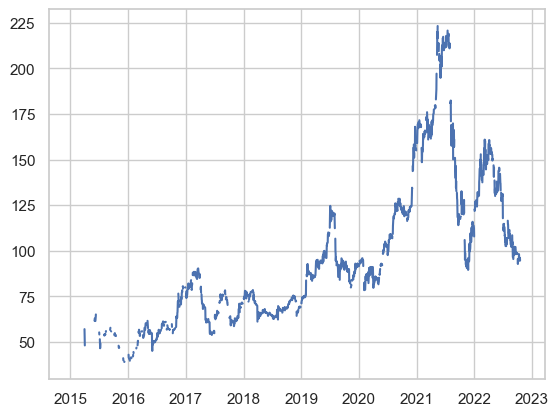

In [249]:
plt.plot(X_train_front_clean_['Date'], X_train_front_clean_['OPEN_x'], label='Opening Prices')
plt.show()

In [250]:
X_train_front_clean_['Date'].max()

Timestamp('2022-10-31 00:00:00')

In [251]:
X_train_front_clean_.index

Index([     0,     25,     40,     59,    185,    199,    212,    222,    233,
          246,
       ...
       151932, 151967, 152001, 152246, 152276, 152313, 152341, 152369, 152392,
       152430],
      dtype='int64', length=2860)

In [252]:
X_train_front_cleaned = X_train_front_clean_.copy()

In [253]:
X_train_front_cleaned

Date  HIGH_x  LOW_x  OPEN_x  VOLUME_x  HIGH_y  LOW_y  OPEN_y  \
0      2015-01-02     NaN    NaN     NaN       NaN     NaN    NaN     NaN   
25     2015-01-03     NaN    NaN     NaN       NaN     NaN    NaN     NaN   
40     2015-01-04     NaN    NaN     NaN       NaN     NaN    NaN     NaN   
59     2015-01-05     NaN    NaN     NaN       NaN     NaN    NaN     NaN   
185    2015-01-06   71.75  71.75   71.75       5.0   71.52  69.97   69.97   
...           ...     ...    ...     ...       ...     ...    ...     ...   
152313 2022-10-27     NaN    NaN     NaN       NaN   88.25  81.20   86.60   
152341 2022-10-28     NaN    NaN     NaN       NaN   82.60  78.80   82.55   
152369 2022-10-29     NaN    NaN     NaN       NaN     NaN    NaN     NaN   
152392 2022-10-30     NaN    NaN     NaN       NaN     NaN    NaN     NaN   
152430 2022-10-31   92.65  92.25   92.60     575.0   80.50  75.00   80.20   

        CLOSE_y  VOLUME_y Overall Sentiment  flows_daily_total  \
0         70.25       NaN               NaN       2.561038e+06   
25          NaN       NaN               NaN       1.277684e+06   
40          NaN       NaN               NaN       1.996771e+06   
59        69.41       NaN               NaN       1.379357e+07   
185       71.19      67.0               NaN       1.595791e+06   
...         ...       ...               ...                ...   
152313    81.71   85428.0               NaN       2.162870e+06   
152341    80.69   76203.0               NaN       2.663315e+06   
152369      NaN       NaN               NaN       2.370509e+06   
152392      NaN       NaN               NaN       4.195710e+06   
152430    78.57   17191.0               NaN       2.793603e+07   

        china_daily_import  row_daily_import  aus_daily_export  \
0             1.775969e+06        785069.436      2.088850e+06   
25            9.677652e+05        309918.644      1.208866e+06   
40            1.669956e+06        326815.163      1.257124e+06   
59            8.273903e+06       5519666.376      9.233797e+06   
185           8.535047e+05        742286.747      1.277238e+06   
...                    ...               ...               ...   
152313        1.936770e+06        226100.519      1.359520e+06   
152341        1.839490e+06        823825.665      1.674147e+06   
152369        2.031363e+06        339145.565      1.714941e+06   
152392        3.281215e+06        914494.717      2.270725e+06   
152430        2.167373e+07       6262303.716      2.008872e+07   

        brazil_daily_export  row_daily_export  polarity_avg_daily  \
0                331104.000        141084.601                 NaN   
25                    0.000         68817.734                 NaN   
40               614166.235        125480.778                 NaN   
59              3519837.000       1039935.033                 NaN   
185              106661.810        211891.126                 NaN   
...                     ...               ...                 ...   
152313           367493.000        435857.122            0.133333   
152341           746615.417        242553.127            0.181818   
152369           406442.000        249125.216                 NaN   
152392          1485193.277        439791.184            0.045455   
152430          4675804.623       3171505.095                 NaN   

        article_count_daily  stocks_daily  
0                         0           NaN  
25                        0           NaN  
40                        0           NaN  
59                        0       0.19550  
185                       0       0.19550  
...                     ...           ...  
152313                    1       0.49869  
152341                    1       0.49869  
152369                    0       0.49869  
152392                    2       0.49869  
152430                    0       0.53637  

[2860 rows x 20 columns]

In [254]:
X_train_front_cleaned.isnull().sum()

Date                      0
HIGH_x                 1175
LOW_x                  1175
OPEN_x                 1175
VOLUME_x               1154
HIGH_y                  873
LOW_y                   873
OPEN_y                  873
CLOSE_y                 841
VOLUME_y                871
Overall Sentiment      2860
flows_daily_total         0
china_daily_import        0
row_daily_import          0
aus_daily_export          0
brazil_daily_export       0
row_daily_export          0
polarity_avg_daily     1270
article_count_daily       0
stocks_daily              3
dtype: int64

### Aggregation on X_test_front  

In [255]:
#Aggregating across the different flows for the same day
X_test_front.loc[:,'flows_daily_total'] = X_test_front.groupby('Date')['Flows_Volume'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/179998387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_front.loc[:,'flows_daily_total'] = X_test_front.groupby('Date')['Flows_Volume'].transform('sum')


In [256]:
#Aggregating across the imports for the same day
X_test_front.loc[:,'china_daily_import'] = X_test_front.groupby('Date')['china_imports'].transform('sum')
X_test_front.loc[:,'row_daily_import'] = X_test_front.groupby('Date')['row_imports'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/2061233499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_front.loc[:,'china_daily_import'] = X_test_front.groupby('Date')['china_imports'].transform('sum')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/2061233499.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_front.loc[:,'row_daily_import'] = X_test_front.groupby('Date')['row_imports'].transform('sum')


In [257]:
#Aggregating across the exports for the same day
X_test_front.loc[:,'aus_daily_export'] = X_test_front.groupby('Date')['aus_exports'].transform('sum')
X_test_front.loc[:,'brazil_daily_export'] = X_test_front.groupby('Date')['brazil_exports'].transform('sum')
X_test_front.loc[:,'row_daily_export'] = X_test_front.groupby('Date')['row_exports'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/441763902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_front.loc[:,'aus_daily_export'] = X_test_front.groupby('Date')['aus_exports'].transform('sum')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/441763902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_front.loc[:,'brazil_daily_export'] = X_test_front.groupby('Date')['brazil_exports'].transform('sum')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/i

In [258]:
#Aggregating sentiment by day
X_test_front.loc[:,'polarity_avg_daily'] = X_test_front.groupby('Date')['Polarity'].transform('mean')
X_test_front.loc[:,'article_count_daily'] = X_test_front.groupby('Date')['Polarity'].transform('count') #number of articles from number of polarity scores

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/4202088367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_front.loc[:,'polarity_avg_daily'] = X_test_front.groupby('Date')['Polarity'].transform('mean')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/4202088367.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_front.loc[:,'article_count_daily'] = X_test_front.groupby('Date')['Polarity'].transform('count') #number of articles from number of polarity scores


In [259]:
#Aggregating across the different stock locations on a given date
X_test_front.loc[:,'stocks_weekly'] =  X_test_front.groupby('Date')['Stock_Volume'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/684383225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_front.loc[:,'stocks_weekly'] =  X_test_front.groupby('Date')['Stock_Volume'].transform('sum')


In [260]:
#Replacing zeros with NaN in the weekly stocks column 
X_test_front.loc[:,'stocks_weekly'] = X_test_front[weekly_column].replace(0, np.nan)

#Filling the weekly values across all days of that week 
X_test_front.loc[:,weekly_column] = X_test_front[weekly_column].ffill()

#Creating a daily stocks column 
daily_column = 'stocks_daily'
X_test_front.loc[:,daily_column] = X_test_front[weekly_column] / 7

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/455775371.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_front.loc[:,daily_column] = X_test_front[weekly_column] / 7


In [261]:
X_test_front_clean = X_test_front.copy()

In [262]:
X_test_front_clean.reset_index(inplace=True)
X_test_front_clean = X_test_front_clean.drop_duplicates(subset='Date', keep='first')
X_test_front_clean.columns #code to check

Index(['Date', 'HIGH_x', 'LOW_x', 'OPEN_x', 'VOLUME_x', 'COUNT_x', 'RIC_x',
       'Description_x', 'Interval_x', 'Currency_x', 'FriendlyName_x', 'HIGH_y',
       'LOW_y', 'OPEN_y', 'CLOSE_y', 'VOLUME_y', 'COUNT_y', 'RIC_y',
       'Description_y', 'Interval_y', 'Currency_y', 'FriendlyName_y',
       'VoyageNumber', 'ArrivalDateLoad', 'SailingDateLoad',
       'ArrivalDateDischarge', 'SailingDateDischarge', 'Flows_Volume',
       'PortNameLoad', 'CountryNameLoad', 'PortNameDischarge',
       'CountryNameDischarge', 'CargoType', 'CargoName', 'L1CargoName',
       'L2CargoTypeID', 'L2CargoName', 'Year', 'CountrySubArea',
       'CountrySubAreaUnit', 'Stock_Volume', 'articlesShortDescription',
       'Polarity', 'Overall Sentiment', 'china_imports', 'row_imports',
       'aus_exports', 'brazil_exports', 'row_exports', 'flows_daily_total',
       'china_daily_import', 'row_daily_import', 'aus_daily_export',
       'brazil_daily_export', 'row_daily_export', 'polarity_avg_daily',
       'art

In [269]:
X_test_front_clean_ = X_test_front_clean.drop(['COUNT_x', 'COUNT_y', 'Description_x', 'RIC_x', 'Interval_x', 'Currency_x', 'RIC_y', 
                           'Description_y', 'Interval_y', 'Currency_y', 'VoyageNumber', 'Stock_Volume', 'Polarity', 
                           'ArrivalDateLoad', 'SailingDateLoad', 'ArrivalDateDischarge', ''
                           'SailingDateDischarge', 'Flows_Volume', 'PortNameLoad', 'CountryNameLoad', 'PortNameDischarge',
                           'CountryNameDischarge', 'Year', 'CountrySubArea', 'CountrySubAreaUnit',
                           'aus_exports', 'brazil_exports', 'row_exports', 'china_imports', 'row_imports', 
                            'FriendlyName_x', 'FriendlyName_y', 'L2CargoName', 'L2CargoTypeID', 'L1CargoName', 
                          'CargoName', 'CargoType', 'articlesShortDescription', 'stocks_weekly'], 
                          axis=1)

In [270]:
X_test_front_clean_ #code to check

Date  HIGH_x   LOW_x  OPEN_x  VOLUME_x  HIGH_y   LOW_y  OPEN_y  \
0     2022-10-31   92.65   92.25   92.60     575.0   80.50   75.00   80.20   
29    2022-11-01   80.75   76.85   78.70   11994.0   79.10   75.25   77.25   
66    2022-11-02   83.05   79.45   80.00   20200.0   81.45   77.65   78.45   
90    2022-11-03   83.70   81.55   82.10   12862.0   82.05   79.80   80.55   
127   2022-11-04   93.00   82.80   83.30   26527.0     NaN     NaN     NaN   
...          ...     ...     ...     ...       ...     ...     ...     ...   
16822 2023-10-30  118.95  118.75  118.85      50.0  122.00  120.45  121.80   
16856 2023-10-31  119.00  118.00  118.85     458.0  122.00  120.10  121.80   
16888 2023-11-01  124.35  121.15  121.45   36441.0  121.80  118.85  119.05   
16910 2023-11-02  125.10  122.90  124.00   15494.0  122.75  120.40  121.55   
16935 2023-11-03  126.20  124.05  124.55    5351.0  123.80  121.60  122.80   

       CLOSE_y  VOLUME_y Overall Sentiment  flows_daily_total  \
0        78.57   17191.0               NaN        3822183.097   
29       78.10   32318.0               NaN        2324459.102   
66       80.52   52080.0               NaN        3070751.500   
90       81.72   36629.0               NaN        2538039.921   
127      85.95       NaN               NaN        2666177.592   
...        ...       ...               ...                ...   
16822   121.72   16919.0               NaN        2720786.491   
16856   121.55   44076.0               NaN        2577951.493   
16888   121.48   51751.0               NaN        2290639.681   
16910   122.59   53356.0               NaN        2802455.672   
16935   122.94   42420.0               NaN        2848908.638   

       china_daily_import  row_daily_import  aus_daily_export  \
0             1202452.918       2619730.179       1202452.918   
29            1717052.602        607406.500       2151431.653   
66            2226891.935        843859.565       2195252.795   
90            2077293.926        460745.995       2095385.724   
127           2255212.698        410964.894       2190926.186   
...                   ...               ...               ...   
16822         2361672.868        359113.623       2276327.097   
16856         1857894.935        720056.558       1665155.746   
16888         1217981.719       1072657.962       1245018.990   
16910         1827683.415        974772.257       2148427.913   
16935         2066972.633        781936.005       1598911.095   

       brazil_daily_export  row_daily_export  polarity_avg_daily  \
0              2619730.179             0.000                 NaN   
29              173027.449             0.000            0.022917   
66              494033.801        381464.904                 NaN   
90              275959.230        166694.967           -0.005876   
127             420695.877         54555.529                 NaN   
...                    ...               ...                 ...   
16822           174757.928        269701.466                 NaN   
16856           616177.000        296618.747           -0.100000   
16888           575659.780        469960.911            0.303896   
16910           168517.000        485510.759            0.100000   
16935           741237.479        508760.064                 NaN   

       article_count_daily  stocks_daily  
0                        0      0.065459  
29                       4      0.065459  
66                       0      0.065459  
90                       3      0.065459  
127                      0      0.065459  
...                    ...           ...  
16822                    0      0.555034  
16856                    3      0.555034  
16888                    1      0.555034  
16910                    1      0.555034  
16935                    0      0.555034  

[369 rows x 20 columns]

In [271]:
X_test_front_cleaned = X_test_front_clean_.copy() 

In [274]:
X_test_front_cleaned.isnull().sum()

Date                     0
HIGH_x                 114
LOW_x                  114
OPEN_x                 114
VOLUME_x               114
HIGH_y                 113
LOW_y                  113
OPEN_y                 113
CLOSE_y                108
VOLUME_y               113
Overall Sentiment      369
flows_daily_total        0
china_daily_import       0
row_daily_import         0
aus_daily_export         0
brazil_daily_export      0
row_daily_export         0
polarity_avg_daily     175
article_count_daily      0
stocks_daily             0
dtype: int64

### Aggregation on X_train_second 

In [275]:
#Aggregating across the different flows for the same day
X_train_second.loc[:,'flows_daily_total'] = X_train_second.groupby('Date')['Flows_Volume'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/3403238048.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_second.loc[:,'flows_daily_total'] = X_train_second.groupby('Date')['Flows_Volume'].transform('sum')


In [276]:
#Aggregating across the imports for the same day
X_train_second.loc[:,'china_daily_import'] = X_train_second.groupby('Date')['china_imports'].transform('sum')
X_train_second.loc[:,'row_daily_import'] = X_train_second.groupby('Date')['row_imports'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/349986271.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_second.loc[:,'china_daily_import'] = X_train_second.groupby('Date')['china_imports'].transform('sum')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/349986271.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_second.loc[:,'row_daily_import'] = X_train_second.groupby('Date')['row_imports'].transform('sum')


In [277]:
#Aggregating across the exports for the same day
X_train_second.loc[:,'aus_daily_export'] = X_train_second.groupby('Date')['aus_exports'].transform('sum')
X_train_second.loc[:,'brazil_daily_export'] = X_train_second.groupby('Date')['brazil_exports'].transform('sum')
X_train_second.loc[:,'row_daily_export'] = X_train_second.groupby('Date')['row_exports'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/3888714515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_second.loc[:,'aus_daily_export'] = X_train_second.groupby('Date')['aus_exports'].transform('sum')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/3888714515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_second.loc[:,'brazil_daily_export'] = X_train_second.groupby('Date')['brazil_exports'].transform('sum')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw

In [278]:
#Aggregating sentiment by day
X_train_second.loc[:,'polarity_avg_daily'] = X_train_second.groupby('Date')['Polarity'].transform('mean')
X_train_second.loc[:,'article_count_daily'] = X_train_second.groupby('Date')['Polarity'].transform('count') #number of articles from number of polarity scores

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/4051568810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_second.loc[:,'polarity_avg_daily'] = X_train_second.groupby('Date')['Polarity'].transform('mean')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/4051568810.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_second.loc[:,'article_count_daily'] = X_train_second.groupby('Date')['Polarity'].transform('count') #number of articles from number of polarity 

In [279]:
#Aggregating across the different stock locations on a given date
X_train_second.loc[:,'stocks_weekly'] =  X_train_second.groupby('Date')['Stock_Volume'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1360190821.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_second.loc[:,'stocks_weekly'] =  X_train_second.groupby('Date')['Stock_Volume'].transform('sum')


In [280]:
#Replacing zeros with NaN in the weekly stocks column 
X_train_second.loc[:,'stocks_weekly'] = X_train_second[weekly_column].replace(0, np.nan)

#Filling the weekly values across all days of that week 
X_train_second.loc[:,weekly_column] = X_train_second[weekly_column].ffill()

#Creating a daily stocks column 
daily_column = 'stocks_daily'
X_train_second.loc[:,daily_column] = X_train_second[weekly_column] / 7

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/905993681.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_second.loc[:,daily_column] = X_train_second[weekly_column] / 7


In [281]:
X_train_second_clean = X_train_second.copy()

In [282]:
X_train_second_clean.reset_index(inplace=True)
X_train_second_clean = X_train_second_clean.drop_duplicates(subset='Date', keep='first')
X_train_second_clean #code to check

Date  HIGH_x  LOW_x  OPEN_x  CLOSE_x  VOLUME_x  COUNT_x   RIC_x  \
0      2015-01-02     NaN    NaN     NaN    70.67       NaN     -1.0  SZZFc1   
25     2015-01-03     NaN    NaN     NaN      NaN       NaN      NaN     NaN   
40     2015-01-04     NaN    NaN     NaN      NaN       NaN      NaN     NaN   
59     2015-01-05     NaN    NaN     NaN    69.94       NaN     -1.0  SZZFc1   
185    2015-01-06   71.75  71.75   71.75    71.64       5.0     -1.0  SZZFc1   
...           ...     ...    ...     ...      ...       ...      ...     ...   
152313 2022-10-27     NaN    NaN     NaN    92.89       NaN     -1.0  SZZFc1   
152341 2022-10-28     NaN    NaN     NaN    92.59       NaN     -1.0  SZZFc1   
152369 2022-10-29     NaN    NaN     NaN      NaN       NaN      NaN     NaN   
152392 2022-10-30     NaN    NaN     NaN      NaN       NaN      NaN     NaN   
152430 2022-10-31   92.65  92.25   92.60    92.43     575.0     -1.0  SZZFc1   

                                            Description_x Interval_x  ...  \
0       Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
25                                                    NaN        NaN  ...   
40                                                    NaN        NaN  ...   
59      Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
185     Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
...                                                   ...        ...  ...   
152313  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
152341  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
152369                                                NaN        NaN  ...   
152392                                                NaN        NaN  ...   
152430  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   

       flows_daily_total china_daily_import  row_daily_import  \
0           2.561038e+06       1.775969e+06        785069.436   
25          1.277684e+06       9.677652e+05        309918.644   
40          1.996771e+06       1.669956e+06        326815.163   
59          1.379357e+07       8.273903e+06       5519666.376   
185         1.595791e+06       8.535047e+05        742286.747   
...                  ...                ...               ...   
152313      2.162870e+06       1.936770e+06        226100.519   
152341      2.663315e+06       1.839490e+06        823825.665   
152369      2.370509e+06       2.031363e+06        339145.565   
152392      4.195710e+06       3.281215e+06        914494.717   
152430      2.793603e+07       2.167373e+07       6262303.716   

        aus_daily_export  brazil_daily_export  row_daily_export  \
0           2.088850e+06           331104.000        141084.601   
25          1.208866e+06                0.000         68817.734   
40          1.257124e+06           614166.235        125480.778   
59          9.233797e+06          3519837.000       1039935.033   
185         1.277238e+06           106661.810        211891.126   
...                  ...                  ...               ...   
152313      1.359520e+06           367493.000        435857.122   
152341      1.674147e+06           746615.417        242553.127   
152369      1.714941e+06           406442.000        249125.216   
152392      2.270725e+06          1485193.277        439791.184   
152430      2.008872e+07          4675804.623       3171505.095   

        polarity_avg_daily article_count_daily stocks_weekly stocks_daily  
0                      NaN                   0           NaN          NaN  
25                     NaN                   0           NaN          NaN  
40                     NaN                   0           NaN          NaN  
59                     NaN                   0       1.36850      0.19550  
185                    NaN                   0       1.36850      0.19550  
...                    ...                 ...           ...          ...  
152313   

In [289]:
#Dropping daily columns as well as other unnecessary columns 

X_train_second_clean_ = X_train_second_clean.drop(['COUNT_x', 'COUNT_y', 'Description_x', 'RIC_x', 'Interval_x', 'Currency_x', 'RIC_y', 
                           'Description_y', 'Interval_y', 'Currency_y', 'VoyageNumber', 'Stock_Volume', 'Polarity', 
                           'ArrivalDateLoad', 'SailingDateLoad', 'ArrivalDateDischarge', ''
                           'SailingDateDischarge', 'Flows_Volume', 'PortNameLoad', 'CountryNameLoad', 'PortNameDischarge',
                           'CountryNameDischarge', 'Year', 'CountrySubArea', 'CountrySubAreaUnit',
                           'aus_exports', 'brazil_exports', 'row_exports', 'china_imports', 'row_imports', 
                            'FriendlyName_x', 'FriendlyName_y', 'L2CargoName', 'L2CargoTypeID', 'L1CargoName', 
                          'CargoName', 'CargoType', 'articlesShortDescription','stocks_weekly'], 
                          axis=1)

In [290]:
X_train_second_clean_ #code to check

Date  HIGH_x  LOW_x  OPEN_x  CLOSE_x  VOLUME_x  HIGH_y  LOW_y  \
0      2015-01-02     NaN    NaN     NaN    70.67       NaN     NaN    NaN   
25     2015-01-03     NaN    NaN     NaN      NaN       NaN     NaN    NaN   
40     2015-01-04     NaN    NaN     NaN      NaN       NaN     NaN    NaN   
59     2015-01-05     NaN    NaN     NaN    69.94       NaN     NaN    NaN   
185    2015-01-06   71.75  71.75   71.75    71.64       5.0   71.52  69.97   
...           ...     ...    ...     ...      ...       ...     ...    ...   
152313 2022-10-27     NaN    NaN     NaN    92.89       NaN   88.25  81.20   
152341 2022-10-28     NaN    NaN     NaN    92.59       NaN   82.60  78.80   
152369 2022-10-29     NaN    NaN     NaN      NaN       NaN     NaN    NaN   
152392 2022-10-30     NaN    NaN     NaN      NaN       NaN     NaN    NaN   
152430 2022-10-31   92.65  92.25   92.60    92.43     575.0   80.50  75.00   

        OPEN_y  VOLUME_y Overall Sentiment  flows_daily_total  \
0          NaN       NaN               NaN       2.561038e+06   
25         NaN       NaN               NaN       1.277684e+06   
40         NaN       NaN               NaN       1.996771e+06   
59         NaN       NaN               NaN       1.379357e+07   
185      69.97      67.0               NaN       1.595791e+06   
...        ...       ...               ...                ...   
152313   86.60   85428.0               NaN       2.162870e+06   
152341   82.55   76203.0               NaN       2.663315e+06   
152369     NaN       NaN               NaN       2.370509e+06   
152392     NaN       NaN               NaN       4.195710e+06   
152430   80.20   17191.0               NaN       2.793603e+07   

        china_daily_import  row_daily_import  aus_daily_export  \
0             1.775969e+06        785069.436      2.088850e+06   
25            9.677652e+05        309918.644      1.208866e+06   
40            1.669956e+06        326815.163      1.257124e+06   
59            8.273903e+06       5519666.376      9.233797e+06   
185           8.535047e+05        742286.747      1.277238e+06   
...                    ...               ...               ...   
152313        1.936770e+06        226100.519      1.359520e+06   
152341        1.839490e+06        823825.665      1.674147e+06   
152369        2.031363e+06        339145.565      1.714941e+06   
152392        3.281215e+06        914494.717      2.270725e+06   
152430        2.167373e+07       6262303.716      2.008872e+07   

        brazil_daily_export  row_daily_export  polarity_avg_daily  \
0                331104.000        141084.601                 NaN   
25                    0.000         68817.734                 NaN   
40               614166.235        125480.778                 NaN   
59              3519837.000       1039935.033                 NaN   
185              106661.810        211891.126                 NaN   
...                     ...               ...                 ...   
152313           367493.000        435857.122            0.133333   
152341           746615.417        242553.127            0.181818   
152369           406442.000        249125.216                 NaN   
152392          1485193.277        439791.184            0.045455   
152430          4675804.623       3171505.095                 NaN   

        article_count_daily  stocks_daily  
0                         0           NaN  
25                        0           NaN  
40                        0           NaN  
59                        0       0.19550  
185                       0       0.19550  
...                     ...           ...  
152313                    1       0.49869  
152341                    1       0.49869  
152369                    0       0.49869  
152392                    2       0.49869  
152430                    0       0.53637  

[2860 rows x 20 columns]

In [291]:
X_train_second_cleaned = X_train_second_clean_.copy()

In [294]:
X_train_second_cleaned.isnull().sum()

Date                      0
HIGH_x                 1175
LOW_x                  1175
OPEN_x                 1175
CLOSE_x                 845
VOLUME_x               1154
HIGH_y                  873
LOW_y                   873
OPEN_y                  873
VOLUME_y                871
Overall Sentiment      2860
flows_daily_total         0
china_daily_import        0
row_daily_import          0
aus_daily_export          0
brazil_daily_export       0
row_daily_export          0
polarity_avg_daily     1270
article_count_daily       0
stocks_daily              3
dtype: int64

### Aggregation on X_test_second 

In [295]:
#Aggregating across the different flows for the same day
X_test_second.loc[:,'flows_daily_total'] = X_test_second.groupby('Date')['Flows_Volume'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/2848176504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_second.loc[:,'flows_daily_total'] = X_test_second.groupby('Date')['Flows_Volume'].transform('sum')


In [296]:
#Aggregating across the imports for the same day
X_test_second.loc[:,'china_daily_import'] = X_test_second.groupby('Date')['china_imports'].transform('sum')
X_test_second.loc[:,'row_daily_import'] = X_test_second.groupby('Date')['row_imports'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1593965416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_second.loc[:,'china_daily_import'] = X_test_second.groupby('Date')['china_imports'].transform('sum')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1593965416.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_second.loc[:,'row_daily_import'] = X_test_second.groupby('Date')['row_imports'].transform('sum')


In [297]:
#Aggregating across the exports for the same day
X_test_second.loc[:,'aus_daily_export'] = X_test_second.groupby('Date')['aus_exports'].transform('sum')
X_test_second.loc[:,'brazil_daily_export'] = X_test_second.groupby('Date')['brazil_exports'].transform('sum')
X_test_second.loc[:,'row_daily_export'] = X_test_second.groupby('Date')['row_exports'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/3662856145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_second.loc[:,'aus_daily_export'] = X_test_second.groupby('Date')['aus_exports'].transform('sum')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/3662856145.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_second.loc[:,'brazil_daily_export'] = X_test_second.groupby('Date')['brazil_exports'].transform('sum')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000

In [298]:
#Aggregating sentiment by day
X_test_second.loc[:,'polarity_avg_daily'] = X_test_second.groupby('Date')['Polarity'].transform('mean')
X_test_second.loc[:,'article_count_daily'] = X_test_second.groupby('Date')['Polarity'].transform('count') #number of articles from number of polarity scores

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/808266056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_second.loc[:,'polarity_avg_daily'] = X_test_second.groupby('Date')['Polarity'].transform('mean')
/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/808266056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_second.loc[:,'article_count_daily'] = X_test_second.groupby('Date')['Polarity'].transform('count') #number of articles from number of polarity scores

In [299]:
#Aggregating across the different stock locations on a given date
X_test_second.loc[:,'stocks_weekly'] =  X_test_second.groupby('Date')['Stock_Volume'].transform('sum')

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/4201645827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_second.loc[:,'stocks_weekly'] =  X_test_second.groupby('Date')['Stock_Volume'].transform('sum')


In [300]:
#Replacing zeros with NaN in the weekly stocks column 
X_test_second.loc[:,'stocks_weekly'] = X_test_second[weekly_column].replace(0, np.nan)

#Filling the weekly values across all days of that week 
X_test_second.loc[:,weekly_column] = X_test_second[weekly_column].ffill()

#Creating a daily stocks column 
daily_column = 'stocks_daily'
X_test_second.loc[:,daily_column] = X_test_second[weekly_column] / 7

/var/folders/w2/rv9s6p814n548_nhp6nhhyvw0000gn/T/ipykernel_1157/1257808588.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_second.loc[:,daily_column] = X_test_second[weekly_column] / 7


In [301]:
X_test_second_clean = X_test_second.copy() #making a copy

In [302]:
X_test_second_clean.reset_index(inplace=True)
X_test_second_clean = X_test_second_clean.drop_duplicates(subset='Date', keep='first')
X_test_second_clean #code to check

Date  HIGH_x   LOW_x  OPEN_x  CLOSE_x  VOLUME_x  COUNT_x   RIC_x  \
0     2022-10-31   92.65   92.25   92.60    92.43     575.0     -1.0  SZZFc1   
29    2022-11-01   80.75   76.85   78.70    79.79   11994.0     -1.0  SZZFc1   
66    2022-11-02   83.05   79.45   80.00    82.12   20200.0     -1.0  SZZFc1   
90    2022-11-03   83.70   81.55   82.10    83.32   12862.0     -1.0  SZZFc1   
127   2022-11-04   93.00   82.80   83.30    86.97   26527.0     -1.0  SZZFc1   
...          ...     ...     ...     ...      ...       ...      ...     ...   
16822 2023-10-30  118.95  118.75  118.85   118.97      50.0     -1.0  SZZFc1   
16856 2023-10-31  119.00  118.00  118.85   118.91     458.0     -1.0  SZZFc1   
16888 2023-11-01  124.35  121.15  121.45   123.92   36441.0     -1.0  SZZFc1   
16910 2023-11-02  125.10  122.90  124.00   124.99   15494.0     -1.0  SZZFc1   
16935 2023-11-03  126.20  124.05  124.55   125.39    5351.0     -1.0  SZZFc1   

                                           Description_x Interval_x  ...  \
0      Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
29     Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
66     Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
90     Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
127    Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
...                                                  ...        ...  ...   
16822  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
16856  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
16888  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
16910  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   
16935  Singapore Exchange Derivatives TSI IronOre CFR...      daily  ...   

      flows_daily_total china_daily_import  row_daily_import  \
0           3822183.097        1202452.918       2619730.179   
29          2324459.102        1717052.602        607406.500   
66          3070751.500        2226891.935        843859.565   
90          2538039.921        2077293.926        460745.995   
127         2666177.592        2255212.698        410964.894   
...                 ...                ...               ...   
16822       2720786.491        2361672.868        359113.623   
16856       2577951.493        1857894.935        720056.558   
16888       2290639.681        1217981.719       1072657.962   
16910       2802455.672        1827683.415        974772.257   
16935       2848908.638        2066972.633        781936.005   

       aus_daily_export  brazil_daily_export  row_daily_export  \
0           1202452.918          2619730.179             0.000   
29          2151431.653           173027.449             0.000   
66          2195252.795           494033.801        381464.904   
90          2095385.724           275959.230        166694.967   
127         2190926.186           420695.877         54555.529   
...                 ...                  ...               ...   
16822       2276327.097           174757.928        269701.466   
16856       1665155.746           616177.000        296618.747   
16888       1245018.990           575659.780        469960.911   
16910       2148427.913           168517.000        485510.759   
16935       1598911.095           741237.479        508760.064   

       polarity_avg_daily article_count_daily stocks_weekly stocks_daily  
0                     NaN                   0       0.45821     0.065459  
29               0.022917                   4       0.45821     0.065459  
66                    NaN                   0       0.45821     0.065459  
90              -0.005876                   3       0.45821     0.065459  
127                   NaN                   0       0.45821     0.065459  
...                   ...                 ...           ...          ...  
16822                 NaN                   0      

In [309]:
#Dropping daily columns as well as other unnecessary columns 

X_test_second_clean_ = X_test_second_clean.drop(['COUNT_x', 'COUNT_y', 'Description_x', 'RIC_x', 'Interval_x', 'Currency_x', 'RIC_y', 
                           'Description_y', 'Interval_y', 'Currency_y', 'VoyageNumber', 'Stock_Volume', 'Polarity', 
                           'ArrivalDateLoad', 'SailingDateLoad', 'ArrivalDateDischarge', ''
                           'SailingDateDischarge', 'Flows_Volume', 'PortNameLoad', 'CountryNameLoad', 'PortNameDischarge',
                           'CountryNameDischarge', 'Year', 'CountrySubArea', 'CountrySubAreaUnit',
                           'aus_exports', 'brazil_exports', 'row_exports', 'china_imports', 'row_imports', 
                            'FriendlyName_x', 'FriendlyName_y', 'L2CargoName', 'L2CargoTypeID', 'L1CargoName', 
                          'CargoName', 'CargoType', 'articlesShortDescription', 'stocks_weekly'], 
                          axis=1)

In [310]:
X_test_second_clean_ #code to check

Date  HIGH_x   LOW_x  OPEN_x  CLOSE_x  VOLUME_x  HIGH_y   LOW_y  \
0     2022-10-31   92.65   92.25   92.60    92.43     575.0   80.50   75.00   
29    2022-11-01   80.75   76.85   78.70    79.79   11994.0   79.10   75.25   
66    2022-11-02   83.05   79.45   80.00    82.12   20200.0   81.45   77.65   
90    2022-11-03   83.70   81.55   82.10    83.32   12862.0   82.05   79.80   
127   2022-11-04   93.00   82.80   83.30    86.97   26527.0     NaN     NaN   
...          ...     ...     ...     ...      ...       ...     ...     ...   
16822 2023-10-30  118.95  118.75  118.85   118.97      50.0  122.00  120.45   
16856 2023-10-31  119.00  118.00  118.85   118.91     458.0  122.00  120.10   
16888 2023-11-01  124.35  121.15  121.45   123.92   36441.0  121.80  118.85   
16910 2023-11-02  125.10  122.90  124.00   124.99   15494.0  122.75  120.40   
16935 2023-11-03  126.20  124.05  124.55   125.39    5351.0  123.80  121.60   

       OPEN_y  VOLUME_y Overall Sentiment  flows_daily_total  \
0       80.20   17191.0               NaN        3822183.097   
29      77.25   32318.0               NaN        2324459.102   
66      78.45   52080.0               NaN        3070751.500   
90      80.55   36629.0               NaN        2538039.921   
127       NaN       NaN               NaN        2666177.592   
...       ...       ...               ...                ...   
16822  121.80   16919.0               NaN        2720786.491   
16856  121.80   44076.0               NaN        2577951.493   
16888  119.05   51751.0               NaN        2290639.681   
16910  121.55   53356.0               NaN        2802455.672   
16935  122.80   42420.0               NaN        2848908.638   

       china_daily_import  row_daily_import  aus_daily_export  \
0             1202452.918       2619730.179       1202452.918   
29            1717052.602        607406.500       2151431.653   
66            2226891.935        843859.565       2195252.795   
90            2077293.926        460745.995       2095385.724   
127           2255212.698        410964.894       2190926.186   
...                   ...               ...               ...   
16822         2361672.868        359113.623       2276327.097   
16856         1857894.935        720056.558       1665155.746   
16888         1217981.719       1072657.962       1245018.990   
16910         1827683.415        974772.257       2148427.913   
16935         2066972.633        781936.005       1598911.095   

       brazil_daily_export  row_daily_export  polarity_avg_daily  \
0              2619730.179             0.000                 NaN   
29              173027.449             0.000            0.022917   
66              494033.801        381464.904                 NaN   
90              275959.230        166694.967           -0.005876   
127             420695.877         54555.529                 NaN   
...                    ...               ...                 ...   
16822           174757.928        269701.466                 NaN   
16856           616177.000        296618.747           -0.100000   
16888           575659.780        469960.911            0.303896   
16910           168517.000        485510.759            0.100000   
16935           741237.479        508760.064                 NaN   

       article_count_daily  stocks_daily  
0                        0      0.065459  
29                       4      0.065459  
66                       0      0.065459  
90                       3      0.065459  
127                      0      0.065459  
...                    ...           ...  
16822                    0      0.555034  
16856                    3      0.555034  
16888                    1      0.555034  
16910                    1      0.555034  
16935                    0      0.555034  

[369 rows x 20 columns]

In [312]:
X_test_second_cleaned = X_test_second_clean_.copy()

In [315]:
X_test_second_cleaned.isnull().sum()

Date                     0
HIGH_x                 114
LOW_x                  114
OPEN_x                 114
CLOSE_x                108
VOLUME_x               114
HIGH_y                 113
LOW_y                  113
OPEN_y                 113
VOLUME_y               113
Overall Sentiment      369
flows_daily_total        0
china_daily_import       0
row_daily_import         0
aus_daily_export         0
brazil_daily_export      0
row_daily_export         0
polarity_avg_daily     175
article_count_daily      0
stocks_daily             0
dtype: int64

### Dropping rows for target variable 

In [316]:
y_train_front.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152689 entries, 745 to 153433
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   Date     152689 non-null  datetime64[ns]
 1   CLOSE_x  120566 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.5 MB


In [317]:
y_train_front_clean = y_train_front.copy()

In [318]:
y_test_front_clean = y_test_front.copy()

In [319]:
y_train_second_clean = y_train_second.copy()

In [320]:
y_test_second_clean = y_test_second.copy()

In [321]:
y_train_front_clean['Date'] = pd.to_datetime(y_train_front_clean['Date'])

In [322]:
#Repeating on test 

y_test_front_clean['Date'] = pd.to_datetime(y_test_front_clean['Date'])

In [323]:
y_train_second_clean['Date'] = pd.to_datetime(y_train_second_clean['Date'])

In [324]:
#Repeating on test 

y_test_second_clean['Date'] = pd.to_datetime(y_test_second_clean['Date'])

In [333]:
y_train_front_clean #code to check

Date  CLOSE_x
745    2015-01-02    70.67
746    2015-01-02    70.67
747    2015-01-02    70.67
748    2015-01-02    70.67
749    2015-01-02    70.67
...           ...      ...
153429 2022-10-31    92.43
153430 2022-10-31    92.43
153431 2022-10-31    92.43
153432 2022-10-31    92.43
153433 2022-10-31    92.43

[152689 rows x 2 columns]

In [334]:
y_test_front_clean

Date  CLOSE_x
153434 2022-10-31    92.43
153435 2022-10-31    92.43
153436 2022-10-31    92.43
153437 2022-10-31    92.43
153438 2022-10-31    92.43
...           ...      ...
170394 2023-11-03   125.39
170395 2023-11-03   125.39
170396 2023-11-03   125.39
170397 2023-11-03   125.39
170398 2023-11-03   125.39

[16965 rows x 2 columns]

In [335]:
y_train_second_clean

Date  CLOSE_y
745    2015-01-02    70.25
746    2015-01-02    70.25
747    2015-01-02    70.25
748    2015-01-02    70.25
749    2015-01-02    70.25
...           ...      ...
153429 2022-10-31    78.57
153430 2022-10-31    78.57
153431 2022-10-31    78.57
153432 2022-10-31    78.57
153433 2022-10-31    78.57

[152689 rows x 2 columns]

In [336]:
y_test_second_clean

Date  CLOSE_y
153434 2022-10-31    78.57
153435 2022-10-31    78.57
153436 2022-10-31    78.57
153437 2022-10-31    78.57
153438 2022-10-31    78.57
...           ...      ...
170394 2023-11-03   122.94
170395 2023-11-03   122.94
170396 2023-11-03   122.94
170397 2023-11-03   122.94
170398 2023-11-03   122.94

[16965 rows x 2 columns]

In [342]:
y_train_front_cleaned = y_train_front_clean.drop_duplicates(subset='Date')

In [344]:
#Repeating on test 

y_test_front_cleaned = y_test_front_clean.drop_duplicates(subset='Date')

In [346]:
#For second-month contracts 

y_train_second_cleaned = y_train_second_clean.drop_duplicates(subset='Date')

In [347]:
# y_test_second_weekly = y_test_second_clean.groupby('Date_weekly').first() #dropping duplicates 

In [348]:
#Repeating on test 
y_test_second_cleaned = y_test_second_clean.drop_duplicates(subset='Date')

In [349]:
y_train_front_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2860 entries, 745 to 153175
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2860 non-null   datetime64[ns]
 1   CLOSE_x  2015 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 67.0 KB


In [350]:
y_test_front_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369 entries, 153434 to 170369
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     369 non-null    datetime64[ns]
 1   CLOSE_x  261 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [351]:
y_train_second_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2860 entries, 745 to 153175
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2860 non-null   datetime64[ns]
 1   CLOSE_y  2019 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 67.0 KB


In [352]:
y_test_second_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369 entries, 153434 to 170369
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     369 non-null    datetime64[ns]
 1   CLOSE_y  261 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


# Handling missing values <a class="anchor" id="missing-values"></a>

## Pricing columns

From the preliminary analysis of pricing data we know that the pricing datasets contain missing values on account of recording errors. In the post-merge X and y datasets, we also observe missing values because of the dates added from our external datasets such as flows which contain weekends. 

In order to fill these missing values for price columns, we will follow a two-step filling strategy. For the dates associated with non-trading days, i.e., weekends, we will use a forward-fill where we carry forward the last observed value. For the dates associated with recording errors, we will use linear interpolation as we observed from our preliminary analysis that price columns follow a general linear trend. 

In [353]:
X_train_front_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2860 entries, 0 to 152430
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 2860 non-null   datetime64[ns]
 1   HIGH_x               1685 non-null   float64       
 2   LOW_x                1685 non-null   float64       
 3   OPEN_x               1685 non-null   float64       
 4   VOLUME_x             1706 non-null   float64       
 5   HIGH_y               1987 non-null   float64       
 6   LOW_y                1987 non-null   float64       
 7   OPEN_y               1987 non-null   float64       
 8   CLOSE_y              2019 non-null   float64       
 9   VOLUME_y             1989 non-null   float64       
 10  Overall Sentiment    0 non-null      object        
 11  flows_daily_total    2860 non-null   float64       
 12  china_daily_import   2860 non-null   float64       
 13  row_daily_import     2860 non-null  

In [354]:
X_test_front_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369 entries, 0 to 16935
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 369 non-null    datetime64[ns]
 1   HIGH_x               255 non-null    float64       
 2   LOW_x                255 non-null    float64       
 3   OPEN_x               255 non-null    float64       
 4   VOLUME_x             255 non-null    float64       
 5   HIGH_y               256 non-null    float64       
 6   LOW_y                256 non-null    float64       
 7   OPEN_y               256 non-null    float64       
 8   CLOSE_y              261 non-null    float64       
 9   VOLUME_y             256 non-null    float64       
 10  Overall Sentiment    0 non-null      object        
 11  flows_daily_total    369 non-null    float64       
 12  china_daily_import   369 non-null    float64       
 13  row_daily_import     369 non-null    f

In [355]:
X_train_second_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2860 entries, 0 to 152430
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 2860 non-null   datetime64[ns]
 1   HIGH_x               1685 non-null   float64       
 2   LOW_x                1685 non-null   float64       
 3   OPEN_x               1685 non-null   float64       
 4   CLOSE_x              2015 non-null   float64       
 5   VOLUME_x             1706 non-null   float64       
 6   HIGH_y               1987 non-null   float64       
 7   LOW_y                1987 non-null   float64       
 8   OPEN_y               1987 non-null   float64       
 9   VOLUME_y             1989 non-null   float64       
 10  Overall Sentiment    0 non-null      object        
 11  flows_daily_total    2860 non-null   float64       
 12  china_daily_import   2860 non-null   float64       
 13  row_daily_import     2860 non-null  

In [356]:
X_test_second_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369 entries, 0 to 16935
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 369 non-null    datetime64[ns]
 1   HIGH_x               255 non-null    float64       
 2   LOW_x                255 non-null    float64       
 3   OPEN_x               255 non-null    float64       
 4   CLOSE_x              261 non-null    float64       
 5   VOLUME_x             255 non-null    float64       
 6   HIGH_y               256 non-null    float64       
 7   LOW_y                256 non-null    float64       
 8   OPEN_y               256 non-null    float64       
 9   VOLUME_y             256 non-null    float64       
 10  Overall Sentiment    0 non-null      object        
 11  flows_daily_total    369 non-null    float64       
 12  china_daily_import   369 non-null    float64       
 13  row_daily_import     369 non-null    f

In [365]:
X_train_front_cleaned.columns

Index(['Date', 'HIGH_x', 'LOW_x', 'OPEN_x', 'VOLUME_x', 'HIGH_y', 'LOW_y',
       'OPEN_y', 'CLOSE_y', 'VOLUME_y', 'Overall Sentiment',
       'flows_daily_total', 'china_daily_import', 'row_daily_import',
       'aus_daily_export', 'brazil_daily_export', 'row_daily_export',
       'polarity_avg_daily', 'article_count_daily', 'stocks_daily'],
      dtype='object')

In [366]:
X_train_second_cleaned.columns

Index(['Date', 'HIGH_x', 'LOW_x', 'OPEN_x', 'CLOSE_x', 'VOLUME_x', 'HIGH_y',
       'LOW_y', 'OPEN_y', 'VOLUME_y', 'Overall Sentiment', 'flows_daily_total',
       'china_daily_import', 'row_daily_import', 'aus_daily_export',
       'brazil_daily_export', 'row_daily_export', 'polarity_avg_daily',
       'article_count_daily', 'stocks_daily'],
      dtype='object')

### First row filling

In [466]:
#Creating of datasets
datasets = [X_train_front_cleaned, X_test_front_cleaned, X_train_second_cleaned, X_test_second_cleaned]

#Creating of columns to fill for each dataset
front_col_to_fill = ['HIGH_x', 'LOW_x', 'OPEN_x', 'VOLUME_x', 'COUNT_x', 
                  'HIGH_y', 'LOW_y', 'OPEN_y', 'CLOSE_y', 'VOLUME_y']
second_cols_to_fill = ['HIGH_x', 'LOW_x', 'OPEN_x', 'VOLUME_x', 'COUNT_x', 
                       'CLOSE_x', 'HIGH_y', 'LOW_y', 'OPEN_y', 'VOLUME_y']
columns_to_fill = [front_col_to_fill, front_col_to_fill, second_cols_to_fill, second_cols_to_fill]

for dataset, cols in zip(datasets, columns_to_fill):
    for col in cols:
        if col in dataset.columns:
            first_valid_value = dataset[col].dropna().iloc[0]
            if pd.isna(dataset[col].iloc[0]):
                dataset.at[0, col] = first_valid_value

### Filling pricing values for X datasets 

In [368]:

#Front-month 

front_cols_to_fill = ['HIGH_x', 'LOW_x', 'OPEN_x', 'VOLUME_x', 
                  'HIGH_y', 'LOW_y', 'OPEN_y', 'CLOSE_y', 'VOLUME_y']

#Filling missing values
X_train_front_cleaned = fill_missing_values(X_train_front_cleaned, columns=front_cols_to_fill)
X_test_front_cleaned = fill_missing_values(X_test_front_cleaned, columns=front_cols_to_fill)

#Second-month
second_cols_to_fill = ['HIGH_x', 'LOW_x', 'OPEN_x', 'VOLUME_x',  
                       'CLOSE_x', 'HIGH_y', 'LOW_y', 'OPEN_y', 'VOLUME_y']

X_train_second_cleaned = fill_missing_values(X_train_second_cleaned, columns=second_cols_to_fill)
X_test_second_cleaned = fill_missing_values(X_test_second_cleaned, columns=second_cols_to_fill)

In [369]:
X_train_front_cleaned.head(20) #code to check

HIGH_x  LOW_x  OPEN_x  VOLUME_x  HIGH_y  LOW_y  OPEN_y  CLOSE_y  \
Date                                                                          
2015-01-02   71.75  71.75   71.75       5.0  71.520  69.97  69.970    70.25   
2015-01-03   71.75  71.75   71.75       5.0  71.520  69.97  69.970    70.25   
2015-01-04   71.75  71.75   71.75       5.0  71.520  69.97  69.970    70.25   
2015-01-05   71.75  71.75   71.75       5.0  71.520  69.97  69.970    69.41   
2015-01-06   71.75  71.75   71.75       5.0  71.520  69.97  69.970    71.19   
2015-01-07   71.38  71.38   71.38       6.8  70.500  69.93  70.500    70.50   
2015-01-08   71.01  71.01   71.01       8.6  70.200  69.90  70.000    70.19   
2015-01-09   70.64  70.64   70.64      10.4  69.760  69.32  69.760    69.28   
2015-01-10   70.64  70.64   70.64      10.4  69.760  69.32  69.760    69.28   
2015-01-11   70.64  70.64   70.64      10.4  69.760  69.32  69.760    69.28   
2015-01-12   70.27  70.27   70.27      12.2  68.800  68.05  68.800    67.81   
2015-01-13   69.90  69.90   69.90      14.0  67.975  67.45  67.825    67.53   
2015-01-14   69.53  69.53   69.53      15.8  67.150  66.85  66.850    66.91   
2015-01-15   69.16  69.16   69.16      17.6  68.320  66.75  66.750    68.16   
2015-01-16   68.79  68.79   68.79      19.4  67.870  67.60  67.800    68.03   
2015-01-17   68.79  68.79   68.79      19.4  67.870  67.60  67.800    68.03   
2015-01-18   68.79  68.79   68.79      19.4  67.870  67.60  67.800    68.03   
2015-01-19   68.42  68.42   68.42      21.2  68.000  67.22  67.220    67.89   
2015-01-20   68.05  68.05   68.05      23.0  67.420  67.35  67.420    67.28   
2015-01-21   67.68  67.68   67.68      24.8  66.730  66.22  66.220    65.97   

            VOLUME_y Overall Sentiment  flows_daily_total  china_daily_import  \
Date                                                                            
2015-01-02      67.0               NaN       2.561038e+06         1775968.861   
2015-01-03      67.0               NaN       1.277684e+06          967765.244   
2015-01-04      67.0               NaN       1.996771e+06         1669955.798   
2015-01-05      67.0               NaN       1.379357e+07         8273902.977   
2015-01-06      67.0               NaN       1.595791e+06          853504.655   
2015-01-07      54.0               NaN       1.227764e+06          781984.045   
2015-01-08      30.0               NaN       1.337257e+06         1012881.970   
2015-01-09      20.0               NaN       1.697770e+06          754494.245   
2015-01-10      20.0               NaN       1.403036e+06          959584.232   
2015-01-11      20.0               NaN       1.775079e+06         1537638.625   
2015-01-12      85.0               NaN       1.613485e+07         7442642.430   
2015-01-13      50.0               NaN       2.467851e+06         1930642.932   
2015-01-14      15.0               NaN       1.146820e+06          910033.419   
2015-01-15      80.0               NaN       2.691188e+06         1880673.885   
2015-01-16      19.0               NaN       2.171668e+06         1237691.851   
2015-01-17      19.0               NaN       2.376136e+06         1994908.620   
2015-01-18      19.0               NaN       2.690030e+06         1432964.073   
2015-01-19      25.0               NaN       6.717112e+06         3947605.317   
2015-01-20       9.0               NaN       7.114761e+05          547983.764   
2015-01-21      50.0               NaN       2.560600e+06         1956742.937   

            row_daily_import  aus_daily_export  brazil_daily_export  \
Date                                                                  
2015-01-02        785069.436      2.088850e+06           331104.000   
2015-01-03        309918.644      1.208866e+06                0.000   
2015-01-04        326815.163      1.257124e+06           614166.235   
2015-01-05       5519666.376      9.233797e+06          3519837.000   
2015-01-06        742286.747      1.277238e+06           106661.

In [370]:
X_test_front_cleaned.head(20)

HIGH_x   LOW_x  OPEN_x  VOLUME_x  HIGH_y    LOW_y  OPEN_y  \
Date                                                                    
2022-10-31   92.65  92.250   92.60     575.0  80.500  75.0000   80.20   
2022-11-01   80.75  76.850   78.70   11994.0  79.100  75.2500   77.25   
2022-11-02   83.05  79.450   80.00   20200.0  81.450  77.6500   78.45   
2022-11-03   83.70  81.550   82.10   12862.0  82.050  79.8000   80.55   
2022-11-04   93.00  82.800   83.30   26527.0  85.125  81.8000   83.40   
2022-11-05   93.00  82.800   83.30   26527.0  85.125  81.8000   83.40   
2022-11-06   93.00  82.800   83.30   26527.0  85.125  81.8000   83.40   
2022-11-07   88.80  84.700   87.35   17531.0  88.200  83.8000   86.25   
2022-11-08   88.80  86.550   86.80    9336.0  88.600  85.4500   86.20   
2022-11-09   89.05  88.100   88.25   11058.0  90.450  86.7375   87.30   
2022-11-10   87.50  86.550   87.15    4117.0  92.300  88.0250   88.40   
2022-11-11   90.25  88.725   89.05    9256.5  94.150  89.3125   89.50   
2022-11-12   90.25  88.725   89.05    9256.5  94.150  89.3125   89.50   
2022-11-13   90.25  88.725   89.05    9256.5  94.150  89.3125   89.50   
2022-11-14   93.00  90.900   90.95   14396.0  96.000  90.6000   90.60   
2022-11-15   92.95  91.850   91.85   17307.0  95.550  93.3500   94.60   
2022-11-16   95.50  92.300   92.45   12274.0  99.600  94.0500   94.95   
2022-11-17   93.40  92.300   93.35     379.0  98.950  93.7500   98.95   
2022-11-18   94.70  93.600   94.60   20454.0  99.300  95.9500   96.55   
2022-11-19   94.70  93.600   94.60   20454.0  99.300  95.9500   96.55   

            CLOSE_y  VOLUME_y Overall Sentiment  flows_daily_total  \
Date                                                                 
2022-10-31    78.57  17191.00               NaN       3.822183e+06   
2022-11-01    78.10  32318.00               NaN       2.324459e+06   
2022-11-02    80.52  52080.00               NaN       3.070752e+06   
2022-11-03    81.72  36629.00               NaN       2.538040e+06   
2022-11-04    85.95  47403.00               NaN       2.666178e+06   
2022-11-05    85.95  47403.00               NaN       2.745872e+06   
2022-11-06    85.95  47403.00               NaN       2.435314e+06   
2022-11-07    86.18  58177.00               NaN       2.993930e+07   
2022-11-08    87.89  50873.00               NaN       2.393564e+06   
2022-11-09    88.45  58625.75               NaN       2.576451e+06   
2022-11-10    86.51  66378.50               NaN       2.842784e+06   
2022-11-11    91.28  74131.25               NaN       2.653035e+06   
2022-11-12    91.28  74131.25               NaN       3.016364e+06   
2022-11-13    91.28  74131.25               NaN       2.587115e+06   
2022-11-14    93.54  81884.00               NaN       2.819107e+07   
2022-11-15    94.72  65675.00               NaN       2.816868e+06   
2022-11-16    96.97  66220.00               NaN       2.710810e+06   
2022-11-17    96.95  37772.00               NaN       2.664150e+06   
2022-11-18    98.60  65964.00               NaN       2.551583e+06   
2022-11-19    98.60  65964.00               NaN       3.139099e+06   

            china_daily_import  row_daily_import  aus_daily_export  \
Date                                                                 
2022-10-31        1.202453e+06       2619730.179      1.202453e+06   
2022-11-01        1.717053e+06        607406.500      2.151432e+06   
2022-11-02        2.226892e+06        843859.565      2.195253e+06   
2022-11-03        2.077294e+06        460745.995      2.095386e+06   
2022-11-04        2.255213e+06        410964.894      2.190926e+06   
2022-11-05        2.353583e+06        392288.913      2.030421e+06   
2022-11-06        1.555558e+06        879756.379      1.915325e+06   
2022-11-07        2.667816e+07       3261146.760      1.870273e+07   
2022-11-08        2.018422e+06        375142.168      1.655813e+06   
2022-11-09        2.161335e+06        415115.940      1.861146e+06   
2022-11-10        2.3280

In [371]:
X_train_second_cleaned.head(20) 

HIGH_x  LOW_x  OPEN_x  CLOSE_x  VOLUME_x  HIGH_y  LOW_y  OPEN_y  \
Date                                                                          
2015-01-02   71.75  71.75   71.75    70.67       5.0  71.520  69.97  69.970   
2015-01-03   71.75  71.75   71.75    70.67       5.0  71.520  69.97  69.970   
2015-01-04   71.75  71.75   71.75    70.67       5.0  71.520  69.97  69.970   
2015-01-05   71.75  71.75   71.75    69.94       5.0  71.520  69.97  69.970   
2015-01-06   71.75  71.75   71.75    71.64       5.0  71.520  69.97  69.970   
2015-01-07   71.38  71.38   71.38    71.19       6.8  70.500  69.93  70.500   
2015-01-08   71.01  71.01   71.01    70.94       8.6  70.200  69.90  70.000   
2015-01-09   70.64  70.64   70.64    70.50      10.4  69.760  69.32  69.760   
2015-01-10   70.64  70.64   70.64    70.50      10.4  69.760  69.32  69.760   
2015-01-11   70.64  70.64   70.64    70.50      10.4  69.760  69.32  69.760   
2015-01-12   70.27  70.27   70.27    69.09      12.2  68.800  68.05  68.800   
2015-01-13   69.90  69.90   69.90    68.67      14.0  67.975  67.45  67.825   
2015-01-14   69.53  69.53   69.53    68.28      15.8  67.150  66.85  66.850   
2015-01-15   69.16  69.16   69.16    69.06      17.6  68.320  66.75  66.750   
2015-01-16   68.79  68.79   68.79    69.03      19.4  67.870  67.60  67.800   
2015-01-17   68.79  68.79   68.79    69.03      19.4  67.870  67.60  67.800   
2015-01-18   68.79  68.79   68.79    69.03      19.4  67.870  67.60  67.800   
2015-01-19   68.42  68.42   68.42    68.83      21.2  68.000  67.22  67.220   
2015-01-20   68.05  68.05   68.05    68.69      23.0  67.420  67.35  67.420   
2015-01-21   67.68  67.68   67.68    68.03      24.8  66.730  66.22  66.220   

            VOLUME_y Overall Sentiment  flows_daily_total  china_daily_import  \
Date                                                                            
2015-01-02      67.0               NaN       2.561038e+06         1775968.861   
2015-01-03      67.0               NaN       1.277684e+06          967765.244   
2015-01-04      67.0               NaN       1.996771e+06         1669955.798   
2015-01-05      67.0               NaN       1.379357e+07         8273902.977   
2015-01-06      67.0               NaN       1.595791e+06          853504.655   
2015-01-07      54.0               NaN       1.227764e+06          781984.045   
2015-01-08      30.0               NaN       1.337257e+06         1012881.970   
2015-01-09      20.0               NaN       1.697770e+06          754494.245   
2015-01-10      20.0               NaN       1.403036e+06          959584.232   
2015-01-11      20.0               NaN       1.775079e+06         1537638.625   
2015-01-12      85.0               NaN       1.613485e+07         7442642.430   
2015-01-13      50.0               NaN       2.467851e+06         1930642.932   
2015-01-14      15.0               NaN       1.146820e+06          910033.419   
2015-01-15      80.0               NaN       2.691188e+06         1880673.885   
2015-01-16      19.0               NaN       2.171668e+06         1237691.851   
2015-01-17      19.0               NaN       2.376136e+06         1994908.620   
2015-01-18      19.0               NaN       2.690030e+06         1432964.073   
2015-01-19      25.0               NaN       6.717112e+06         3947605.317   
2015-01-20       9.0               NaN       7.114761e+05          547983.764   
2015-01-21      50.0               NaN       2.560600e+06         1956742.937   

            row_daily_import  aus_daily_export  brazil_daily_export  \
Date                                                                  
2015-01-02        785069.436      2.088850e+06           331104.000   
2015-01-03        309918.644      1.208866e+06                0.000   
2015-01-04        326815.163      1.257124e+06           614166.235   
2015-01-05       5519666.376      9.233797e+06          3519837.000   
2015-01-06        742286.747      1.277238e+06           106661.

In [372]:
X_test_second_cleaned.head(20)

HIGH_x   LOW_x  OPEN_x  CLOSE_x  VOLUME_x  HIGH_y    LOW_y  \
Date                                                                     
2022-10-31   92.65  92.250   92.60    92.43     575.0  80.500  75.0000   
2022-11-01   80.75  76.850   78.70    79.79   11994.0  79.100  75.2500   
2022-11-02   83.05  79.450   80.00    82.12   20200.0  81.450  77.6500   
2022-11-03   83.70  81.550   82.10    83.32   12862.0  82.050  79.8000   
2022-11-04   93.00  82.800   83.30    86.97   26527.0  85.125  81.8000   
2022-11-05   93.00  82.800   83.30    86.97   26527.0  85.125  81.8000   
2022-11-06   93.00  82.800   83.30    86.97   26527.0  85.125  81.8000   
2022-11-07   88.80  84.700   87.35    87.01   17531.0  88.200  83.8000   
2022-11-08   88.80  86.550   86.80    88.37    9336.0  88.600  85.4500   
2022-11-09   89.05  88.100   88.25    88.68   11058.0  90.450  86.7375   
2022-11-10   87.50  86.550   87.15    87.24    4117.0  92.300  88.0250   
2022-11-11   90.25  88.725   89.05    90.47    9256.5  94.150  89.3125   
2022-11-12   90.25  88.725   89.05    90.47    9256.5  94.150  89.3125   
2022-11-13   90.25  88.725   89.05    90.47    9256.5  94.150  89.3125   
2022-11-14   93.00  90.900   90.95    91.59   14396.0  96.000  90.6000   
2022-11-15   92.95  91.850   91.85    92.45   17307.0  95.550  93.3500   
2022-11-16   95.50  92.300   92.45    93.43   12274.0  99.600  94.0500   
2022-11-17   93.40  92.300   93.35    93.27     379.0  98.950  93.7500   
2022-11-18   94.70  93.600   94.60    93.90   20454.0  99.300  95.9500   
2022-11-19   94.70  93.600   94.60    93.90   20454.0  99.300  95.9500   

            OPEN_y  VOLUME_y Overall Sentiment  flows_daily_total  \
Date                                                                
2022-10-31   80.20  17191.00               NaN       3.822183e+06   
2022-11-01   77.25  32318.00               NaN       2.324459e+06   
2022-11-02   78.45  52080.00               NaN       3.070752e+06   
2022-11-03   80.55  36629.00               NaN       2.538040e+06   
2022-11-04   83.40  47403.00               NaN       2.666178e+06   
2022-11-05   83.40  47403.00               NaN       2.745872e+06   
2022-11-06   83.40  47403.00               NaN       2.435314e+06   
2022-11-07   86.25  58177.00               NaN       2.993930e+07   
2022-11-08   86.20  50873.00               NaN       2.393564e+06   
2022-11-09   87.30  58625.75               NaN       2.576451e+06   
2022-11-10   88.40  66378.50               NaN       2.842784e+06   
2022-11-11   89.50  74131.25               NaN       2.653035e+06   
2022-11-12   89.50  74131.25               NaN       3.016364e+06   
2022-11-13   89.50  74131.25               NaN       2.587115e+06   
2022-11-14   90.60  81884.00               NaN       2.819107e+07   
2022-11-15   94.60  65675.00               NaN       2.816868e+06   
2022-11-16   94.95  66220.00               NaN       2.710810e+06   
2022-11-17   98.95  37772.00               NaN       2.664150e+06   
2022-11-18   96.55  65964.00               NaN       2.551583e+06   
2022-11-19   96.55  65964.00               NaN       3.139099e+06   

            china_daily_import  row_daily_import  aus_daily_export  \
Date                                                                 
2022-10-31        1.202453e+06       2619730.179      1.202453e+06   
2022-11-01        1.717053e+06        607406.500      2.151432e+06   
2022-11-02        2.226892e+06        843859.565      2.195253e+06   
2022-11-03        2.077294e+06        460745.995      2.095386e+06   
2022-11-04        2.255213e+06        410964.894      2.190926e+06   
2022-11-05        2.353583e+06        392288.913      2.030421e+06   
2022-11-06        1.555558e+06        879756.379      1.915325e+06   
2022-11-07        2.667816e+07       3261146.760      1.870273e+07   
2022-11-08        2.018422e+06        375142.168      1.655813e+06   
2022-11-09        2.161335e+06        415115.940      1.861146e+06   
2022-11-10        2.3280

### Checking null-values post-filling

In [373]:
X_train_front_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2860 entries, 2015-01-02 to 2022-10-31
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HIGH_x               2860 non-null   float64
 1   LOW_x                2860 non-null   float64
 2   OPEN_x               2860 non-null   float64
 3   VOLUME_x             2860 non-null   float64
 4   HIGH_y               2860 non-null   float64
 5   LOW_y                2860 non-null   float64
 6   OPEN_y               2860 non-null   float64
 7   CLOSE_y              2860 non-null   float64
 8   VOLUME_y             2860 non-null   float64
 9   Overall Sentiment    0 non-null      object 
 10  flows_daily_total    2860 non-null   float64
 11  china_daily_import   2860 non-null   float64
 12  row_daily_import     2860 non-null   float64
 13  aus_daily_export     2860 non-null   float64
 14  brazil_daily_export  2860 non-null   float64
 15  row_daily_export    

In [374]:
X_test_front_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 369 entries, 2022-10-31 to 2023-11-03
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HIGH_x               369 non-null    float64
 1   LOW_x                369 non-null    float64
 2   OPEN_x               369 non-null    float64
 3   VOLUME_x             369 non-null    float64
 4   HIGH_y               369 non-null    float64
 5   LOW_y                369 non-null    float64
 6   OPEN_y               369 non-null    float64
 7   CLOSE_y              369 non-null    float64
 8   VOLUME_y             369 non-null    float64
 9   Overall Sentiment    0 non-null      object 
 10  flows_daily_total    369 non-null    float64
 11  china_daily_import   369 non-null    float64
 12  row_daily_import     369 non-null    float64
 13  aus_daily_export     369 non-null    float64
 14  brazil_daily_export  369 non-null    float64
 15  row_daily_export     

In [375]:
X_train_second_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2860 entries, 2015-01-02 to 2022-10-31
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HIGH_x               2860 non-null   float64
 1   LOW_x                2860 non-null   float64
 2   OPEN_x               2860 non-null   float64
 3   CLOSE_x              2860 non-null   float64
 4   VOLUME_x             2860 non-null   float64
 5   HIGH_y               2860 non-null   float64
 6   LOW_y                2860 non-null   float64
 7   OPEN_y               2860 non-null   float64
 8   VOLUME_y             2860 non-null   float64
 9   Overall Sentiment    0 non-null      object 
 10  flows_daily_total    2860 non-null   float64
 11  china_daily_import   2860 non-null   float64
 12  row_daily_import     2860 non-null   float64
 13  aus_daily_export     2860 non-null   float64
 14  brazil_daily_export  2860 non-null   float64
 15  row_daily_export    

In [376]:
X_test_second_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 369 entries, 2022-10-31 to 2023-11-03
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HIGH_x               369 non-null    float64
 1   LOW_x                369 non-null    float64
 2   OPEN_x               369 non-null    float64
 3   CLOSE_x              369 non-null    float64
 4   VOLUME_x             369 non-null    float64
 5   HIGH_y               369 non-null    float64
 6   LOW_y                369 non-null    float64
 7   OPEN_y               369 non-null    float64
 8   VOLUME_y             369 non-null    float64
 9   Overall Sentiment    0 non-null      object 
 10  flows_daily_total    369 non-null    float64
 11  china_daily_import   369 non-null    float64
 12  row_daily_import     369 non-null    float64
 13  aus_daily_export     369 non-null    float64
 14  brazil_daily_export  369 non-null    float64
 15  row_daily_export     

### Filling y datasets 

In [377]:
y_train_front_cleaned = fill_missing_values(y_train_front_cleaned, columns=['CLOSE_x'])

In [378]:
y_train_front_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2860 entries, 2015-01-02 to 2022-10-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CLOSE_x  2860 non-null   float64
dtypes: float64(1)
memory usage: 44.7 KB


In [379]:
#Repeating on test set 
y_test_front_cleaned = fill_missing_values(y_test_front_cleaned, columns=['CLOSE_x'])

In [380]:
y_test_front_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 369 entries, 2022-10-31 to 2023-11-03
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CLOSE_x  369 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


In [381]:
y_train_second_cleaned = fill_missing_values(y_train_second_cleaned, columns=['CLOSE_y'])

In [382]:
y_train_second_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2860 entries, 2015-01-02 to 2022-10-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CLOSE_y  2860 non-null   float64
dtypes: float64(1)
memory usage: 44.7 KB


In [383]:
#Repeating on test set 
y_test_second_cleaned = fill_missing_values(y_test_second_cleaned, columns=['CLOSE_y'])

In [384]:
y_test_second_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 369 entries, 2022-10-31 to 2023-11-03
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CLOSE_y  369 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


### Checking Post-Fill Distribution

array([[<Axes: title={'center': 'CLOSE_x'}>]], dtype=object)

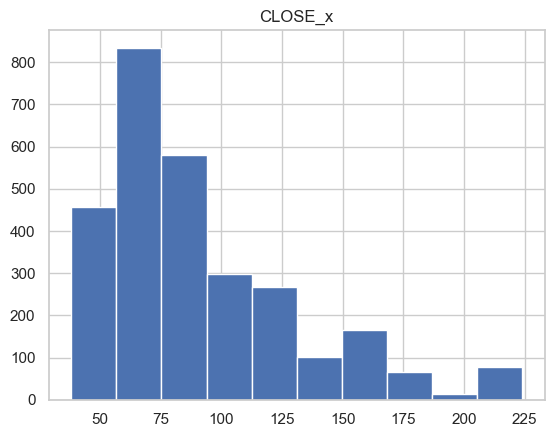

In [385]:
y_train_front_cleaned.hist()

/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


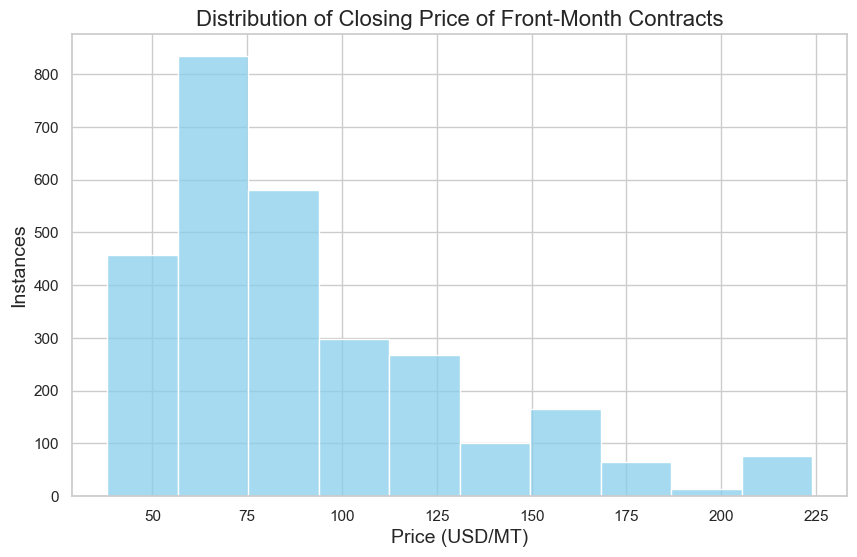

In [386]:
#Revised plot 

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(y_train_front_cleaned['CLOSE_x'], bins=10, color='skyblue')

plt.title('Distribution of Closing Price of Front-Month Contracts', fontsize=16)
plt.xlabel('Price (USD/MT)', fontsize=14)
plt.ylabel('Instances', fontsize=14)

plt.show()

<Axes: >

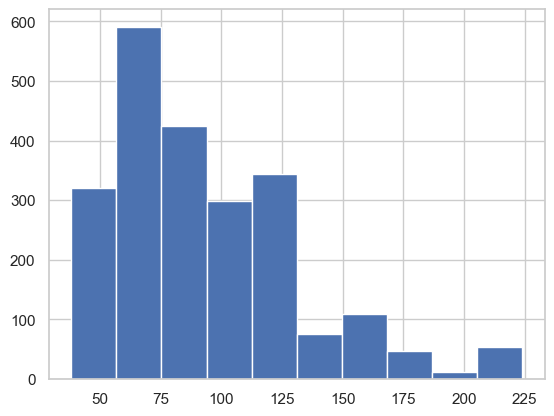

In [387]:
pricing_front['CLOSE'].hist()

/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


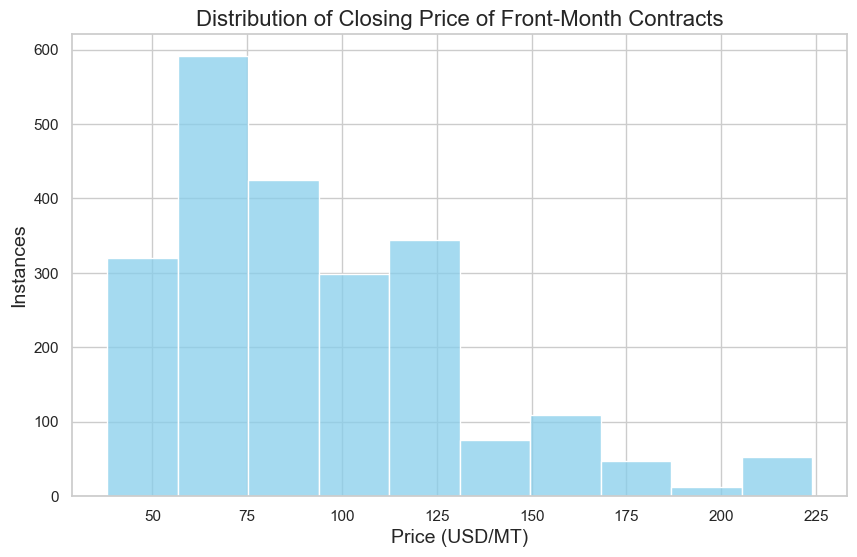

In [388]:
#Revised plot

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(pricing_front['CLOSE'], bins=10, color='skyblue')

plt.title('Distribution of Closing Price of Front-Month Contracts', fontsize=16)
plt.xlabel('Price (USD/MT)', fontsize=14)
plt.ylabel('Instances', fontsize=14)

plt.show()

array([[<Axes: title={'center': 'CLOSE_y'}>]], dtype=object)

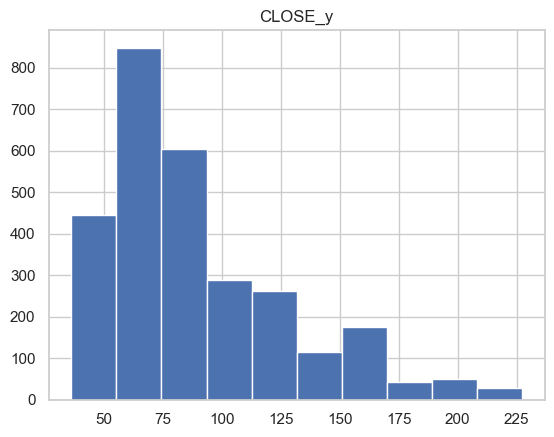

In [389]:
y_train_second_cleaned.hist()

/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


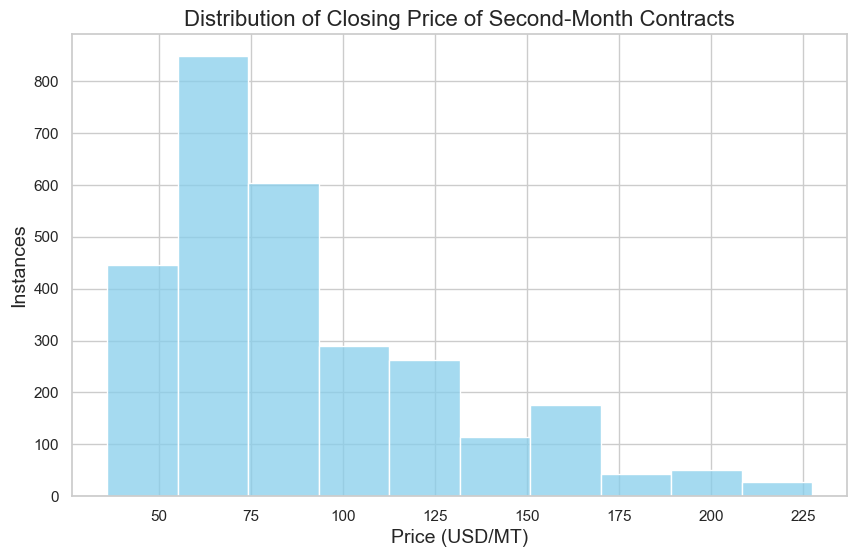

In [390]:
#Revised plot

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(y_train_second_cleaned['CLOSE_y'], bins=10, color='skyblue')

plt.title('Distribution of Closing Price of Second-Month Contracts', fontsize=16)
plt.xlabel('Price (USD/MT)', fontsize=14)
plt.ylabel('Instances', fontsize=14)

plt.show()

<Axes: >

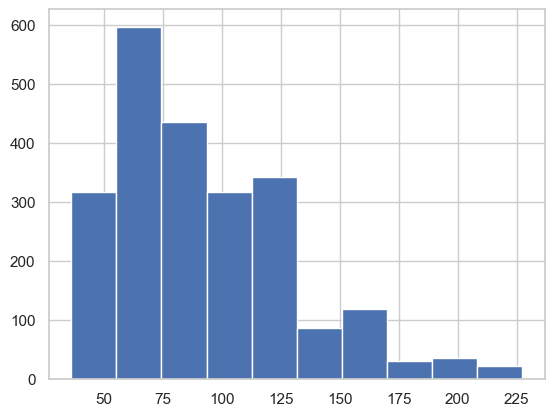

In [391]:
pricing_second['CLOSE'].hist()

/Users/rg/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


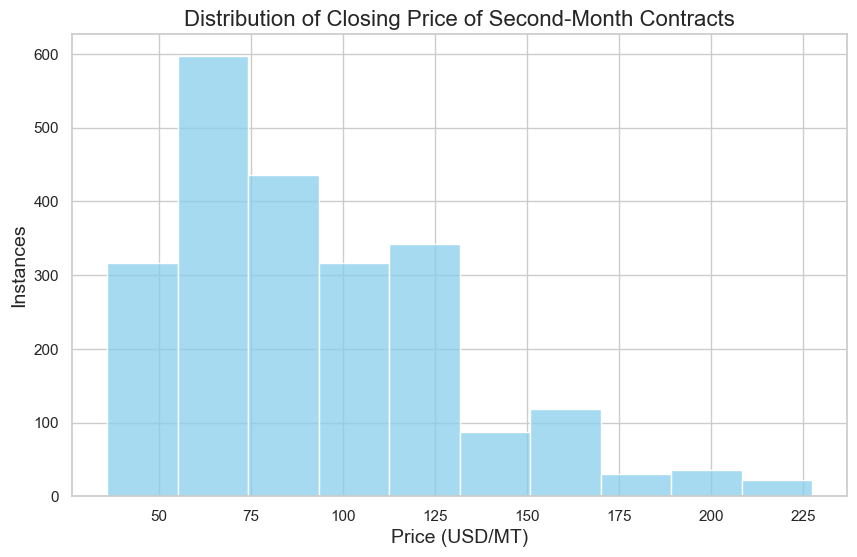

In [392]:
#Revised plot

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(pricing_second['CLOSE'], bins=10, color='skyblue')

plt.title('Distribution of Closing Price of Second-Month Contracts', fontsize=16)
plt.xlabel('Price (USD/MT)', fontsize=14)
plt.ylabel('Instances', fontsize=14)

plt.show()

The distributions follow the same general pattern of right-skewness with a bit of smoothening as the price values increase

### Filling missing values in sentiment columns

In [404]:
X_train_front_cleaned.columns

Index(['HIGH_x', 'LOW_x', 'OPEN_x', 'VOLUME_x', 'HIGH_y', 'LOW_y', 'OPEN_y',
       'CLOSE_y', 'VOLUME_y', 'Overall Sentiment', 'flows_daily_total',
       'china_daily_import', 'row_daily_import', 'aus_daily_export',
       'brazil_daily_export', 'row_daily_export', 'polarity_avg_daily',
       'article_count_daily', 'stocks_daily'],
      dtype='object')

In [405]:
X_train_front_cleaned[X_train_front_cleaned['polarity_avg_daily'].isna()]

HIGH_x      LOW_x     OPEN_x    VOLUME_x  HIGH_y  LOW_y  \
Date                                                                     
2015-01-02  71.750000  71.750000  71.750000    5.000000   71.52  69.97   
2015-01-03  71.750000  71.750000  71.750000    5.000000   71.52  69.97   
2015-01-04  71.750000  71.750000  71.750000    5.000000   71.52  69.97   
2015-01-05  71.750000  71.750000  71.750000    5.000000   71.52  69.97   
2015-01-06  71.750000  71.750000  71.750000    5.000000   71.52  69.97   
...               ...        ...        ...         ...     ...    ...   
2022-10-22  94.825000  94.100000  94.625000  449.000000   91.75  89.70   
2022-10-23  94.825000  94.100000  94.625000  449.000000   91.75  89.70   
2022-10-25  94.325000  93.925000  94.125000   53.500000   90.95  88.20   
2022-10-29  93.016667  92.616667  92.983333  417.333333   82.60  78.80   
2022-10-31  92.650000  92.250000  92.600000  575.000000   80.50  75.00   

            OPEN_y  CLOSE_y  VOLUME_y Overall Sentiment  flows_daily_total  \
Date                                                                         
2015-01-02   69.97    70.25      67.0               NaN       2.561038e+06   
2015-01-03   69.97    70.25      67.0               NaN       1.277684e+06   
2015-01-04   69.97    70.25      67.0               NaN       1.996771e+06   
2015-01-05   69.97    69.41      67.0               NaN       1.379357e+07   
2015-01-06   69.97    71.19      67.0               NaN       1.595791e+06   
...            ...      ...       ...               ...                ...   
2022-10-22   90.15    90.82   27716.0               NaN       3.367031e+06   
2022-10-23   90.15    90.82   27716.0               NaN       2.809357e+06   
2022-10-25   90.55    88.79   50412.0               NaN       3.067098e+06   
2022-10-29   82.55    80.69   76203.0               NaN       2.370509e+06   
2022-10-31   80.20    78.57   17191.0               NaN       2.793603e+07   

            china_daily_import  row_daily_import  aus_daily_export  \
Date                                                                 
2015-01-02        1.775969e+06        785069.436      2.088850e+06   
2015-01-03        9.677652e+05        309918.644      1.208866e+06   
2015-01-04        1.669956e+06        326815.163      1.257124e+06   
2015-01-05        8.273903e+06       5519666.376      9.233797e+06   
2015-01-06        8.535047e+05        742286.747      1.277238e+06   
...                        ...               ...               ...   
2022-10-22        1.938309e+06       1428722.076      2.105585e+06   
2022-10-23        2.554314e+06        255043.268      2.212152e+06   
2022-10-25        2.738565e+06        328532.787      2.017563e+06   
2022-10-29        2.031363e+06        339145.565      1.714941e+06   
2022-10-31        2.167373e+07       6262303.716      2.008872e+07   

            brazil_daily_export  row_daily_export  polarity_avg_daily  \
Date                                                                    
2015-01-02           331104.000        141084.601                 NaN   
2015-01-03                0.000         68817.734                 NaN   
2015-01-04           614166.235        125480.778                 NaN   
2015-01-05          3519837.000       1039935.033                 NaN   
2015-01-06           106661.810        211891.126                 NaN   
...                         ...               ...                 ...   
2022-10-22          1034263.000        227183.134                 NaN   
2022-10-23           541061.570         56143.268                 NaN   
2022-10-25           705002.336        344532.787                 NaN   
2022-10-29           406442.000        249125.216                 NaN   
2022-10-31          4675804.623       3171505.095                 NaN   

            article_count_daily  stocks_daily  
Date                                           
2015-01-02                    0           NaN  
2015-01-03                    0 

In [406]:
X_test_front_cleaned[X_test_front_cleaned['polarity_avg_daily'].isna()]

HIGH_x   LOW_x  OPEN_x  VOLUME_x   HIGH_y   LOW_y  OPEN_y  \
Date                                                                    
2022-10-31   92.65   92.25   92.60     575.0   80.500   75.00   80.20   
2022-11-02   83.05   79.45   80.00   20200.0   81.450   77.65   78.45   
2022-11-04   93.00   82.80   83.30   26527.0   85.125   81.80   83.40   
2022-11-05   93.00   82.80   83.30   26527.0   85.125   81.80   83.40   
2022-11-06   93.00   82.80   83.30   26527.0   85.125   81.80   83.40   
...            ...     ...     ...       ...      ...     ...     ...   
2023-10-23  117.30  116.65  117.30     481.0  113.550  110.70  112.60   
2023-10-28  118.90  118.50  118.65    1928.0  120.000  115.75  116.60   
2023-10-29  118.90  118.50  118.65    1928.0  120.000  115.75  116.60   
2023-10-30  118.95  118.75  118.85      50.0  122.000  120.45  121.80   
2023-11-03  126.20  124.05  124.55    5351.0  123.800  121.60  122.80   

            CLOSE_y  VOLUME_y Overall Sentiment  flows_daily_total  \
Date                                                                 
2022-10-31    78.57   17191.0               NaN        3822183.097   
2022-11-02    80.52   52080.0               NaN        3070751.500   
2022-11-04    85.95   47403.0               NaN        2666177.592   
2022-11-05    85.95   47403.0               NaN        2745872.120   
2022-11-06    85.95   47403.0               NaN        2435314.237   
...             ...       ...               ...                ...   
2023-10-23   112.77   54999.0               NaN        2637481.246   
2023-10-28   119.67   82671.0               NaN        2592363.582   
2023-10-29   119.67   82671.0               NaN        2184833.389   
2023-10-30   121.72   16919.0               NaN        2720786.491   
2023-11-03   122.94   42420.0               NaN        2848908.638   

            china_daily_import  row_daily_import  aus_daily_export  \
Date                                                                 
2022-10-31         1202452.918       2619730.179       1202452.918   
2022-11-02         2226891.935        843859.565       2195252.795   
2022-11-04         2255212.698        410964.894       2190926.186   
2022-11-05         2353583.207        392288.913       2030420.803   
2022-11-06         1555557.858        879756.379       1915324.973   
...                        ...               ...               ...   
2023-10-23         2072804.968        564676.278       2016476.929   
2023-10-28         2307917.065        284446.517       2202573.414   
2023-10-29         1643116.928        541716.461       1577108.178   
2023-10-30         2361672.868        359113.623       2276327.097   
2023-11-03         2066972.633        781936.005       1598911.095   

            brazil_daily_export  row_daily_export  polarity_avg_daily  \
Date                                                                    
2022-10-31          2619730.179             0.000                 NaN   
2022-11-02           494033.801        381464.904                 NaN   
2022-11-04           420695.877         54555.529                 NaN   
2022-11-05           349105.638        366345.679                 NaN   
2022-11-06           161620.620        358368.644                 NaN   
...                         ...               ...                 ...   
2023-10-23           335349.179        285655.138                 NaN   
2023-10-28           175852.601        213937.567                 NaN   
2023-10-29           394808.000        212917.211                 NaN   
2023-10-30           174757.928        269701.466                 NaN   
2023-11-03           741237.479        508760.064                 NaN   

            article_count_daily  stocks_daily  
Date                                           
2022-10-31                    0      0.065459  
2022-11-02                    0      0.065459  
2022-11-04                    0      0.065459  
2022-11-05                    0      0.065459  
20

In [407]:
X_train_second_cleaned[X_train_second_cleaned['polarity_avg_daily'].isna()]

HIGH_x      LOW_x     OPEN_x  CLOSE_x    VOLUME_x  HIGH_y  \
Date                                                                       
2015-01-02  71.750000  71.750000  71.750000    70.67    5.000000   71.52   
2015-01-03  71.750000  71.750000  71.750000    70.67    5.000000   71.52   
2015-01-04  71.750000  71.750000  71.750000    70.67    5.000000   71.52   
2015-01-05  71.750000  71.750000  71.750000    69.94    5.000000   71.52   
2015-01-06  71.750000  71.750000  71.750000    71.64    5.000000   71.52   
...               ...        ...        ...      ...         ...     ...   
2022-10-22  94.825000  94.100000  94.625000    94.45  449.000000   91.75   
2022-10-23  94.825000  94.100000  94.625000    94.45  449.000000   91.75   
2022-10-25  94.325000  93.925000  94.125000    93.88   53.500000   90.95   
2022-10-29  93.016667  92.616667  92.983333    92.59  417.333333   82.60   
2022-10-31  92.650000  92.250000  92.600000    92.43  575.000000   80.50   

            LOW_y  OPEN_y  VOLUME_y Overall Sentiment  flows_daily_total  \
Date                                                                       
2015-01-02  69.97   69.97      67.0               NaN       2.561038e+06   
2015-01-03  69.97   69.97      67.0               NaN       1.277684e+06   
2015-01-04  69.97   69.97      67.0               NaN       1.996771e+06   
2015-01-05  69.97   69.97      67.0               NaN       1.379357e+07   
2015-01-06  69.97   69.97      67.0               NaN       1.595791e+06   
...           ...     ...       ...               ...                ...   
2022-10-22  89.70   90.15   27716.0               NaN       3.367031e+06   
2022-10-23  89.70   90.15   27716.0               NaN       2.809357e+06   
2022-10-25  88.20   90.55   50412.0               NaN       3.067098e+06   
2022-10-29  78.80   82.55   76203.0               NaN       2.370509e+06   
2022-10-31  75.00   80.20   17191.0               NaN       2.793603e+07   

            china_daily_import  row_daily_import  aus_daily_export  \
Date                                                                 
2015-01-02        1.775969e+06        785069.436      2.088850e+06   
2015-01-03        9.677652e+05        309918.644      1.208866e+06   
2015-01-04        1.669956e+06        326815.163      1.257124e+06   
2015-01-05        8.273903e+06       5519666.376      9.233797e+06   
2015-01-06        8.535047e+05        742286.747      1.277238e+06   
...                        ...               ...               ...   
2022-10-22        1.938309e+06       1428722.076      2.105585e+06   
2022-10-23        2.554314e+06        255043.268      2.212152e+06   
2022-10-25        2.738565e+06        328532.787      2.017563e+06   
2022-10-29        2.031363e+06        339145.565      1.714941e+06   
2022-10-31        2.167373e+07       6262303.716      2.008872e+07   

            brazil_daily_export  row_daily_export  polarity_avg_daily  \
Date                                                                    
2015-01-02           331104.000        141084.601                 NaN   
2015-01-03                0.000         68817.734                 NaN   
2015-01-04           614166.235        125480.778                 NaN   
2015-01-05          3519837.000       1039935.033                 NaN   
2015-01-06           106661.810        211891.126                 NaN   
...                         ...               ...                 ...   
2022-10-22          1034263.000        227183.134                 NaN   
2022-10-23           541061.570         56143.268                 NaN   
2022-10-25           705002.336        344532.787                 NaN   
2022-10-29           406442.000        249125.216                 NaN   
2022-10-31          4675804.623       3171505.095                 NaN   

            article_count_daily  stocks_daily  
Date                                           
2015-01-02                    0           NaN  
2015-01-03                    0 

In [408]:
X_test_front_cleaned[X_test_front_cleaned['polarity_avg_daily'].isna()]

HIGH_x   LOW_x  OPEN_x  VOLUME_x   HIGH_y   LOW_y  OPEN_y  \
Date                                                                    
2022-10-31   92.65   92.25   92.60     575.0   80.500   75.00   80.20   
2022-11-02   83.05   79.45   80.00   20200.0   81.450   77.65   78.45   
2022-11-04   93.00   82.80   83.30   26527.0   85.125   81.80   83.40   
2022-11-05   93.00   82.80   83.30   26527.0   85.125   81.80   83.40   
2022-11-06   93.00   82.80   83.30   26527.0   85.125   81.80   83.40   
...            ...     ...     ...       ...      ...     ...     ...   
2023-10-23  117.30  116.65  117.30     481.0  113.550  110.70  112.60   
2023-10-28  118.90  118.50  118.65    1928.0  120.000  115.75  116.60   
2023-10-29  118.90  118.50  118.65    1928.0  120.000  115.75  116.60   
2023-10-30  118.95  118.75  118.85      50.0  122.000  120.45  121.80   
2023-11-03  126.20  124.05  124.55    5351.0  123.800  121.60  122.80   

            CLOSE_y  VOLUME_y Overall Sentiment  flows_daily_total  \
Date                                                                 
2022-10-31    78.57   17191.0               NaN        3822183.097   
2022-11-02    80.52   52080.0               NaN        3070751.500   
2022-11-04    85.95   47403.0               NaN        2666177.592   
2022-11-05    85.95   47403.0               NaN        2745872.120   
2022-11-06    85.95   47403.0               NaN        2435314.237   
...             ...       ...               ...                ...   
2023-10-23   112.77   54999.0               NaN        2637481.246   
2023-10-28   119.67   82671.0               NaN        2592363.582   
2023-10-29   119.67   82671.0               NaN        2184833.389   
2023-10-30   121.72   16919.0               NaN        2720786.491   
2023-11-03   122.94   42420.0               NaN        2848908.638   

            china_daily_import  row_daily_import  aus_daily_export  \
Date                                                                 
2022-10-31         1202452.918       2619730.179       1202452.918   
2022-11-02         2226891.935        843859.565       2195252.795   
2022-11-04         2255212.698        410964.894       2190926.186   
2022-11-05         2353583.207        392288.913       2030420.803   
2022-11-06         1555557.858        879756.379       1915324.973   
...                        ...               ...               ...   
2023-10-23         2072804.968        564676.278       2016476.929   
2023-10-28         2307917.065        284446.517       2202573.414   
2023-10-29         1643116.928        541716.461       1577108.178   
2023-10-30         2361672.868        359113.623       2276327.097   
2023-11-03         2066972.633        781936.005       1598911.095   

            brazil_daily_export  row_daily_export  polarity_avg_daily  \
Date                                                                    
2022-10-31          2619730.179             0.000                 NaN   
2022-11-02           494033.801        381464.904                 NaN   
2022-11-04           420695.877         54555.529                 NaN   
2022-11-05           349105.638        366345.679                 NaN   
2022-11-06           161620.620        358368.644                 NaN   
...                         ...               ...                 ...   
2023-10-23           335349.179        285655.138                 NaN   
2023-10-28           175852.601        213937.567                 NaN   
2023-10-29           394808.000        212917.211                 NaN   
2023-10-30           174757.928        269701.466                 NaN   
2023-11-03           741237.479        508760.064                 NaN   

            article_count_daily  stocks_daily  
Date                                           
2022-10-31                    0      0.065459  
2022-11-02                    0      0.065459  
2022-11-04                    0      0.065459  
2022-11-05                    0      0.065459  
20

We observe that for all columns where the average sentiment score is null, the article count is zero and therefore no articles have been published in those weeks. We will fill these null values with the fixed-value '0'

In [409]:
#Filling using fixed-values 
X_train_front_cleaned.loc[:,'polarity_avg_daily'] = X_train_front_cleaned['polarity_avg_daily'].fillna(0)
X_test_front_cleaned.loc[:,'polarity_avg_daily'] = X_test_front_cleaned['polarity_avg_daily'].fillna(0)


## Second-month 
X_train_second_cleaned.loc[:,'polarity_avg_daily'] = X_train_second_cleaned['polarity_avg_daily'].fillna(0)
X_test_second_cleaned.loc[:,'polarity_avg_daily'] = X_test_second_cleaned['polarity_avg_daily'].fillna(0)

In [410]:
#Filling categorical column using condition-based values

conditions = [
    X_train_front_cleaned['polarity_avg_daily'] != 0,   # Condition for non-neutral
    X_train_front_cleaned['polarity_avg_daily'] == 0,   # Condition for neutral
]
choices = ['Non-neutral', 'Neutral']

X_train_front_cleaned.loc[:,'Overall Sentiment'] = np.select(conditions, choices) 

In [411]:
#Filling categorical column using condition-based values

conditions = [
    X_test_front_cleaned['polarity_avg_daily'] != 0,   # Condition for non-neutral
    X_test_front_cleaned['polarity_avg_daily'] == 0,   # Condition for neutral
]
choices = ['Non-neutral', 'Neutral']

X_test_front_cleaned.loc[:,'Overall Sentiment'] = np.select(conditions, choices) 

In [412]:
X_train_front_cleaned.isnull().sum() #code to check

HIGH_x                 0
LOW_x                  0
OPEN_x                 0
VOLUME_x               0
HIGH_y                 0
LOW_y                  0
OPEN_y                 0
CLOSE_y                0
VOLUME_y               0
Overall Sentiment      0
flows_daily_total      0
china_daily_import     0
row_daily_import       0
aus_daily_export       0
brazil_daily_export    0
row_daily_export       0
polarity_avg_daily     0
article_count_daily    0
stocks_daily           3
dtype: int64

In [413]:
#Filling categorical column using condition-based values

conditions = [
    X_train_second_cleaned['polarity_avg_daily'] != 0,   # Condition for non-neutral
    X_train_second_cleaned['polarity_avg_daily'] == 0,   # Condition for neutral
]
choices = ['Non-neutral', 'Neutral']

X_train_second_cleaned.loc[:,'Overall Sentiment'] = np.select(conditions, choices) 

In [414]:
#Filling categorical column using condition-based values

conditions = [
    X_test_second_cleaned['polarity_avg_daily'] != 0,   # Condition for non-neutral
    X_test_second_cleaned['polarity_avg_daily'] == 0,   # Condition for neutral
]
choices = ['Non-neutral', 'Neutral']

X_test_second_cleaned.loc[:,'Overall Sentiment'] = np.select(conditions, choices) 

In [415]:
X_train_front_cleaned.info() #code to check

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2860 entries, 2015-01-02 to 2022-10-31
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HIGH_x               2860 non-null   float64
 1   LOW_x                2860 non-null   float64
 2   OPEN_x               2860 non-null   float64
 3   VOLUME_x             2860 non-null   float64
 4   HIGH_y               2860 non-null   float64
 5   LOW_y                2860 non-null   float64
 6   OPEN_y               2860 non-null   float64
 7   CLOSE_y              2860 non-null   float64
 8   VOLUME_y             2860 non-null   float64
 9   Overall Sentiment    2860 non-null   object 
 10  flows_daily_total    2860 non-null   float64
 11  china_daily_import   2860 non-null   float64
 12  row_daily_import     2860 non-null   float64
 13  aus_daily_export     2860 non-null   float64
 14  brazil_daily_export  2860 non-null   float64
 15  row_daily_export    

In [416]:
X_test_front_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 369 entries, 2022-10-31 to 2023-11-03
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HIGH_x               369 non-null    float64
 1   LOW_x                369 non-null    float64
 2   OPEN_x               369 non-null    float64
 3   VOLUME_x             369 non-null    float64
 4   HIGH_y               369 non-null    float64
 5   LOW_y                369 non-null    float64
 6   OPEN_y               369 non-null    float64
 7   CLOSE_y              369 non-null    float64
 8   VOLUME_y             369 non-null    float64
 9   Overall Sentiment    369 non-null    object 
 10  flows_daily_total    369 non-null    float64
 11  china_daily_import   369 non-null    float64
 12  row_daily_import     369 non-null    float64
 13  aus_daily_export     369 non-null    float64
 14  brazil_daily_export  369 non-null    float64
 15  row_daily_export     

In [417]:
X_train_second_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2860 entries, 2015-01-02 to 2022-10-31
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HIGH_x               2860 non-null   float64
 1   LOW_x                2860 non-null   float64
 2   OPEN_x               2860 non-null   float64
 3   CLOSE_x              2860 non-null   float64
 4   VOLUME_x             2860 non-null   float64
 5   HIGH_y               2860 non-null   float64
 6   LOW_y                2860 non-null   float64
 7   OPEN_y               2860 non-null   float64
 8   VOLUME_y             2860 non-null   float64
 9   Overall Sentiment    2860 non-null   object 
 10  flows_daily_total    2860 non-null   float64
 11  china_daily_import   2860 non-null   float64
 12  row_daily_import     2860 non-null   float64
 13  aus_daily_export     2860 non-null   float64
 14  brazil_daily_export  2860 non-null   float64
 15  row_daily_export    

In [418]:
X_test_second_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 369 entries, 2022-10-31 to 2023-11-03
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HIGH_x               369 non-null    float64
 1   LOW_x                369 non-null    float64
 2   OPEN_x               369 non-null    float64
 3   CLOSE_x              369 non-null    float64
 4   VOLUME_x             369 non-null    float64
 5   HIGH_y               369 non-null    float64
 6   LOW_y                369 non-null    float64
 7   OPEN_y               369 non-null    float64
 8   VOLUME_y             369 non-null    float64
 9   Overall Sentiment    369 non-null    object 
 10  flows_daily_total    369 non-null    float64
 11  china_daily_import   369 non-null    float64
 12  row_daily_import     369 non-null    float64
 13  aus_daily_export     369 non-null    float64
 14  brazil_daily_export  369 non-null    float64
 15  row_daily_export     

### Filling missing values in stocks column 

In [419]:
X_train_front_cleaned['stocks_daily'] = X_train_front_cleaned['stocks_daily'].bfill()

In [420]:
X_train_second_cleaned['stocks_daily'] = X_train_second_cleaned['stocks_daily'].bfill()

In [421]:
X_train_front_cleaned.isna().sum()

HIGH_x                 0
LOW_x                  0
OPEN_x                 0
VOLUME_x               0
HIGH_y                 0
LOW_y                  0
OPEN_y                 0
CLOSE_y                0
VOLUME_y               0
Overall Sentiment      0
flows_daily_total      0
china_daily_import     0
row_daily_import       0
aus_daily_export       0
brazil_daily_export    0
row_daily_export       0
polarity_avg_daily     0
article_count_daily    0
stocks_daily           0
dtype: int64

### Checking post-fill correlations

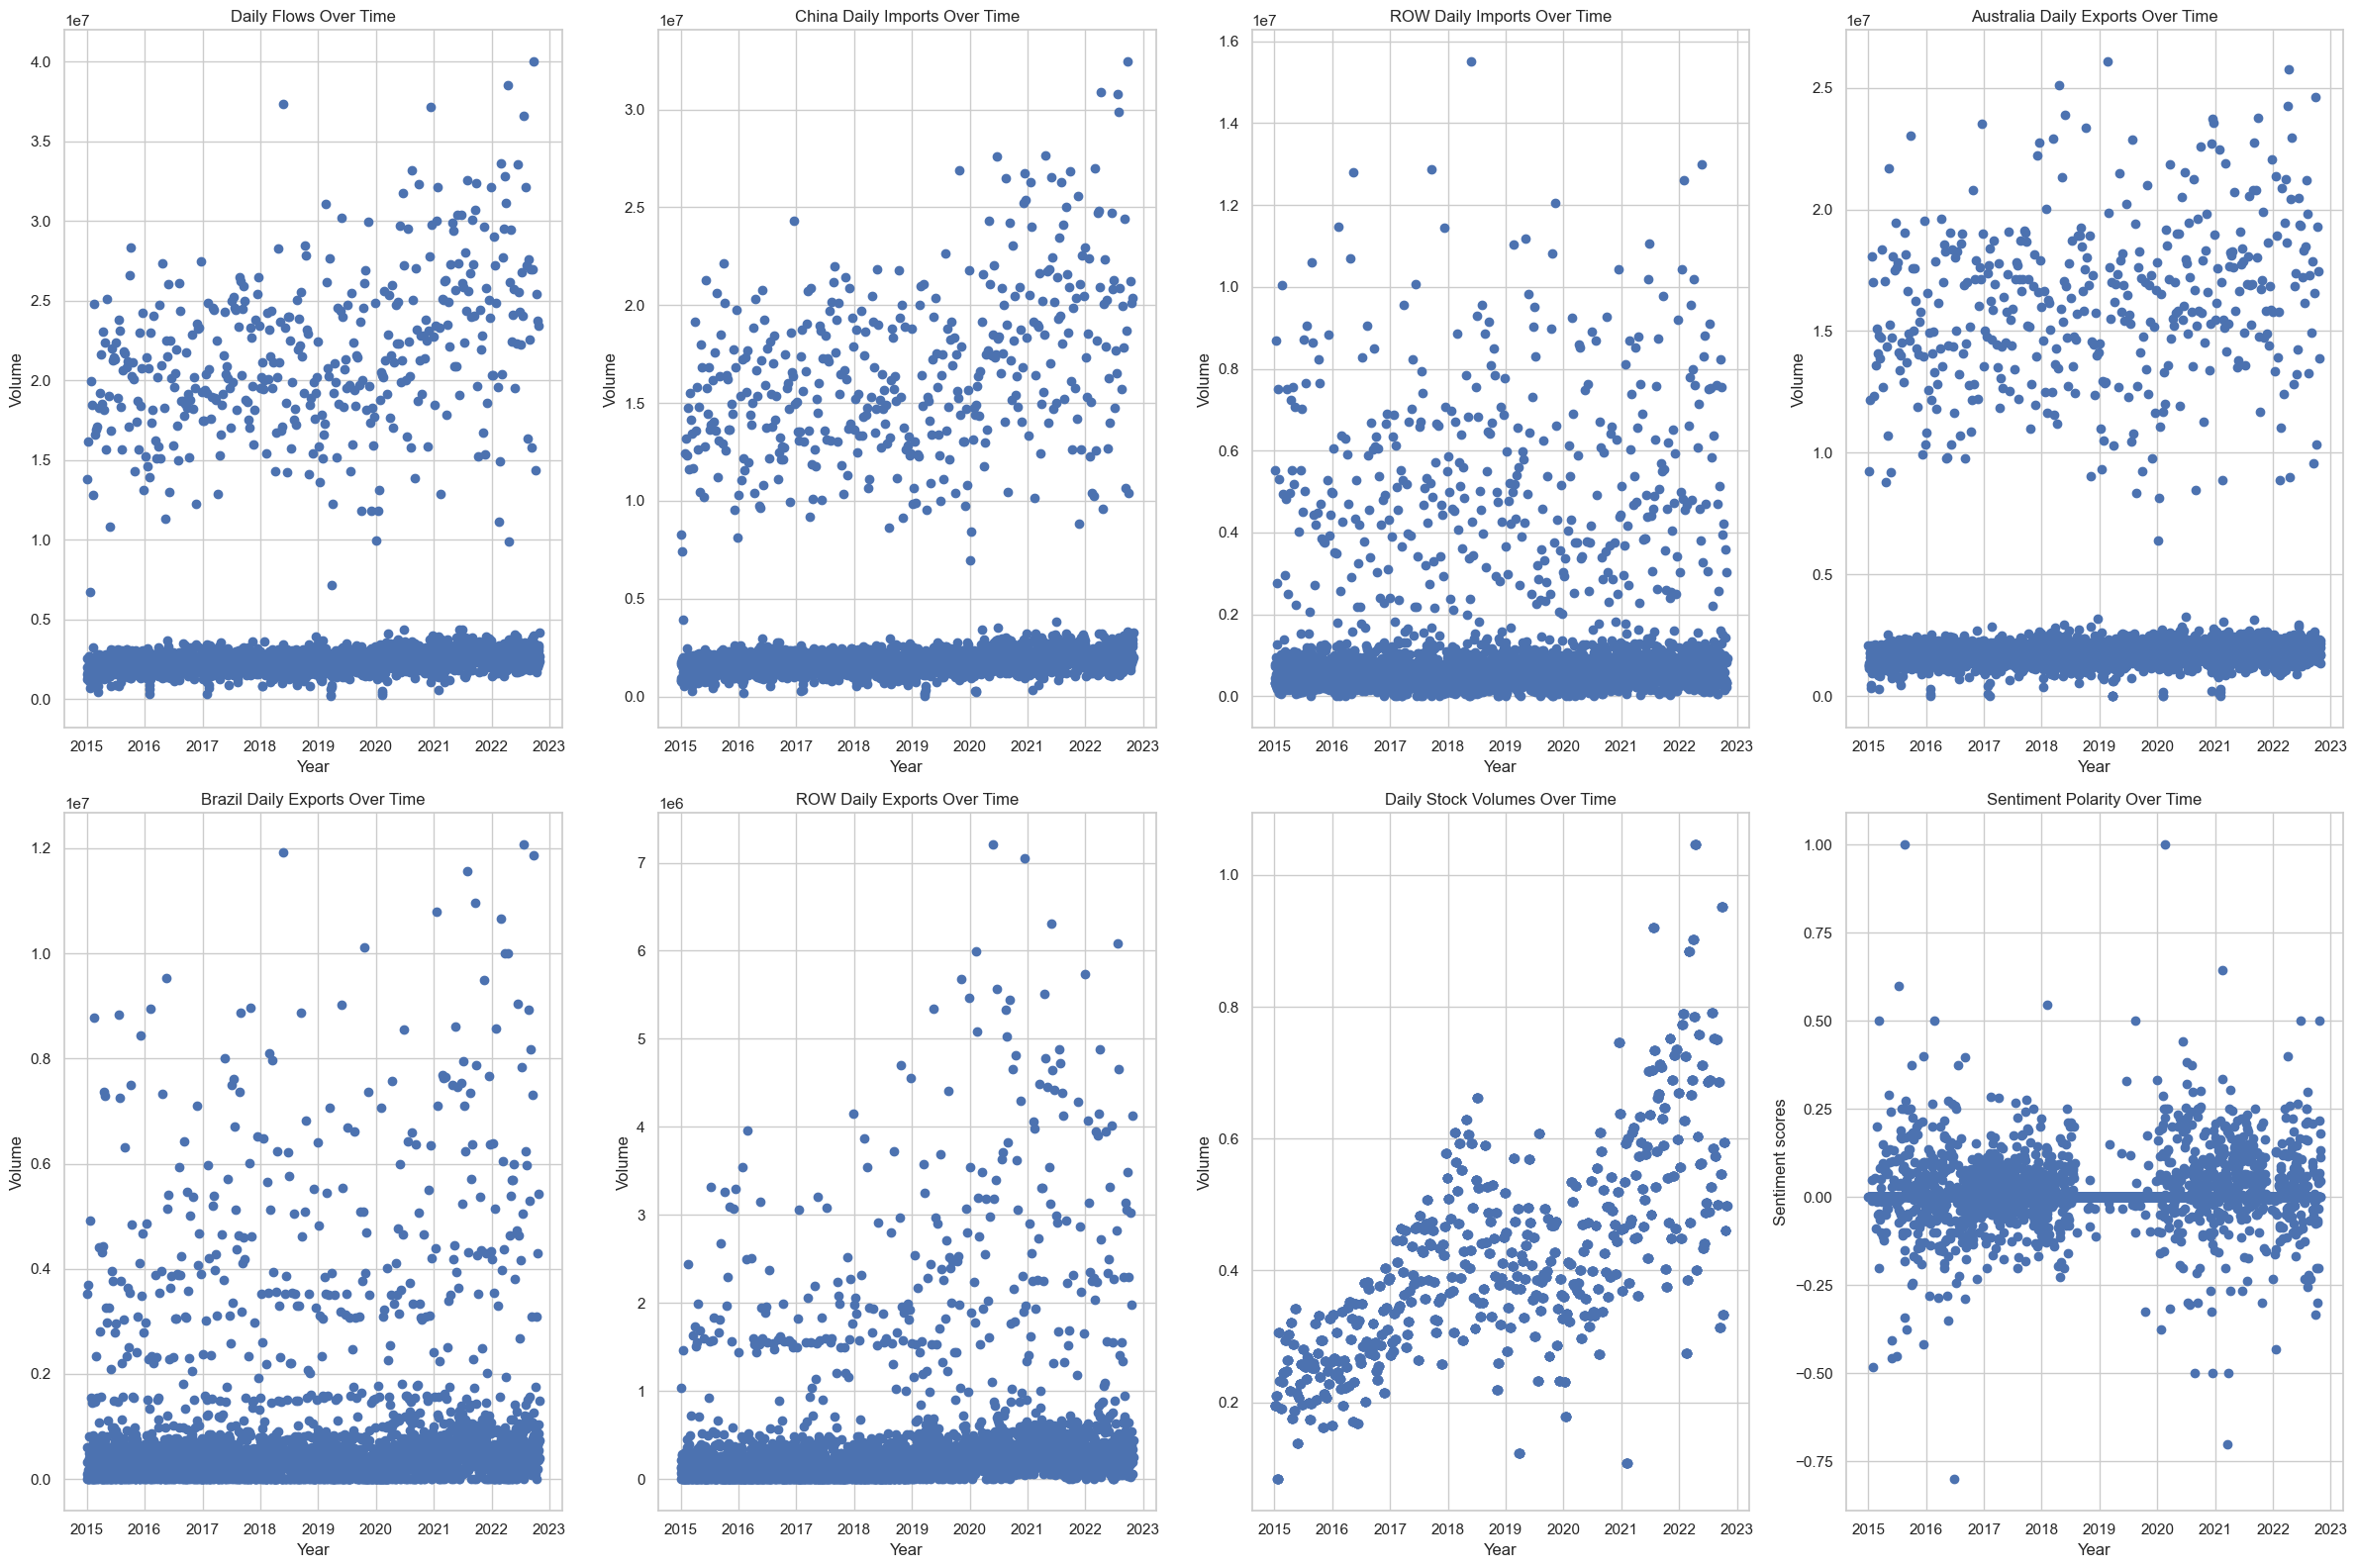

In [458]:
#Time-series of cleaned data columns 

#Visualisation for the report


# Defining the figure and subplots
fig, axs = plt.subplots(2, 4, figsize=(24, 16))  


# Plotting Flows Volumes over time
axs[0, 0].scatter(X_train_front_cleaned['Date'], X_train_front_cleaned['flows_daily_total'])
axs[0, 0].set_title('Daily Flows Over Time')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Volume')

# Plotting China Imports over time
axs[0, 1].scatter(X_train_front_cleaned['Date'], X_train_front_cleaned['china_daily_import'])
axs[0, 1].set_title('China Daily Imports Over Time')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Volume')

# Plotting ROW Imports over time
axs[0, 2].scatter(X_train_front_cleaned['Date'], X_train_front_cleaned['row_daily_import'])
axs[0, 2].set_title('ROW Daily Imports Over Time')
axs[0, 2].set_xlabel('Year')
axs[0, 2].set_ylabel('Volume')

# Plotting Australia Exports over time
axs[0, 3].scatter(X_train_front_cleaned['Date'], X_train_front_cleaned['aus_daily_export'])
axs[0, 3].set_title('Australia Daily Exports Over Time')
axs[0, 3].set_xlabel('Year')
axs[0, 3].set_ylabel('Volume')

# Plotting Brazil Exports over time
axs[1, 0].scatter(X_train_front_cleaned['Date'], X_train_front_cleaned['brazil_daily_export'])
axs[1, 0].set_title('Brazil Daily Exports Over Time')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Volume')

# Plotting ROW Exports over time
axs[1, 1].scatter(X_train_front_cleaned['Date'], X_train_front_cleaned['row_daily_export'])
axs[1, 1].set_title('ROW Daily Exports Over Time')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Volume')

# Plotting Stock Volumes over time
axs[1, 2].scatter(X_train_front_cleaned['Date'], X_train_front_cleaned['stocks_daily'])
axs[1, 2].set_title('Daily Stock Volumes Over Time')
axs[1, 2].set_xlabel('Year')
axs[1, 2].set_ylabel('Volume')

# Plotting Sentiment scores over time
axs[1, 3].scatter(X_train_front_cleaned['Date'], X_train_front_cleaned['polarity_avg_daily'])
axs[1, 3].set_title('Sentiment Polarity Over Time')
axs[1, 3].set_xlabel('Year')
axs[1, 3].set_ylabel('Sentiment scores')


# Adjust the subplots layout
plt.tight_layout()

# Show the plot
plt.show()

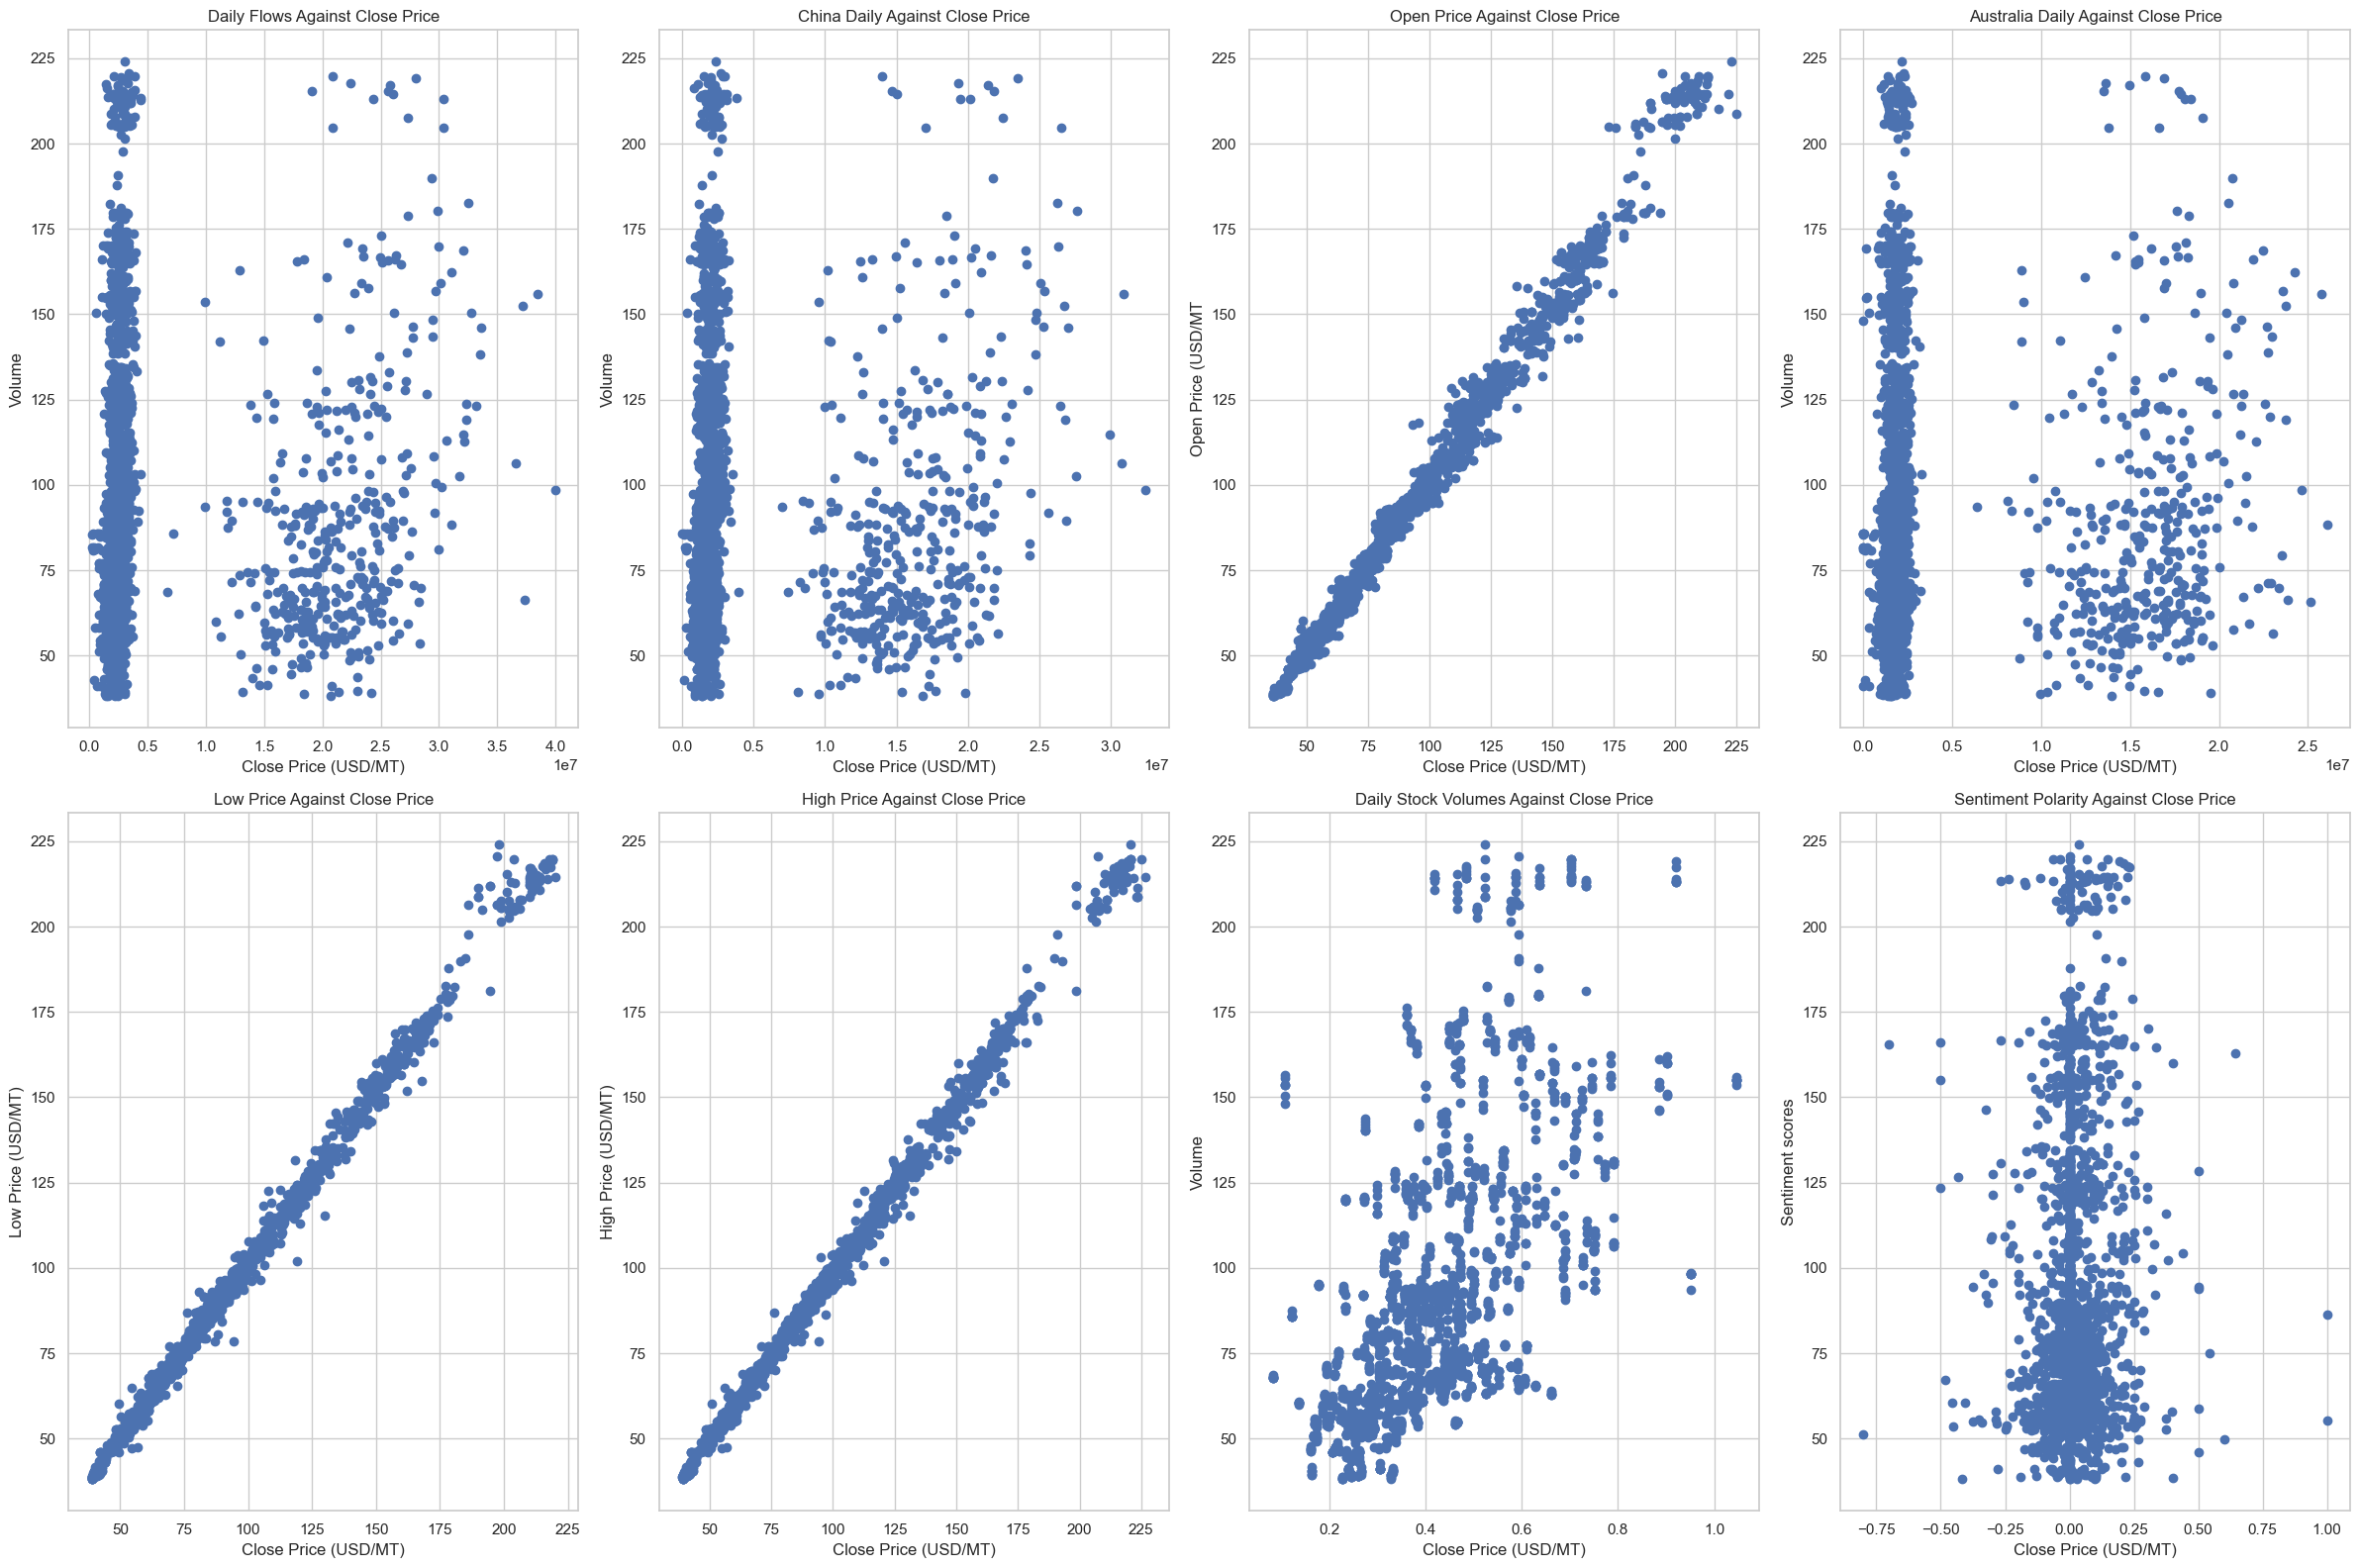

In [459]:
#Visualisation for the report


#Select Correlations with closing-price of front-month


# Defining the figure and subplots
fig, axs = plt.subplots(2, 4, figsize=(24, 16))  


# Plotting Flows Volumes over time
axs[0, 0].scatter(X_train_front_cleaned['flows_daily_total'], y_train_front_cleaned['CLOSE_x'])
axs[0, 0].set_title('Daily Flows Against Close Price')
axs[0, 0].set_xlabel('Close Price (USD/MT)')
axs[0, 0].set_ylabel('Volume')

# Plotting China Imports over time
axs[0, 1].scatter(X_train_front_cleaned['china_daily_import'], y_train_front_cleaned['CLOSE_x'])
axs[0, 1].set_title('China Daily Against Close Price')
axs[0, 1].set_xlabel('Close Price (USD/MT)')
axs[0, 1].set_ylabel('Volume')

# Plotting ROW Imports over time
axs[0, 2].scatter(X_train_front_cleaned['OPEN_y'], y_train_front_cleaned['CLOSE_x'])
axs[0, 2].set_title('Open Price Against Close Price')
axs[0, 2].set_xlabel('Close Price (USD/MT)')
axs[0, 2].set_ylabel('Open Price (USD/MT')

# Plotting Australia Exports over time
axs[0, 3].scatter(X_train_front_cleaned['aus_daily_export'], y_train_front_cleaned['CLOSE_x'])
axs[0, 3].set_title('Australia Daily Against Close Price')
axs[0, 3].set_xlabel('Close Price (USD/MT)')
axs[0, 3].set_ylabel('Volume')

# Plotting Brazil Exports over time
axs[1, 0].scatter(X_train_front_cleaned['LOW_x'], y_train_front_cleaned['CLOSE_x'])
axs[1, 0].set_title('Low Price Against Close Price')
axs[1, 0].set_xlabel('Close Price (USD/MT)')
axs[1, 0].set_ylabel('Low Price (USD/MT)')

# Plotting ROW Exports over time
axs[1, 1].scatter(X_train_front_cleaned['HIGH_x'], y_train_front_cleaned['CLOSE_x'])
axs[1, 1].set_title('High Price Against Close Price')
axs[1, 1].set_xlabel('Close Price (USD/MT)')
axs[1, 1].set_ylabel('High Price (USD/MT)')

# Plotting Stock Volumes over time
axs[1, 2].scatter( X_train_front_cleaned['stocks_daily'], y_train_front_cleaned['CLOSE_x'])
axs[1, 2].set_title('Daily Stock Volumes Against Close Price')
axs[1, 2].set_xlabel('Close Price (USD/MT)')
axs[1, 2].set_ylabel('Volume')

# Plotting Sentiment scores over time
axs[1, 3].scatter(X_train_front_cleaned['polarity_avg_daily'], y_train_front_cleaned['CLOSE_x'])
axs[1, 3].set_title('Sentiment Polarity Against Close Price')
axs[1, 3].set_xlabel('Close Price (USD/MT)')
axs[1, 3].set_ylabel('Sentiment scores')


# Adjust the subplots layout
plt.tight_layout()

# Show the plot
plt.show()

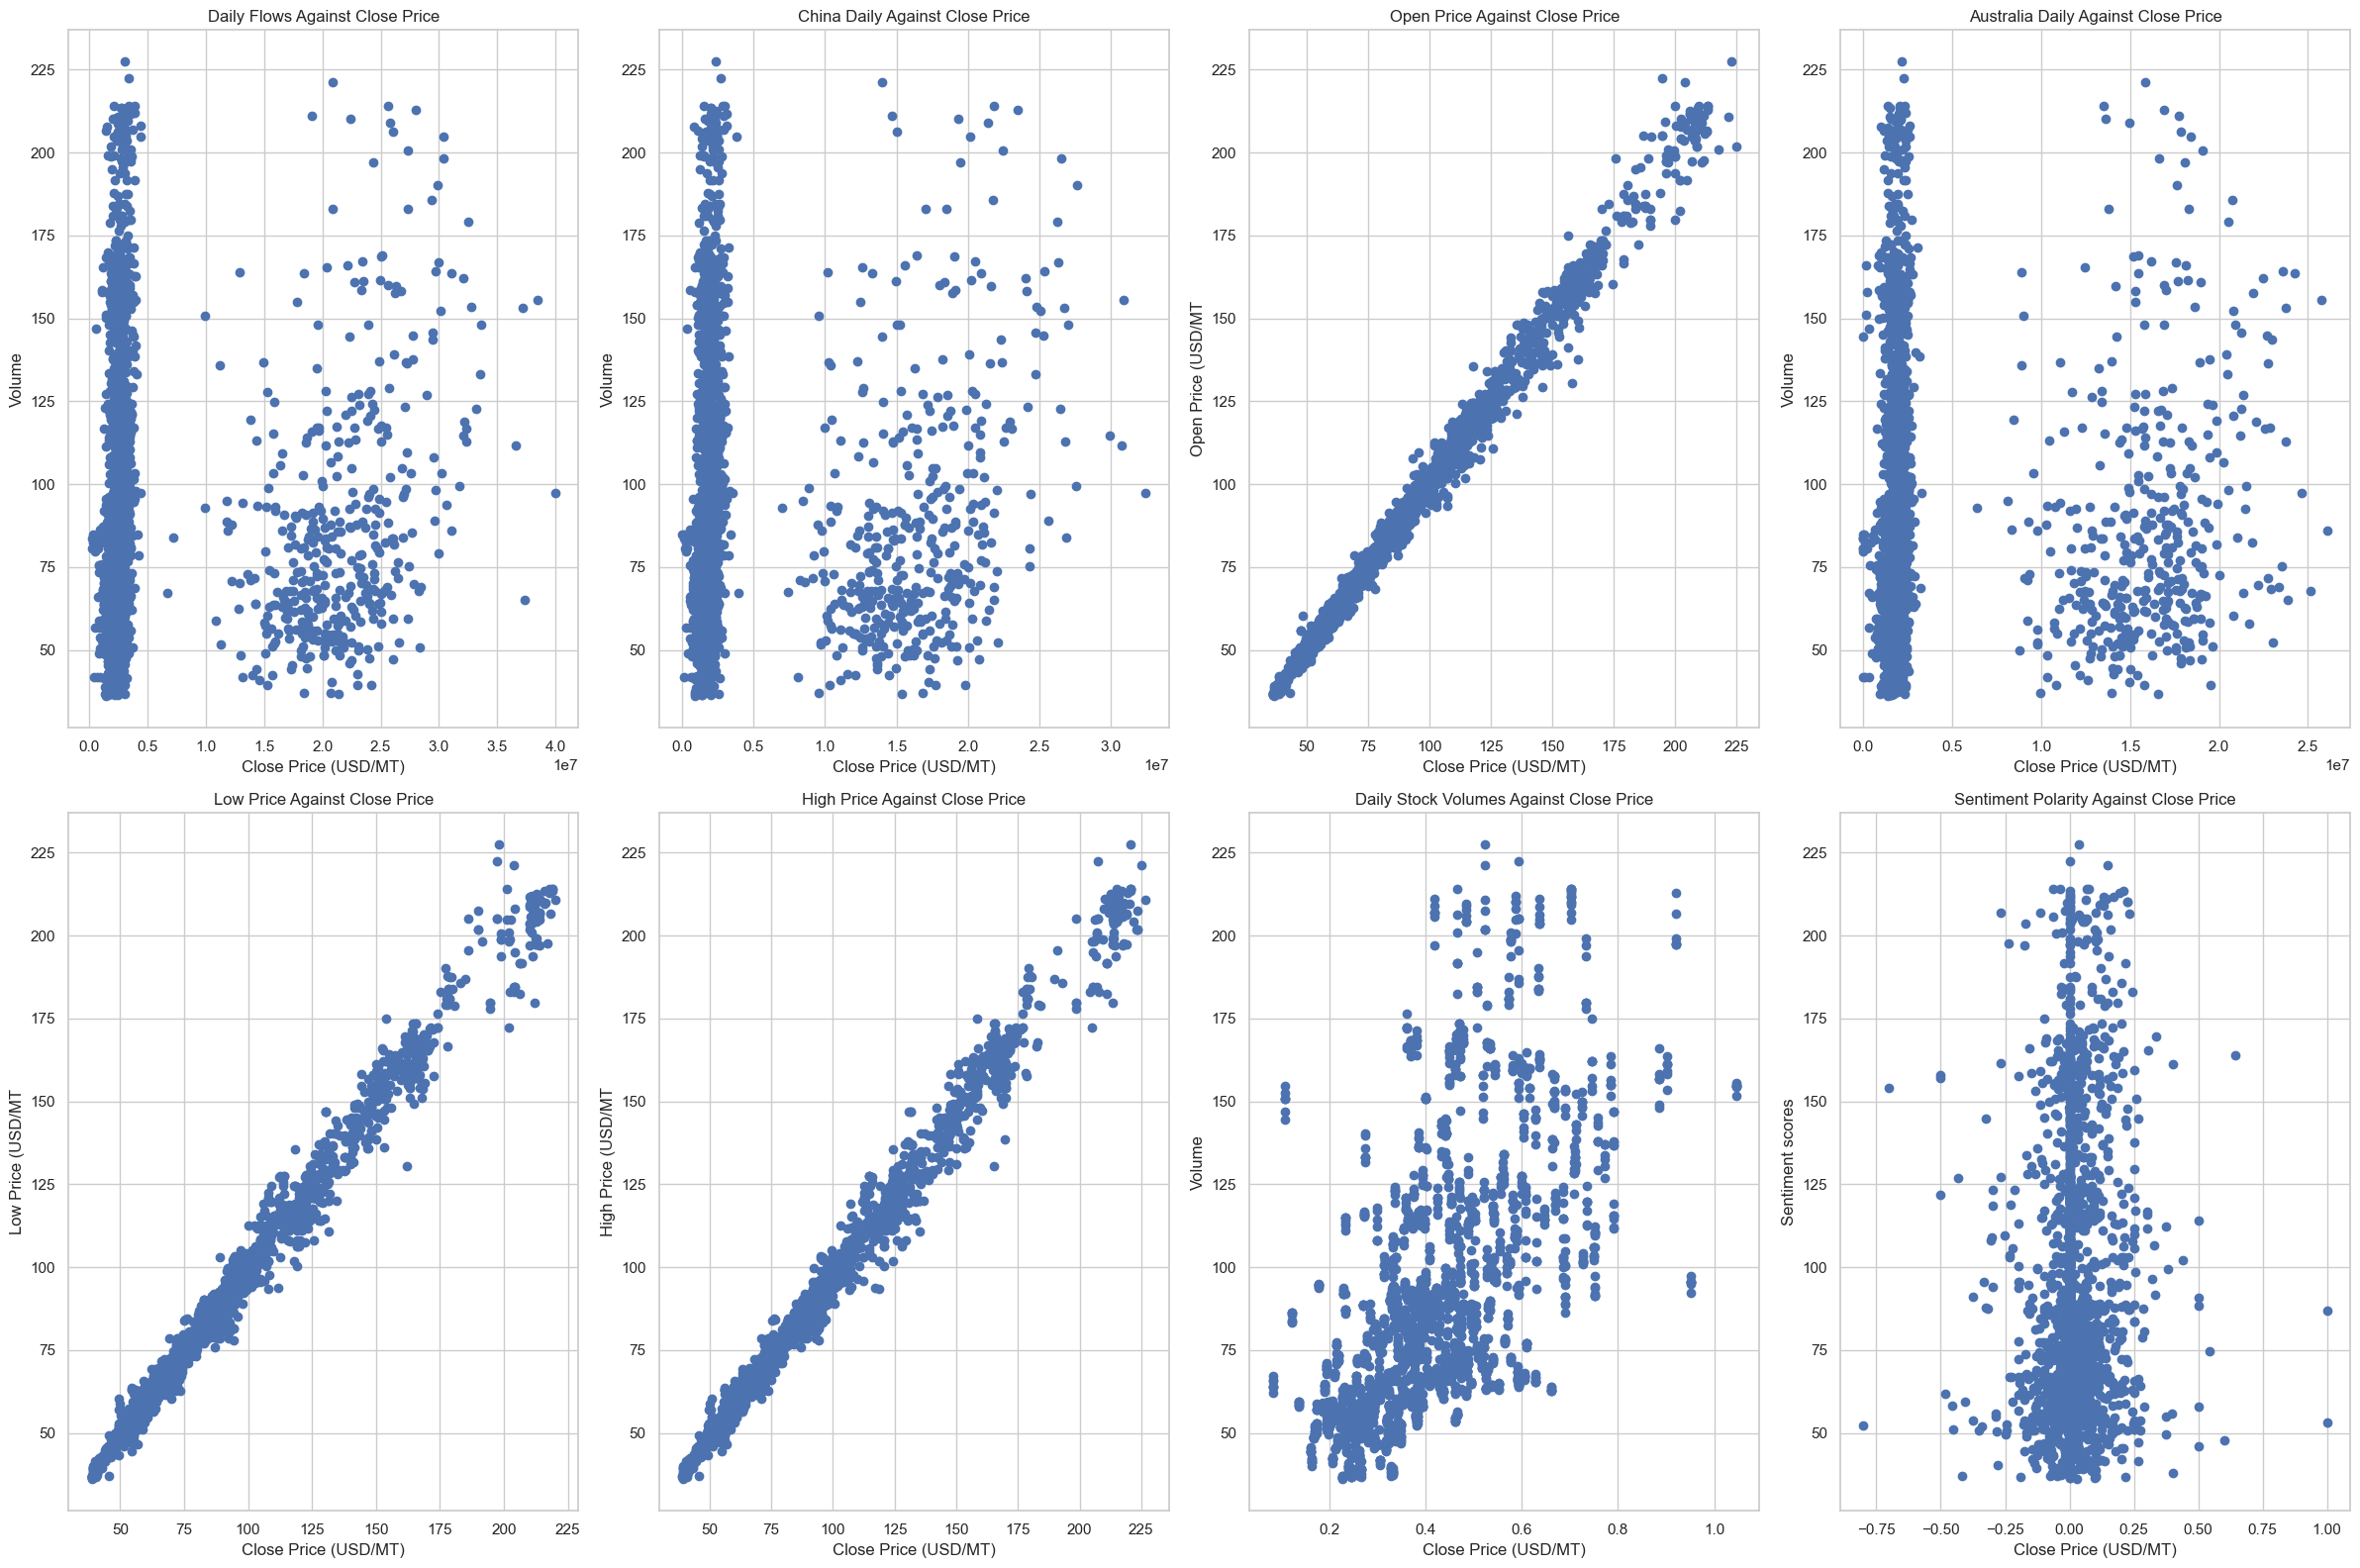

In [460]:
#Visualisation for the report


#Select Correlations with closing-price of second-month


# Defining the figure and subplots
fig, axs = plt.subplots(2, 4, figsize=(24, 16))  


# Plotting Flows Volumes over time
axs[0, 0].scatter(X_train_second_cleaned['flows_daily_total'], y_train_second_cleaned['CLOSE_y'])
axs[0, 0].set_title('Daily Flows Against Close Price')
axs[0, 0].set_xlabel('Close Price (USD/MT)')
axs[0, 0].set_ylabel('Volume')

# Plotting China Imports over time
axs[0, 1].scatter(X_train_second_cleaned['china_daily_import'], y_train_second_cleaned['CLOSE_y'])
axs[0, 1].set_title('China Daily Against Close Price')
axs[0, 1].set_xlabel('Close Price (USD/MT)')
axs[0, 1].set_ylabel('Volume')

# Plotting ROW Imports over time
axs[0, 2].scatter(X_train_second_cleaned['OPEN_y'], y_train_second_cleaned['CLOSE_y'])
axs[0, 2].set_title('Open Price Against Close Price')
axs[0, 2].set_xlabel('Close Price (USD/MT)')
axs[0, 2].set_ylabel('Open Price (USD/MT')

# Plotting Australia Exports over time
axs[0, 3].scatter(X_train_second_cleaned['aus_daily_export'], y_train_second_cleaned['CLOSE_y'])
axs[0, 3].set_title('Australia Daily Against Close Price')
axs[0, 3].set_xlabel('Close Price (USD/MT)')
axs[0, 3].set_ylabel('Volume')

# Plotting Brazil Exports over time
axs[1, 0].scatter(X_train_second_cleaned['LOW_x'], y_train_second_cleaned['CLOSE_y'])
axs[1, 0].set_title('Low Price Against Close Price')
axs[1, 0].set_xlabel('Close Price (USD/MT)')
axs[1, 0].set_ylabel('Low Price (USD/MT')

# Plotting ROW Exports over time
axs[1, 1].scatter(X_train_second_cleaned['HIGH_x'], y_train_second_cleaned['CLOSE_y'])
axs[1, 1].set_title('High Price Against Close Price')
axs[1, 1].set_xlabel('Close Price (USD/MT)')
axs[1, 1].set_ylabel('High Price (USD/MT')

# Plotting Stock Volumes over time
axs[1, 2].scatter(X_train_second_cleaned['stocks_daily'], y_train_second_cleaned['CLOSE_y'])
axs[1, 2].set_title('Daily Stock Volumes Against Close Price')
axs[1, 2].set_xlabel('Close Price (USD/MT)')
axs[1, 2].set_ylabel('Volume')

# Plotting Sentiment scores over time
axs[1, 3].scatter(X_train_second_cleaned['polarity_avg_daily'], y_train_second_cleaned['CLOSE_y'])
axs[1, 3].set_title('Sentiment Polarity Against Close Price')
axs[1, 3].set_xlabel('Close Price (USD/MT)')
axs[1, 3].set_ylabel('Sentiment scores')


# Adjust the subplots layout
plt.tight_layout()

# Show the plot
plt.show()

## Data Realignment <a class="anchor" id="data-realign"></a>

We will shift the values of the y datasets up by one time-step such as X(t) corresponds with y(t+1)

In [422]:
X_train_front_cleaned.tail()

HIGH_x      LOW_x     OPEN_x    VOLUME_x  HIGH_y  LOW_y  \
Date                                                                     
2022-10-27  93.383333  92.983333  93.366667  259.666667   88.25   81.2   
2022-10-28  93.016667  92.616667  92.983333  417.333333   82.60   78.8   
2022-10-29  93.016667  92.616667  92.983333  417.333333   82.60   78.8   
2022-10-30  93.016667  92.616667  92.983333  417.333333   82.60   78.8   
2022-10-31  92.650000  92.250000  92.600000  575.000000   80.50   75.0   

            OPEN_y  CLOSE_y  VOLUME_y Overall Sentiment  flows_daily_total  \
Date                                                                         
2022-10-27   86.60    81.71   85428.0       Non-neutral       2.162870e+06   
2022-10-28   82.55    80.69   76203.0       Non-neutral       2.663315e+06   
2022-10-29   82.55    80.69   76203.0           Neutral       2.370509e+06   
2022-10-30   82.55    80.69   76203.0       Non-neutral       4.195710e+06   
2022-10-31   80.20    78.57   17191.0           Neutral       2.793603e+07   

            china_daily_import  row_daily_import  aus_daily_export  \
Date                                                                 
2022-10-27        1.936770e+06        226100.519      1.359520e+06   
2022-10-28        1.839490e+06        823825.665      1.674147e+06   
2022-10-29        2.031363e+06        339145.565      1.714941e+06   
2022-10-30        3.281215e+06        914494.717      2.270725e+06   
2022-10-31        2.167373e+07       6262303.716      2.008872e+07   

            brazil_daily_export  row_daily_export  polarity_avg_daily  \
Date                                                                    
2022-10-27           367493.000        435857.122            0.133333   
2022-10-28           746615.417        242553.127            0.181818   
2022-10-29           406442.000        249125.216            0.000000   
2022-10-30          1485193.277        439791.184            0.045455   
2022-10-31          4675804.623       3171505.095            0.000000   

            article_count_daily  stocks_daily  
Date                                           
2022-10-27                    1       0.49869  
2022-10-28                    1       0.49869  
2022-10-29                    0       0.49869  
2022-10-30                    2       0.49869  
2022-10-31                    0       0.53637

In [423]:
X_test_front_cleaned.head()

HIGH_x  LOW_x  OPEN_x  VOLUME_x  HIGH_y  LOW_y  OPEN_y  CLOSE_y  \
Date                                                                          
2022-10-31   92.65  92.25    92.6     575.0  80.500  75.00   80.20    78.57   
2022-11-01   80.75  76.85    78.7   11994.0  79.100  75.25   77.25    78.10   
2022-11-02   83.05  79.45    80.0   20200.0  81.450  77.65   78.45    80.52   
2022-11-03   83.70  81.55    82.1   12862.0  82.050  79.80   80.55    81.72   
2022-11-04   93.00  82.80    83.3   26527.0  85.125  81.80   83.40    85.95   

            VOLUME_y Overall Sentiment  flows_daily_total  china_daily_import  \
Date                                                                            
2022-10-31   17191.0           Neutral        3822183.097         1202452.918   
2022-11-01   32318.0       Non-neutral        2324459.102         1717052.602   
2022-11-02   52080.0           Neutral        3070751.500         2226891.935   
2022-11-03   36629.0       Non-neutral        2538039.921         2077293.926   
2022-11-04   47403.0           Neutral        2666177.592         2255212.698   

            row_daily_import  aus_daily_export  brazil_daily_export  \
Date                                                                  
2022-10-31       2619730.179       1202452.918          2619730.179   
2022-11-01        607406.500       2151431.653           173027.449   
2022-11-02        843859.565       2195252.795           494033.801   
2022-11-03        460745.995       2095385.724           275959.230   
2022-11-04        410964.894       2190926.186           420695.877   

            row_daily_export  polarity_avg_daily  article_count_daily  \
Date                                                                    
2022-10-31             0.000            0.000000                    0   
2022-11-01             0.000            0.022917                    4   
2022-11-02        381464.904            0.000000                    0   
2022-11-03        166694.967           -0.005876                    3   
2022-11-04         54555.529            0.000000                    0   

            stocks_daily  
Date                      
2022-10-31      0.065459  
2022-11-01      0.065459  
2022-11-02      0.065459  
2022-11-03      0.065459  
2022-11-04      0.065459

In [424]:
X_train_second_cleaned.tail()

HIGH_x      LOW_x     OPEN_x  CLOSE_x    VOLUME_x  HIGH_y  \
Date                                                                       
2022-10-27  93.383333  92.983333  93.366667    92.89  259.666667   88.25   
2022-10-28  93.016667  92.616667  92.983333    92.59  417.333333   82.60   
2022-10-29  93.016667  92.616667  92.983333    92.59  417.333333   82.60   
2022-10-30  93.016667  92.616667  92.983333    92.59  417.333333   82.60   
2022-10-31  92.650000  92.250000  92.600000    92.43  575.000000   80.50   

            LOW_y  OPEN_y  VOLUME_y Overall Sentiment  flows_daily_total  \
Date                                                                       
2022-10-27   81.2   86.60   85428.0       Non-neutral       2.162870e+06   
2022-10-28   78.8   82.55   76203.0       Non-neutral       2.663315e+06   
2022-10-29   78.8   82.55   76203.0           Neutral       2.370509e+06   
2022-10-30   78.8   82.55   76203.0       Non-neutral       4.195710e+06   
2022-10-31   75.0   80.20   17191.0           Neutral       2.793603e+07   

            china_daily_import  row_daily_import  aus_daily_export  \
Date                                                                 
2022-10-27        1.936770e+06        226100.519      1.359520e+06   
2022-10-28        1.839490e+06        823825.665      1.674147e+06   
2022-10-29        2.031363e+06        339145.565      1.714941e+06   
2022-10-30        3.281215e+06        914494.717      2.270725e+06   
2022-10-31        2.167373e+07       6262303.716      2.008872e+07   

            brazil_daily_export  row_daily_export  polarity_avg_daily  \
Date                                                                    
2022-10-27           367493.000        435857.122            0.133333   
2022-10-28           746615.417        242553.127            0.181818   
2022-10-29           406442.000        249125.216            0.000000   
2022-10-30          1485193.277        439791.184            0.045455   
2022-10-31          4675804.623       3171505.095            0.000000   

            article_count_daily  stocks_daily  
Date                                           
2022-10-27                    1       0.49869  
2022-10-28                    1       0.49869  
2022-10-29                    0       0.49869  
2022-10-30                    2       0.49869  
2022-10-31                    0       0.53637

In [425]:
X_test_second_cleaned.head()

HIGH_x  LOW_x  OPEN_x  CLOSE_x  VOLUME_x  HIGH_y  LOW_y  OPEN_y  \
Date                                                                          
2022-10-31   92.65  92.25    92.6    92.43     575.0  80.500  75.00   80.20   
2022-11-01   80.75  76.85    78.7    79.79   11994.0  79.100  75.25   77.25   
2022-11-02   83.05  79.45    80.0    82.12   20200.0  81.450  77.65   78.45   
2022-11-03   83.70  81.55    82.1    83.32   12862.0  82.050  79.80   80.55   
2022-11-04   93.00  82.80    83.3    86.97   26527.0  85.125  81.80   83.40   

            VOLUME_y Overall Sentiment  flows_daily_total  china_daily_import  \
Date                                                                            
2022-10-31   17191.0           Neutral        3822183.097         1202452.918   
2022-11-01   32318.0       Non-neutral        2324459.102         1717052.602   
2022-11-02   52080.0           Neutral        3070751.500         2226891.935   
2022-11-03   36629.0       Non-neutral        2538039.921         2077293.926   
2022-11-04   47403.0           Neutral        2666177.592         2255212.698   

            row_daily_import  aus_daily_export  brazil_daily_export  \
Date                                                                  
2022-10-31       2619730.179       1202452.918          2619730.179   
2022-11-01        607406.500       2151431.653           173027.449   
2022-11-02        843859.565       2195252.795           494033.801   
2022-11-03        460745.995       2095385.724           275959.230   
2022-11-04        410964.894       2190926.186           420695.877   

            row_daily_export  polarity_avg_daily  article_count_daily  \
Date                                                                    
2022-10-31             0.000            0.000000                    0   
2022-11-01             0.000            0.022917                    4   
2022-11-02        381464.904            0.000000                    0   
2022-11-03        166694.967           -0.005876                    3   
2022-11-04         54555.529            0.000000                    0   

            stocks_daily  
Date                      
2022-10-31      0.065459  
2022-11-01      0.065459  
2022-11-02      0.065459  
2022-11-03      0.065459  
2022-11-04      0.065459

In [426]:
#Dropping first row from test data given overlap with training data

X_test_front_cleaned.drop(X_test_front_cleaned.index[0], inplace=True)
y_test_front_cleaned.drop(y_test_front_cleaned.index[0], inplace=True)

X_test_second_cleaned.drop(X_test_second_cleaned.index[0], inplace=True)
y_test_second_cleaned.drop(y_test_second_cleaned.index[0], inplace=True)

In [427]:
X_test_front_cleaned.head()

HIGH_x  LOW_x  OPEN_x  VOLUME_x  HIGH_y  LOW_y  OPEN_y  CLOSE_y  \
Date                                                                          
2022-11-01   80.75  76.85    78.7   11994.0  79.100  75.25   77.25    78.10   
2022-11-02   83.05  79.45    80.0   20200.0  81.450  77.65   78.45    80.52   
2022-11-03   83.70  81.55    82.1   12862.0  82.050  79.80   80.55    81.72   
2022-11-04   93.00  82.80    83.3   26527.0  85.125  81.80   83.40    85.95   
2022-11-05   93.00  82.80    83.3   26527.0  85.125  81.80   83.40    85.95   

            VOLUME_y Overall Sentiment  flows_daily_total  china_daily_import  \
Date                                                                            
2022-11-01   32318.0       Non-neutral        2324459.102         1717052.602   
2022-11-02   52080.0           Neutral        3070751.500         2226891.935   
2022-11-03   36629.0       Non-neutral        2538039.921         2077293.926   
2022-11-04   47403.0           Neutral        2666177.592         2255212.698   
2022-11-05   47403.0           Neutral        2745872.120         2353583.207   

            row_daily_import  aus_daily_export  brazil_daily_export  \
Date                                                                  
2022-11-01        607406.500       2151431.653           173027.449   
2022-11-02        843859.565       2195252.795           494033.801   
2022-11-03        460745.995       2095385.724           275959.230   
2022-11-04        410964.894       2190926.186           420695.877   
2022-11-05        392288.913       2030420.803           349105.638   

            row_daily_export  polarity_avg_daily  article_count_daily  \
Date                                                                    
2022-11-01             0.000            0.022917                    4   
2022-11-02        381464.904            0.000000                    0   
2022-11-03        166694.967           -0.005876                    3   
2022-11-04         54555.529            0.000000                    0   
2022-11-05        366345.679            0.000000                    0   

            stocks_daily  
Date                      
2022-11-01      0.065459  
2022-11-02      0.065459  
2022-11-03      0.065459  
2022-11-04      0.065459  
2022-11-05      0.065459

In [428]:
X_test_second_cleaned.head()

HIGH_x  LOW_x  OPEN_x  CLOSE_x  VOLUME_x  HIGH_y  LOW_y  OPEN_y  \
Date                                                                          
2022-11-01   80.75  76.85    78.7    79.79   11994.0  79.100  75.25   77.25   
2022-11-02   83.05  79.45    80.0    82.12   20200.0  81.450  77.65   78.45   
2022-11-03   83.70  81.55    82.1    83.32   12862.0  82.050  79.80   80.55   
2022-11-04   93.00  82.80    83.3    86.97   26527.0  85.125  81.80   83.40   
2022-11-05   93.00  82.80    83.3    86.97   26527.0  85.125  81.80   83.40   

            VOLUME_y Overall Sentiment  flows_daily_total  china_daily_import  \
Date                                                                            
2022-11-01   32318.0       Non-neutral        2324459.102         1717052.602   
2022-11-02   52080.0           Neutral        3070751.500         2226891.935   
2022-11-03   36629.0       Non-neutral        2538039.921         2077293.926   
2022-11-04   47403.0           Neutral        2666177.592         2255212.698   
2022-11-05   47403.0           Neutral        2745872.120         2353583.207   

            row_daily_import  aus_daily_export  brazil_daily_export  \
Date                                                                  
2022-11-01        607406.500       2151431.653           173027.449   
2022-11-02        843859.565       2195252.795           494033.801   
2022-11-03        460745.995       2095385.724           275959.230   
2022-11-04        410964.894       2190926.186           420695.877   
2022-11-05        392288.913       2030420.803           349105.638   

            row_daily_export  polarity_avg_daily  article_count_daily  \
Date                                                                    
2022-11-01             0.000            0.022917                    4   
2022-11-02        381464.904            0.000000                    0   
2022-11-03        166694.967           -0.005876                    3   
2022-11-04         54555.529            0.000000                    0   
2022-11-05        366345.679            0.000000                    0   

            stocks_daily  
Date                      
2022-11-01      0.065459  
2022-11-02      0.065459  
2022-11-03      0.065459  
2022-11-04      0.065459  
2022-11-05      0.065459

In [430]:
X_test_front_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 368 entries, 2022-11-01 to 2023-11-03
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HIGH_x               368 non-null    float64
 1   LOW_x                368 non-null    float64
 2   OPEN_x               368 non-null    float64
 3   VOLUME_x             368 non-null    float64
 4   HIGH_y               368 non-null    float64
 5   LOW_y                368 non-null    float64
 6   OPEN_y               368 non-null    float64
 7   CLOSE_y              368 non-null    float64
 8   VOLUME_y             368 non-null    float64
 9   Overall Sentiment    368 non-null    object 
 10  flows_daily_total    368 non-null    float64
 11  china_daily_import   368 non-null    float64
 12  row_daily_import     368 non-null    float64
 13  aus_daily_export     368 non-null    float64
 14  brazil_daily_export  368 non-null    float64
 15  row_daily_export     

In [431]:
X_test_second_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 368 entries, 2022-11-01 to 2023-11-03
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HIGH_x               368 non-null    float64
 1   LOW_x                368 non-null    float64
 2   OPEN_x               368 non-null    float64
 3   CLOSE_x              368 non-null    float64
 4   VOLUME_x             368 non-null    float64
 5   HIGH_y               368 non-null    float64
 6   LOW_y                368 non-null    float64
 7   OPEN_y               368 non-null    float64
 8   VOLUME_y             368 non-null    float64
 9   Overall Sentiment    368 non-null    object 
 10  flows_daily_total    368 non-null    float64
 11  china_daily_import   368 non-null    float64
 12  row_daily_import     368 non-null    float64
 13  aus_daily_export     368 non-null    float64
 14  brazil_daily_export  368 non-null    float64
 15  row_daily_export     

In [432]:
y_train_front_cleaned.head()

CLOSE_x
Date               
2015-01-02    70.67
2015-01-03    70.67
2015-01-04    70.67
2015-01-05    69.94
2015-01-06    71.64

In [433]:
y_test_front_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 368 entries, 2022-11-01 to 2023-11-03
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CLOSE_x  368 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


In [434]:
y_train_second_cleaned.head()

CLOSE_y
Date               
2015-01-02    70.25
2015-01-03    70.25
2015-01-04    70.25
2015-01-05    69.41
2015-01-06    71.19

In [435]:
y_test_second_cleaned.head()

CLOSE_y
Date               
2022-11-01    78.10
2022-11-02    80.52
2022-11-03    81.72
2022-11-04    85.95
2022-11-05    85.95

In [436]:
## Shifting y values up by one such that y(t+1) corresponds with X(t) for all datasets 

y_train_front_cleaned.loc[:,'CLOSE_x'] = y_train_front_cleaned['CLOSE_x'].shift(-1)
y_test_front_cleaned.loc[:,'CLOSE_x'] = y_test_front_cleaned['CLOSE_x'].shift(-1)

#For second-month contracts
y_train_second_cleaned.loc[:,'CLOSE_y'] = y_train_second_cleaned['CLOSE_y'].shift(-1)
y_test_second_cleaned.loc[:,'CLOSE_y'] = y_test_second_cleaned['CLOSE_y'].shift(-1)

In [437]:
X_train_front_cleaned.tail()

HIGH_x      LOW_x     OPEN_x    VOLUME_x  HIGH_y  LOW_y  \
Date                                                                     
2022-10-27  93.383333  92.983333  93.366667  259.666667   88.25   81.2   
2022-10-28  93.016667  92.616667  92.983333  417.333333   82.60   78.8   
2022-10-29  93.016667  92.616667  92.983333  417.333333   82.60   78.8   
2022-10-30  93.016667  92.616667  92.983333  417.333333   82.60   78.8   
2022-10-31  92.650000  92.250000  92.600000  575.000000   80.50   75.0   

            OPEN_y  CLOSE_y  VOLUME_y Overall Sentiment  flows_daily_total  \
Date                                                                         
2022-10-27   86.60    81.71   85428.0       Non-neutral       2.162870e+06   
2022-10-28   82.55    80.69   76203.0       Non-neutral       2.663315e+06   
2022-10-29   82.55    80.69   76203.0           Neutral       2.370509e+06   
2022-10-30   82.55    80.69   76203.0       Non-neutral       4.195710e+06   
2022-10-31   80.20    78.57   17191.0           Neutral       2.793603e+07   

            china_daily_import  row_daily_import  aus_daily_export  \
Date                                                                 
2022-10-27        1.936770e+06        226100.519      1.359520e+06   
2022-10-28        1.839490e+06        823825.665      1.674147e+06   
2022-10-29        2.031363e+06        339145.565      1.714941e+06   
2022-10-30        3.281215e+06        914494.717      2.270725e+06   
2022-10-31        2.167373e+07       6262303.716      2.008872e+07   

            brazil_daily_export  row_daily_export  polarity_avg_daily  \
Date                                                                    
2022-10-27           367493.000        435857.122            0.133333   
2022-10-28           746615.417        242553.127            0.181818   
2022-10-29           406442.000        249125.216            0.000000   
2022-10-30          1485193.277        439791.184            0.045455   
2022-10-31          4675804.623       3171505.095            0.000000   

            article_count_daily  stocks_daily  
Date                                           
2022-10-27                    1       0.49869  
2022-10-28                    1       0.49869  
2022-10-29                    0       0.49869  
2022-10-30                    2       0.49869  
2022-10-31                    0       0.53637

In [438]:
y_train_front_cleaned.head() #close price values have shifted up by 1 

CLOSE_x
Date               
2015-01-02    70.67
2015-01-03    70.67
2015-01-04    69.94
2015-01-05    71.64
2015-01-06    71.19

In [439]:
y_train_second_cleaned.head()

CLOSE_y
Date               
2015-01-02    70.25
2015-01-03    70.25
2015-01-04    69.41
2015-01-05    71.19
2015-01-06    70.50

In [440]:
y_train_front_cleaned.tail()

CLOSE_x
Date               
2022-10-27    92.59
2022-10-28    92.59
2022-10-29    92.59
2022-10-30    92.43
2022-10-31      NaN

In [441]:
X_test_front_cleaned.tail()

HIGH_x   LOW_x  OPEN_x  VOLUME_x  HIGH_y   LOW_y  OPEN_y  CLOSE_y  \
Date                                                                            
2023-10-30  118.95  118.75  118.85      50.0  122.00  120.45  121.80   121.72   
2023-10-31  119.00  118.00  118.85     458.0  122.00  120.10  121.80   121.55   
2023-11-01  124.35  121.15  121.45   36441.0  121.80  118.85  119.05   121.48   
2023-11-02  125.10  122.90  124.00   15494.0  122.75  120.40  121.55   122.59   
2023-11-03  126.20  124.05  124.55    5351.0  123.80  121.60  122.80   122.94   

            VOLUME_y Overall Sentiment  flows_daily_total  china_daily_import  \
Date                                                                            
2023-10-30   16919.0           Neutral        2720786.491         2361672.868   
2023-10-31   44076.0       Non-neutral        2577951.493         1857894.935   
2023-11-01   51751.0       Non-neutral        2290639.681         1217981.719   
2023-11-02   53356.0       Non-neutral        2802455.672         1827683.415   
2023-11-03   42420.0           Neutral        2848908.638         2066972.633   

            row_daily_import  aus_daily_export  brazil_daily_export  \
Date                                                                  
2023-10-30        359113.623       2276327.097           174757.928   
2023-10-31        720056.558       1665155.746           616177.000   
2023-11-01       1072657.962       1245018.990           575659.780   
2023-11-02        974772.257       2148427.913           168517.000   
2023-11-03        781936.005       1598911.095           741237.479   

            row_daily_export  polarity_avg_daily  article_count_daily  \
Date                                                                    
2023-10-30        269701.466            0.000000                    0   
2023-10-31        296618.747           -0.100000                    3   
2023-11-01        469960.911            0.303896                    1   
2023-11-02        485510.759            0.100000                    1   
2023-11-03        508760.064            0.000000                    0   

            stocks_daily  
Date                      
2023-10-30      0.555034  
2023-10-31      0.555034  
2023-11-01      0.555034  
2023-11-02      0.555034  
2023-11-03      0.555034

In [442]:
y_test_front_cleaned.tail()

CLOSE_x
Date               
2023-10-30   118.91
2023-10-31   123.92
2023-11-01   124.99
2023-11-02   125.39
2023-11-03      NaN

In [443]:
X_train_second_cleaned.tail()

HIGH_x      LOW_x     OPEN_x  CLOSE_x    VOLUME_x  HIGH_y  \
Date                                                                       
2022-10-27  93.383333  92.983333  93.366667    92.89  259.666667   88.25   
2022-10-28  93.016667  92.616667  92.983333    92.59  417.333333   82.60   
2022-10-29  93.016667  92.616667  92.983333    92.59  417.333333   82.60   
2022-10-30  93.016667  92.616667  92.983333    92.59  417.333333   82.60   
2022-10-31  92.650000  92.250000  92.600000    92.43  575.000000   80.50   

            LOW_y  OPEN_y  VOLUME_y Overall Sentiment  flows_daily_total  \
Date                                                                       
2022-10-27   81.2   86.60   85428.0       Non-neutral       2.162870e+06   
2022-10-28   78.8   82.55   76203.0       Non-neutral       2.663315e+06   
2022-10-29   78.8   82.55   76203.0           Neutral       2.370509e+06   
2022-10-30   78.8   82.55   76203.0       Non-neutral       4.195710e+06   
2022-10-31   75.0   80.20   17191.0           Neutral       2.793603e+07   

            china_daily_import  row_daily_import  aus_daily_export  \
Date                                                                 
2022-10-27        1.936770e+06        226100.519      1.359520e+06   
2022-10-28        1.839490e+06        823825.665      1.674147e+06   
2022-10-29        2.031363e+06        339145.565      1.714941e+06   
2022-10-30        3.281215e+06        914494.717      2.270725e+06   
2022-10-31        2.167373e+07       6262303.716      2.008872e+07   

            brazil_daily_export  row_daily_export  polarity_avg_daily  \
Date                                                                    
2022-10-27           367493.000        435857.122            0.133333   
2022-10-28           746615.417        242553.127            0.181818   
2022-10-29           406442.000        249125.216            0.000000   
2022-10-30          1485193.277        439791.184            0.045455   
2022-10-31          4675804.623       3171505.095            0.000000   

            article_count_daily  stocks_daily  
Date                                           
2022-10-27                    1       0.49869  
2022-10-28                    1       0.49869  
2022-10-29                    0       0.49869  
2022-10-30                    2       0.49869  
2022-10-31                    0       0.53637

In [444]:
y_train_second_cleaned.tail()

CLOSE_y
Date               
2022-10-27    80.69
2022-10-28    80.69
2022-10-29    80.69
2022-10-30    78.57
2022-10-31      NaN

In [445]:
X_test_second_cleaned.tail()

HIGH_x   LOW_x  OPEN_x  CLOSE_x  VOLUME_x  HIGH_y   LOW_y  OPEN_y  \
Date                                                                            
2023-10-30  118.95  118.75  118.85   118.97      50.0  122.00  120.45  121.80   
2023-10-31  119.00  118.00  118.85   118.91     458.0  122.00  120.10  121.80   
2023-11-01  124.35  121.15  121.45   123.92   36441.0  121.80  118.85  119.05   
2023-11-02  125.10  122.90  124.00   124.99   15494.0  122.75  120.40  121.55   
2023-11-03  126.20  124.05  124.55   125.39    5351.0  123.80  121.60  122.80   

            VOLUME_y Overall Sentiment  flows_daily_total  china_daily_import  \
Date                                                                            
2023-10-30   16919.0           Neutral        2720786.491         2361672.868   
2023-10-31   44076.0       Non-neutral        2577951.493         1857894.935   
2023-11-01   51751.0       Non-neutral        2290639.681         1217981.719   
2023-11-02   53356.0       Non-neutral        2802455.672         1827683.415   
2023-11-03   42420.0           Neutral        2848908.638         2066972.633   

            row_daily_import  aus_daily_export  brazil_daily_export  \
Date                                                                  
2023-10-30        359113.623       2276327.097           174757.928   
2023-10-31        720056.558       1665155.746           616177.000   
2023-11-01       1072657.962       1245018.990           575659.780   
2023-11-02        974772.257       2148427.913           168517.000   
2023-11-03        781936.005       1598911.095           741237.479   

            row_daily_export  polarity_avg_daily  article_count_daily  \
Date                                                                    
2023-10-30        269701.466            0.000000                    0   
2023-10-31        296618.747           -0.100000                    3   
2023-11-01        469960.911            0.303896                    1   
2023-11-02        485510.759            0.100000                    1   
2023-11-03        508760.064            0.000000                    0   

            stocks_daily  
Date                      
2023-10-30      0.555034  
2023-10-31      0.555034  
2023-11-01      0.555034  
2023-11-02      0.555034  
2023-11-03      0.555034

In [446]:
y_test_second_cleaned.tail()

CLOSE_y
Date               
2023-10-30   121.55
2023-10-31   121.48
2023-11-01   122.59
2023-11-02   122.94
2023-11-03      NaN

As a result of the shifting, we have a NaN value at the end which we shall drop for all datasets

In [447]:
## Dropping rows in X and Y as a result of this data realignment 

X_train_front_cleaned = X_train_front_cleaned[:-1] #dropping the last row
y_train_front_cleaned = y_train_front_cleaned.dropna(subset=['CLOSE_x'])
X_test_front_cleaned = X_test_front_cleaned[:-1] #dropping the last row
y_test_front_cleaned = y_test_front_cleaned.dropna(subset=['CLOSE_x'])


# For second-month contracts 

X_train_second_cleaned = X_train_second_cleaned[:-1] #dropping the last row
y_train_second_cleaned = y_train_second_cleaned.dropna(subset=['CLOSE_y'])
X_test_second_cleaned = X_test_second_cleaned[:-1] #dropping the last row
y_test_second_cleaned = y_test_second_cleaned.dropna(subset=['CLOSE_y'])

In [449]:
#Resetting index and changing Date to column


X_train_front_cleaned.reset_index(inplace=True)
y_train_front_cleaned.reset_index(inplace=True)
X_test_front_cleaned.reset_index(inplace=True)
y_test_front_cleaned.reset_index(inplace=True)

#Second-month
X_train_second_cleaned.reset_index(inplace=True)
y_train_second_cleaned.reset_index(inplace=True)
X_test_second_cleaned.reset_index(inplace=True)
y_test_second_cleaned.reset_index(inplace=True)

In [450]:
X_train_front_cleaned.head()

Date  HIGH_x  LOW_x  OPEN_x  VOLUME_x  HIGH_y  LOW_y  OPEN_y  CLOSE_y  \
0 2015-01-02   71.75  71.75   71.75       5.0   71.52  69.97   69.97    70.25   
1 2015-01-03   71.75  71.75   71.75       5.0   71.52  69.97   69.97    70.25   
2 2015-01-04   71.75  71.75   71.75       5.0   71.52  69.97   69.97    70.25   
3 2015-01-05   71.75  71.75   71.75       5.0   71.52  69.97   69.97    69.41   
4 2015-01-06   71.75  71.75   71.75       5.0   71.52  69.97   69.97    71.19   

   VOLUME_y Overall Sentiment  flows_daily_total  china_daily_import  \
0      67.0           Neutral       2.561038e+06         1775968.861   
1      67.0           Neutral       1.277684e+06          967765.244   
2      67.0           Neutral       1.996771e+06         1669955.798   
3      67.0           Neutral       1.379357e+07         8273902.977   
4      67.0           Neutral       1.595791e+06          853504.655   

   row_daily_import  aus_daily_export  brazil_daily_export  row_daily_export  \
0        785069.436       2088849.696           331104.000        141084.601   
1        309918.644       1208866.154                0.000         68817.734   
2        326815.163       1257123.948           614166.235        125480.778   
3       5519666.376       9233797.320          3519837.000       1039935.033   
4        742286.747       1277238.466           106661.810        211891.126   

   polarity_avg_daily  article_count_daily  stocks_daily  
0                 0.0                    0        0.1955  
1                 0.0                    0        0.1955  
2                 0.0                    0        0.1955  
3                 0.0                    0        0.1955  
4                 0.0                    0        0.1955

In [451]:
X_test_front_cleaned.head()

Date  HIGH_x  LOW_x  OPEN_x  VOLUME_x  HIGH_y  LOW_y  OPEN_y  CLOSE_y  \
0 2022-11-01   80.75  76.85    78.7   11994.0  79.100  75.25   77.25    78.10   
1 2022-11-02   83.05  79.45    80.0   20200.0  81.450  77.65   78.45    80.52   
2 2022-11-03   83.70  81.55    82.1   12862.0  82.050  79.80   80.55    81.72   
3 2022-11-04   93.00  82.80    83.3   26527.0  85.125  81.80   83.40    85.95   
4 2022-11-05   93.00  82.80    83.3   26527.0  85.125  81.80   83.40    85.95   

   VOLUME_y Overall Sentiment  flows_daily_total  china_daily_import  \
0   32318.0       Non-neutral        2324459.102         1717052.602   
1   52080.0           Neutral        3070751.500         2226891.935   
2   36629.0       Non-neutral        2538039.921         2077293.926   
3   47403.0           Neutral        2666177.592         2255212.698   
4   47403.0           Neutral        2745872.120         2353583.207   

   row_daily_import  aus_daily_export  brazil_daily_export  row_daily_export  \
0        607406.500       2151431.653           173027.449             0.000   
1        843859.565       2195252.795           494033.801        381464.904   
2        460745.995       2095385.724           275959.230        166694.967   
3        410964.894       2190926.186           420695.877         54555.529   
4        392288.913       2030420.803           349105.638        366345.679   

   polarity_avg_daily  article_count_daily  stocks_daily  
0            0.022917                    4      0.065459  
1            0.000000                    0      0.065459  
2           -0.005876                    3      0.065459  
3            0.000000                    0      0.065459  
4            0.000000                    0      0.065459

In [452]:
X_train_second_cleaned.head()

Date  HIGH_x  LOW_x  OPEN_x  CLOSE_x  VOLUME_x  HIGH_y  LOW_y  OPEN_y  \
0 2015-01-02   71.75  71.75   71.75    70.67       5.0   71.52  69.97   69.97   
1 2015-01-03   71.75  71.75   71.75    70.67       5.0   71.52  69.97   69.97   
2 2015-01-04   71.75  71.75   71.75    70.67       5.0   71.52  69.97   69.97   
3 2015-01-05   71.75  71.75   71.75    69.94       5.0   71.52  69.97   69.97   
4 2015-01-06   71.75  71.75   71.75    71.64       5.0   71.52  69.97   69.97   

   VOLUME_y Overall Sentiment  flows_daily_total  china_daily_import  \
0      67.0           Neutral       2.561038e+06         1775968.861   
1      67.0           Neutral       1.277684e+06          967765.244   
2      67.0           Neutral       1.996771e+06         1669955.798   
3      67.0           Neutral       1.379357e+07         8273902.977   
4      67.0           Neutral       1.595791e+06          853504.655   

   row_daily_import  aus_daily_export  brazil_daily_export  row_daily_export  \
0        785069.436       2088849.696           331104.000        141084.601   
1        309918.644       1208866.154                0.000         68817.734   
2        326815.163       1257123.948           614166.235        125480.778   
3       5519666.376       9233797.320          3519837.000       1039935.033   
4        742286.747       1277238.466           106661.810        211891.126   

   polarity_avg_daily  article_count_daily  stocks_daily  
0                 0.0                    0        0.1955  
1                 0.0                    0        0.1955  
2                 0.0                    0        0.1955  
3                 0.0                    0        0.1955  
4                 0.0                    0        0.1955

In [453]:
X_test_second_cleaned

Date  HIGH_x   LOW_x  OPEN_x  CLOSE_x  VOLUME_x   HIGH_y   LOW_y  \
0   2022-11-01   80.75   76.85   78.70    79.79   11994.0   79.100   75.25   
1   2022-11-02   83.05   79.45   80.00    82.12   20200.0   81.450   77.65   
2   2022-11-03   83.70   81.55   82.10    83.32   12862.0   82.050   79.80   
3   2022-11-04   93.00   82.80   83.30    86.97   26527.0   85.125   81.80   
4   2022-11-05   93.00   82.80   83.30    86.97   26527.0   85.125   81.80   
..         ...     ...     ...     ...      ...       ...      ...     ...   
362 2023-10-29  118.90  118.50  118.65   118.88    1928.0  120.000  115.75   
363 2023-10-30  118.95  118.75  118.85   118.97      50.0  122.000  120.45   
364 2023-10-31  119.00  118.00  118.85   118.91     458.0  122.000  120.10   
365 2023-11-01  124.35  121.15  121.45   123.92   36441.0  121.800  118.85   
366 2023-11-02  125.10  122.90  124.00   124.99   15494.0  122.750  120.40   

     OPEN_y  VOLUME_y Overall Sentiment  flows_daily_total  \
0     77.25   32318.0       Non-neutral        2324459.102   
1     78.45   52080.0           Neutral        3070751.500   
2     80.55   36629.0       Non-neutral        2538039.921   
3     83.40   47403.0           Neutral        2666177.592   
4     83.40   47403.0           Neutral        2745872.120   
..      ...       ...               ...                ...   
362  116.60   82671.0           Neutral        2184833.389   
363  121.80   16919.0           Neutral        2720786.491   
364  121.80   44076.0       Non-neutral        2577951.493   
365  119.05   51751.0       Non-neutral        2290639.681   
366  121.55   53356.0       Non-neutral        2802455.672   

     china_daily_import  row_daily_import  aus_daily_export  \
0           1717052.602        607406.500       2151431.653   
1           2226891.935        843859.565       2195252.795   
2           2077293.926        460745.995       2095385.724   
3           2255212.698        410964.894       2190926.186   
4           2353583.207        392288.913       2030420.803   
..                  ...               ...               ...   
362         1643116.928        541716.461       1577108.178   
363         2361672.868        359113.623       2276327.097   
364         1857894.935        720056.558       1665155.746   
365         1217981.719       1072657.962       1245018.990   
366         1827683.415        974772.257       2148427.913   

     brazil_daily_export  row_daily_export  polarity_avg_daily  \
0             173027.449             0.000            0.022917   
1             494033.801        381464.904            0.000000   
2             275959.230        166694.967           -0.005876   
3             420695.877         54555.529            0.000000   
4             349105.638        366345.679            0.000000   
..                   ...               ...                 ...   
362           394808.000        212917.211            0.000000   
363           174757.928        269701.466            0.000000   
364           616177.000        296618.747           -0.100000   
365           575659.780        469960.911            0.303896   
366           168517.000        485510.759            0.100000   

     article_count_daily  stocks_daily  
0                      4      0.065459  
1                      0      0.065459  
2                      3      0.065459  
3                      0      0.065459  
4                      0      0.065459  
..                   ...           ...  
362                    0      0.555034  
363                    0      0.555034  
364                    3      0.555034  
365                    1      0.555034  
366                    1      0.555034  

[367 rows x 20 columns]

In [454]:
y_train_front_cleaned.head()

Date  CLOSE_x
0 2015-01-02    70.67
1 2015-01-03    70.67
2 2015-01-04    69.94
3 2015-01-05    71.64
4 2015-01-06    71.19

In [455]:
y_test_front_cleaned.head()

Date  CLOSE_x
0 2022-11-01    82.12
1 2022-11-02    83.32
2 2022-11-03    86.97
3 2022-11-04    86.97
4 2022-11-05    86.97

In [456]:
y_train_second_cleaned.head()

Date  CLOSE_y
0 2015-01-02    70.25
1 2015-01-03    70.25
2 2015-01-04    69.41
3 2015-01-05    71.19
4 2015-01-06    70.50

In [457]:
y_test_second_cleaned.head()

Date  CLOSE_y
0 2022-11-01    80.52
1 2022-11-02    81.72
2 2022-11-03    85.95
3 2022-11-04    85.95
4 2022-11-05    85.95

In [ ]:
# Saving cleaned datasets to csv 

X_train_front_cleaned.to_csv('X_train_front_filled.csv', index=False)
y_train_front_cleaned.to_csv('y_train_front_filled.csv', index=False)
X_train_second_cleaned.to_csv('X_train_second_filled.csv', index=False)
y_train_second_cleaned.to_csv('y_train_second_filled.csv', index=False)

X_test_front_cleaned.to_csv('X_test_front_filled.csv', index=False)
y_test_front_cleaned.to_csv('y_test_front_filled.csv', index=False)
X_test_second_cleaned.to_csv('X_test_second_filled.csv', index=False)
y_test_second_cleaned.to_csv('y_test_second_filled.csv', index=False)